In [2]:
import torch
import numpy as np
import os
import numpy as np
import torch
import torch
import torch.nn as nn
import torchvision.models
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader,RandomSampler
from torchvision import transforms
import tifffile
import glob
import torchsummary
from torch.utils.data import random_split
import tqdm
import models
from data import *
import torch.optim as optim
import matplotlib.pyplot as plt

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    if torch.backends.mps.is_available():
        print('Using mps')
        device = 'mps'
    else:
        print('Using CPU')
        device = 'cpu'
else:
    print('Using GPU')
    device = 'GPU'

/Users/karthiksanka/opt/anaconda3/envs/deeplearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/karthiksanka/opt/anaconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/karthiksanka/opt/anaconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using mps


In [3]:
root_dir = 'Residential_density/NAIP(US_Dense)'
dataset = NAIP(root_dir, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_dataset, val_dataset = split_dataset(dataset = dataset, validation_fraction=0.2)
# train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=128)
val_loader_naip = DataLoader(dataset=val_dataset, shuffle=False, batch_size=128)
rand_sampler = torch.utils.data.RandomSampler(train_dataset, num_samples=64, replacement=True)
rand_sampler_naip_test = torch.utils.data.RandomSampler(val_dataset, num_samples=64, replacement=True)
rand_loader_naip = DataLoader(train_dataset,sampler=rand_sampler,batch_size=64)
rand_loader_naip_test = DataLoader(val_dataset,sampler=rand_sampler_naip_test,batch_size=64)

root_dir = 'Residential_density/UC_merced'
dataset = UCmerced(root_dir, transform=preprocess)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_dataset, val_dataset = split_dataset(dataset = dataset, validation_fraction=0.2)
# train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=128)
val_loader_ucm = DataLoader(dataset=val_dataset, shuffle=False, batch_size=128)
rand_sampler = torch.utils.data.RandomSampler(train_dataset, num_samples=64, replacement=True)
rand_loader_ucm = DataLoader(train_dataset,sampler=rand_sampler,batch_size=64)
rand_sampler_ucm_test = torch.utils.data.RandomSampler(val_dataset, num_samples=64, replacement=True)
rand_loader_ucm_test = DataLoader(val_dataset,sampler=rand_sampler_ucm_test,batch_size=64)



In [13]:
a,b,c = next(iter(rand_loader_ucm))

In [14]:
torch.max(a[0][0])

tensor(2.2489)

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim,encoder,decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = encoder

        self.decoder = decoder

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.split(h, self.latent_dim, dim=1)
        return mu, logvar

    def decode(self, z):
        x = self.decoder(z)
        return x

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def forward(self, x,return_enc = False):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        if return_enc:
            return z
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [5]:
digit_clf = nn.Sequential(nn.Linear(1000,256),
                            nn.ReLU(),
                            # nn.Linear(256,64),
                            # nn.ReLU(),
                            nn.Linear(256,3))
domain_clf = nn.Sequential(nn.Linear(1000,256),
                            nn.ReLU(),
                            nn.Linear(256,1))

In [6]:
enc = torchvision.models.resnet50(pretrained=True)
enc.fc = nn.Linear(2048,2000)
dec = models.decoder
vae = VAE(1000,enc,dec)

/Users/karthiksanka/opt/anaconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/karthiksanka/opt/anaconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
len(list(enc.parameters()))

161

In [7]:
h=0
for i in enc.parameters():
    h+=1
    i.requires_grad = False
    if h>=120:
        break
    #print(i.requires_grad)
print(h)

120


In [10]:
reconstruct_loss = torch.nn.MSELoss().to(device)
clf_loss = nn.BCEWithLogitsLoss().to(device)
digit_clf_loss = nn.CrossEntropyLoss(ignore_index=-1).to(device)
def vae_loss(recon_x, x, mu, logvar, rec_loss):
    loss = rec_loss(recon_x,x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss,KLD

In [11]:
digit_clf = digit_clf.to(device)
domain_clf = domain_clf.to(device)
vae = vae.to(device)

#check betas
opt_vae = optim.Adam(list(vae.parameters())+list(digit_clf.parameters()),lr = 0.0001,betas=(0.5,0.999))
opt_df = optim.Adam(domain_clf.parameters(),lr = 0.0001,betas = (0.5,0.999))



In [20]:
1 - torch.ones(10)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [28]:
for (src_img,src_label,src_domain),(tgt_img,tgt_label,tgt_domain) in zip(rand_loader_ucm,rand_loader_naip):
    inp_img = torch.cat([src_img,tgt_img],dim = 0).to(device)
    inp_label = torch.cat([src_label,tgt_label],dim = 0).to(device)
    dom_label = torch.cat([src_domain,tgt_domain],dim = 0).to(device)
    inv_dom_label = torch.cat([tgt_domain,src_domain],dim = 0).to(device)
    batch_size = 2*src_domain.shape[0]

In [42]:
d_preds.shape

torch.Size([128, 1])

In [47]:
clf_loss(d_preds,nrand.to(device))

/Users/karthiksanka/opt/anaconda3/envs/deeplearning/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor(0.7519, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [59]:
inp_label.shape

torch.Size([128, 1])

In [15]:
### Adv_loss and domain loss computed by the same classifier, detaching the output of domain clf for domain loss
### and domain clf parameters are not passed to the optimizer minimizing vae, 
### so in domain space classification only the domain clf parameters are updated
### with adv domian classification only the parameters other than the domain clf, i.e the encoder parameters are updated
### to fit the inverted labels
lambda1 = 0.1 #reconstruction loss lambda
lambda2 = 0.001 #KL loss
lambda3 = 0.01 # feature domain adversarial loss
n_batches = 1000
best_accuracy = 0
for i in tqdm.tqdm(range(n_batches)):
    vae.train()
    digit_clf.train()
    for (src_img,src_label,src_domain),(tgt_img,tgt_label,tgt_domain) in zip(rand_loader_ucm,rand_loader_naip):
        inp_img = torch.cat([src_img,tgt_img],dim = 0).to(device)
        inp_label = torch.cat([src_label,tgt_label],dim = 0).to(device)
        dom_label = torch.cat([src_domain,tgt_domain],dim = 0).unsqueeze(1).to(device).float()
        inv_dom_label = torch.cat([tgt_domain,src_domain],dim = 0).unsqueeze(1).to(device).float()
        batch_size = 2*src_domain.shape[0]
        #Feature space domain classification, feature detector
        opt_df.zero_grad()
        #.detach() to stop gradients here
        enc_x = vae(inp_img,return_enc = True).detach()
        d_preds = domain_clf(enc_x)
        df_loss = clf_loss(d_preds,dom_label)
        df_loss.backward()
        opt_df.step()

        # Train VAE
        opt_vae.zero_grad()

        #Reconstruction
        recon, mu, logvar = vae(inp_img)
        mse,kl = vae_loss(recon.view(batch_size,-1),inp_img.view(batch_size,-1), mu , logvar, reconstruct_loss)
        recon_loss = lambda1*mse + lambda2*kl
        recon_loss.backward()

        #Adversarial Phase
        enc_x = vae(inp_img, return_enc = True)
        dom_pred = domain_clf(enc_x)
        domain_loss = clf_loss(dom_pred,inv_dom_label)
        adv_loss = lambda3*domain_loss
        adv_loss.backward()

        ## Digit Prediction
        enc_x = vae(inp_img,return_enc = True)
        digit_pred = digit_clf(enc_x)
        dg_loss = digit_clf_loss(digit_pred,inp_label)
        dg_loss.backward()

        opt_vae.step()

        print(f"epoch {i} : domain classifier loss :{df_loss.item()},mse: {mse.item()}, kl :{kl.item()},adv_loss : {adv_loss.item()},digit loss: {dg_loss.item()}")
        if i%10==0:

            for (src_img,src_label,src_domain),(tgt_img,tgt_label,tgt_domain) in zip(rand_loader_ucm_test,rand_loader_naip_test):
                inp_img = torch.cat([src_img,tgt_img],dim = 0).to(device)
                inp_label = torch.cat([src_label,tgt_label],dim = 0).to(device)
                #data_loader = val_loader_ucm
                correct = 0
                total = 0
                # since we're not training, we don't need to calculate the gradients for our outputs
                vae.eval()
                digit_clf.eval()
                #model.to(device)
                enc_x = vae(inp_img,return_enc = True)
                digit_pred = digit_clf(enc_x)
                _,predictions = torch.max(digit_pred.data,1)
                total = inp_label.size()[0]
                correct = (predictions == inp_label).sum().item()
                accuracy = 100*correct/total
                #dg_loss = digit_clf_loss(digit_pred,inp_label)
                print(f'Accuracy of the network on the validation images: {100 * correct // total} %')
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    torch.save(vae.state_dict(),'vae_best.pth')
                    torch.save(digit_clf.state_dict(),'digit_clf_best.pth')
                    print("checkpoint saved")
        
        


  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 0 : domain classifier loss :0.684019148349762,mse: 1.2135813236236572, kl :57.86524963378906,adv_loss : 0.006846369244158268,digit loss: 1.0344213247299194
Accuracy of the network on the validation images: 44 %


  0%|          | 1/1000 [00:07<2:05:05,  7.51s/it]

checkpoint saved


  0%|          | 2/1000 [00:12<1:37:00,  5.83s/it]

epoch 1 : domain classifier loss :0.6903295516967773,mse: 1.1471519470214844, kl :55.01557159423828,adv_loss : 0.0070541189052164555,digit loss: 1.0440971851348877


  0%|          | 3/1000 [00:16<1:28:11,  5.31s/it]

epoch 2 : domain classifier loss :0.6961072683334351,mse: 1.1464390754699707, kl :54.28935623168945,adv_loss : 0.00692552188411355,digit loss: 1.038352370262146


  0%|          | 4/1000 [00:21<1:24:38,  5.10s/it]

epoch 3 : domain classifier loss :0.6865124702453613,mse: 1.139374852180481, kl :58.924957275390625,adv_loss : 0.00695253349840641,digit loss: 1.0403224229812622


  0%|          | 5/1000 [00:26<1:21:48,  4.93s/it]

epoch 4 : domain classifier loss :0.6978892683982849,mse: 1.2099275588989258, kl :61.21672821044922,adv_loss : 0.007040178403258324,digit loss: 1.03165602684021


  1%|          | 6/1000 [00:31<1:20:59,  4.89s/it]

epoch 5 : domain classifier loss :0.713808536529541,mse: 1.2572752237319946, kl :58.299468994140625,adv_loss : 0.0070128231309354305,digit loss: 1.0090916156768799


  1%|          | 7/1000 [00:36<1:23:57,  5.07s/it]

epoch 6 : domain classifier loss :0.6754730939865112,mse: 1.155602216720581, kl :72.44468688964844,adv_loss : 0.007074202876538038,digit loss: 0.9750062823295593


  1%|          | 8/1000 [00:41<1:22:07,  4.97s/it]

epoch 7 : domain classifier loss :0.6908020973205566,mse: 1.1494140625, kl :56.726619720458984,adv_loss : 0.0069462754763662815,digit loss: 1.0553288459777832


  1%|          | 9/1000 [00:45<1:19:47,  4.83s/it]

epoch 8 : domain classifier loss :0.7026748657226562,mse: 1.1116365194320679, kl :64.11053466796875,adv_loss : 0.007052956614643335,digit loss: 1.0147743225097656


  1%|          | 10/1000 [00:50<1:18:15,  4.74s/it]

epoch 9 : domain classifier loss :0.7022101879119873,mse: 1.1345332860946655, kl :63.264808654785156,adv_loss : 0.007013031747192144,digit loss: 1.0276509523391724
epoch 10 : domain classifier loss :0.6971514225006104,mse: 1.194777011871338, kl :71.83765411376953,adv_loss : 0.00696686003357172,digit loss: 0.9959412813186646
Accuracy of the network on the validation images: 55 %


  1%|          | 11/1000 [00:56<1:23:42,  5.08s/it]

checkpoint saved


  1%|          | 12/1000 [01:00<1:20:33,  4.89s/it]

epoch 11 : domain classifier loss :0.694899320602417,mse: 1.1023063659667969, kl :70.57447814941406,adv_loss : 0.007084294222295284,digit loss: 0.9925699830055237


  1%|▏         | 13/1000 [01:05<1:18:40,  4.78s/it]

epoch 12 : domain classifier loss :0.6981834173202515,mse: 1.1871322393417358, kl :68.45297241210938,adv_loss : 0.006961063016206026,digit loss: 1.0056816339492798


  1%|▏         | 14/1000 [01:09<1:17:05,  4.69s/it]

epoch 13 : domain classifier loss :0.7048614025115967,mse: 1.1314570903778076, kl :69.50607299804688,adv_loss : 0.006983963306993246,digit loss: 0.961402177810669


  2%|▏         | 15/1000 [01:14<1:16:02,  4.63s/it]

epoch 14 : domain classifier loss :0.6934918165206909,mse: 1.18340003490448, kl :72.01506042480469,adv_loss : 0.006949524860829115,digit loss: 0.9739658832550049


  2%|▏         | 16/1000 [01:18<1:15:16,  4.59s/it]

epoch 15 : domain classifier loss :0.6795792579650879,mse: 1.1612129211425781, kl :72.15786743164062,adv_loss : 0.007064864505082369,digit loss: 1.0070401430130005


  2%|▏         | 17/1000 [01:23<1:14:40,  4.56s/it]

epoch 16 : domain classifier loss :0.6903697848320007,mse: 1.1479707956314087, kl :68.05329895019531,adv_loss : 0.006976622622460127,digit loss: 0.9785315990447998


  2%|▏         | 18/1000 [01:27<1:14:15,  4.54s/it]

epoch 17 : domain classifier loss :0.7080230712890625,mse: 1.1428929567337036, kl :68.77269744873047,adv_loss : 0.0071001504547894,digit loss: 0.9865224361419678


  2%|▏         | 19/1000 [01:32<1:16:48,  4.70s/it]

epoch 18 : domain classifier loss :0.7063744068145752,mse: 1.1214135885238647, kl :74.30650329589844,adv_loss : 0.006970349233597517,digit loss: 0.9813036918640137


  2%|▏         | 20/1000 [01:37<1:16:17,  4.67s/it]

epoch 19 : domain classifier loss :0.7037797570228577,mse: 1.1972118616104126, kl :80.72698974609375,adv_loss : 0.0069601344875991344,digit loss: 0.9632148742675781
epoch 20 : domain classifier loss :0.6958252787590027,mse: 1.1747366189956665, kl :76.16534423828125,adv_loss : 0.007032778579741716,digit loss: 0.9955745339393616
Accuracy of the network on the validation images: 56 %


  2%|▏         | 21/1000 [01:45<1:32:42,  5.68s/it]

checkpoint saved


  2%|▏         | 22/1000 [01:49<1:27:03,  5.34s/it]

epoch 21 : domain classifier loss :0.6797604560852051,mse: 1.1036559343338013, kl :79.08248901367188,adv_loss : 0.007032667752355337,digit loss: 0.986149787902832


  2%|▏         | 23/1000 [01:54<1:22:42,  5.08s/it]

epoch 22 : domain classifier loss :0.7038865089416504,mse: 1.12706458568573, kl :87.86495971679688,adv_loss : 0.006922101601958275,digit loss: 0.9294253587722778


  2%|▏         | 24/1000 [01:58<1:19:58,  4.92s/it]

epoch 23 : domain classifier loss :0.7024813294410706,mse: 1.1106653213500977, kl :85.09422302246094,adv_loss : 0.006898853462189436,digit loss: 0.9515260457992554


  2%|▎         | 25/1000 [02:03<1:17:48,  4.79s/it]

epoch 24 : domain classifier loss :0.683280348777771,mse: 1.1307629346847534, kl :83.15898132324219,adv_loss : 0.006825639866292477,digit loss: 0.9651533365249634


  3%|▎         | 26/1000 [02:07<1:16:33,  4.72s/it]

epoch 25 : domain classifier loss :0.6997673511505127,mse: 1.1628745794296265, kl :80.07456970214844,adv_loss : 0.007021640427410603,digit loss: 0.9870923757553101


  3%|▎         | 27/1000 [02:12<1:15:19,  4.64s/it]

epoch 26 : domain classifier loss :0.7018359303474426,mse: 1.1075565814971924, kl :69.09956359863281,adv_loss : 0.007074363064020872,digit loss: 1.0151563882827759


  3%|▎         | 28/1000 [02:16<1:14:17,  4.59s/it]

epoch 27 : domain classifier loss :0.6920067071914673,mse: 1.1572661399841309, kl :91.72090911865234,adv_loss : 0.006994615774601698,digit loss: 0.967401385307312


  3%|▎         | 29/1000 [02:21<1:13:32,  4.54s/it]

epoch 28 : domain classifier loss :0.7059040069580078,mse: 1.128819227218628, kl :76.70423889160156,adv_loss : 0.007017855998128653,digit loss: 0.9403250217437744


  3%|▎         | 30/1000 [02:25<1:13:08,  4.52s/it]

epoch 29 : domain classifier loss :0.7017329931259155,mse: 1.101413607597351, kl :103.13785552978516,adv_loss : 0.00688938470557332,digit loss: 0.9201013445854187
epoch 30 : domain classifier loss :0.7204777002334595,mse: 1.1448910236358643, kl :84.66207885742188,adv_loss : 0.007002322003245354,digit loss: 0.965796709060669
Accuracy of the network on the validation images: 64 %


  3%|▎         | 31/1000 [02:31<1:19:07,  4.90s/it]

checkpoint saved


  3%|▎         | 32/1000 [02:36<1:17:12,  4.79s/it]

epoch 31 : domain classifier loss :0.7018277049064636,mse: 1.0992246866226196, kl :97.17610168457031,adv_loss : 0.00706156762316823,digit loss: 0.9137781858444214


  3%|▎         | 33/1000 [02:40<1:15:48,  4.70s/it]

epoch 32 : domain classifier loss :0.7018307447433472,mse: 1.2046884298324585, kl :99.73429870605469,adv_loss : 0.007094651460647583,digit loss: 0.9122897982597351


  3%|▎         | 34/1000 [02:45<1:14:54,  4.65s/it]

epoch 33 : domain classifier loss :0.6996898055076599,mse: 1.140990972518921, kl :88.50446319580078,adv_loss : 0.007082624360918999,digit loss: 0.9455117583274841


  4%|▎         | 35/1000 [02:49<1:13:58,  4.60s/it]

epoch 34 : domain classifier loss :0.6939038038253784,mse: 1.1242053508758545, kl :96.12007904052734,adv_loss : 0.006958882790058851,digit loss: 0.9572007656097412


  4%|▎         | 36/1000 [02:54<1:13:10,  4.55s/it]

epoch 35 : domain classifier loss :0.7026362419128418,mse: 1.1323127746582031, kl :131.51927185058594,adv_loss : 0.007012325804680586,digit loss: 0.914186954498291


  4%|▎         | 37/1000 [02:58<1:12:42,  4.53s/it]

epoch 36 : domain classifier loss :0.6940537095069885,mse: 1.1286386251449585, kl :76.23927307128906,adv_loss : 0.006982061546295881,digit loss: 0.981914758682251


  4%|▍         | 38/1000 [03:03<1:12:27,  4.52s/it]

epoch 37 : domain classifier loss :0.67851722240448,mse: 1.1399145126342773, kl :101.2845458984375,adv_loss : 0.007076354697346687,digit loss: 0.9388192296028137


  4%|▍         | 39/1000 [03:07<1:12:14,  4.51s/it]

epoch 38 : domain classifier loss :0.6977842450141907,mse: 1.1462503671646118, kl :82.69462585449219,adv_loss : 0.007020426448434591,digit loss: 0.9096145629882812


  4%|▍         | 40/1000 [03:11<1:11:58,  4.50s/it]

epoch 39 : domain classifier loss :0.6953974366188049,mse: 1.1077417135238647, kl :104.78902435302734,adv_loss : 0.007110287435352802,digit loss: 0.9187175631523132
epoch 40 : domain classifier loss :0.6922682523727417,mse: 1.1533254384994507, kl :117.48729705810547,adv_loss : 0.006850312929600477,digit loss: 0.8755418062210083


  4%|▍         | 41/1000 [03:18<1:23:27,  5.22s/it]

Accuracy of the network on the validation images: 60 %


  4%|▍         | 42/1000 [03:23<1:20:03,  5.01s/it]

epoch 41 : domain classifier loss :0.6898750066757202,mse: 1.1255213022232056, kl :99.375,adv_loss : 0.006911263335496187,digit loss: 0.9149090051651001


  4%|▍         | 43/1000 [03:27<1:17:35,  4.86s/it]

epoch 42 : domain classifier loss :0.7016236782073975,mse: 1.1252907514572144, kl :97.82278442382812,adv_loss : 0.00711102457717061,digit loss: 0.9367698431015015


  4%|▍         | 44/1000 [03:32<1:15:53,  4.76s/it]

epoch 43 : domain classifier loss :0.6770243644714355,mse: 1.1309118270874023, kl :139.11395263671875,adv_loss : 0.007126089185476303,digit loss: 0.8660043478012085


  4%|▍         | 45/1000 [03:37<1:15:26,  4.74s/it]

epoch 44 : domain classifier loss :0.6892425417900085,mse: 1.1469091176986694, kl :83.03628540039062,adv_loss : 0.007051268592476845,digit loss: 0.9156792759895325


  5%|▍         | 46/1000 [03:41<1:15:35,  4.75s/it]

epoch 45 : domain classifier loss :0.6967185735702515,mse: 1.1020443439483643, kl :98.20709228515625,adv_loss : 0.007043317425996065,digit loss: 0.9311943054199219


  5%|▍         | 47/1000 [03:46<1:14:02,  4.66s/it]

epoch 46 : domain classifier loss :0.7020899057388306,mse: 1.1317188739776611, kl :165.29763793945312,adv_loss : 0.006929051596671343,digit loss: 0.84488445520401


  5%|▍         | 48/1000 [03:50<1:13:22,  4.62s/it]

epoch 47 : domain classifier loss :0.692377507686615,mse: 1.0606555938720703, kl :100.37442016601562,adv_loss : 0.006815701723098755,digit loss: 0.8900550603866577


  5%|▍         | 49/1000 [03:55<1:12:36,  4.58s/it]

epoch 48 : domain classifier loss :0.6925904750823975,mse: 1.1425864696502686, kl :111.8017349243164,adv_loss : 0.007086933124810457,digit loss: 0.8924167156219482


  5%|▌         | 50/1000 [03:59<1:11:51,  4.54s/it]

epoch 49 : domain classifier loss :0.701195478439331,mse: 1.1482311487197876, kl :124.03750610351562,adv_loss : 0.007074641063809395,digit loss: 0.90855872631073
epoch 50 : domain classifier loss :0.6881118416786194,mse: 1.1644998788833618, kl :125.5871353149414,adv_loss : 0.0071710548363626,digit loss: 0.851467490196228
Accuracy of the network on the validation images: 66 %


  5%|▌         | 51/1000 [04:05<1:17:48,  4.92s/it]

checkpoint saved


  5%|▌         | 52/1000 [04:10<1:15:45,  4.80s/it]

epoch 51 : domain classifier loss :0.6851024627685547,mse: 1.0926451683044434, kl :114.23262023925781,adv_loss : 0.0068139140494167805,digit loss: 0.9000076055526733


  5%|▌         | 53/1000 [04:14<1:14:01,  4.69s/it]

epoch 52 : domain classifier loss :0.688585102558136,mse: 1.0888487100601196, kl :144.98342895507812,adv_loss : 0.007027288433164358,digit loss: 0.8662727475166321


  5%|▌         | 54/1000 [04:19<1:12:44,  4.61s/it]

epoch 53 : domain classifier loss :0.6861186623573303,mse: 1.1239495277404785, kl :124.3194808959961,adv_loss : 0.006861517205834389,digit loss: 0.9051018357276917


  6%|▌         | 55/1000 [04:23<1:11:52,  4.56s/it]

epoch 54 : domain classifier loss :0.6891171932220459,mse: 1.0208897590637207, kl :147.00302124023438,adv_loss : 0.007101771887391806,digit loss: 0.8338885307312012


  6%|▌         | 56/1000 [04:27<1:11:13,  4.53s/it]

epoch 55 : domain classifier loss :0.691447913646698,mse: 1.0778591632843018, kl :82.01921844482422,adv_loss : 0.006931815762072802,digit loss: 0.8899117708206177


  6%|▌         | 57/1000 [04:32<1:10:49,  4.51s/it]

epoch 56 : domain classifier loss :0.689916729927063,mse: 1.1211999654769897, kl :159.10546875,adv_loss : 0.007115280255675316,digit loss: 0.8086117506027222


  6%|▌         | 58/1000 [04:37<1:12:25,  4.61s/it]

epoch 57 : domain classifier loss :0.6991177201271057,mse: 1.111246943473816, kl :125.02281188964844,adv_loss : 0.006986241787672043,digit loss: 0.839326024055481


  6%|▌         | 59/1000 [04:43<1:21:22,  5.19s/it]

epoch 58 : domain classifier loss :0.681259036064148,mse: 1.1563870906829834, kl :173.83688354492188,adv_loss : 0.006931554991751909,digit loss: 0.8141195774078369


  6%|▌         | 60/1000 [04:48<1:17:48,  4.97s/it]

epoch 59 : domain classifier loss :0.6964073777198792,mse: 1.1125733852386475, kl :98.75801849365234,adv_loss : 0.006773919798433781,digit loss: 0.8628123998641968
epoch 60 : domain classifier loss :0.7026196718215942,mse: 1.1239545345306396, kl :179.69789123535156,adv_loss : 0.006804690230637789,digit loss: 0.7837167382240295
Accuracy of the network on the validation images: 67 %


  6%|▌         | 61/1000 [04:54<1:24:02,  5.37s/it]

checkpoint saved


  6%|▌         | 62/1000 [04:59<1:19:55,  5.11s/it]

epoch 61 : domain classifier loss :0.7101050615310669,mse: 1.1435893774032593, kl :113.98745727539062,adv_loss : 0.006922160740941763,digit loss: 0.8573542833328247


  6%|▋         | 63/1000 [05:03<1:16:58,  4.93s/it]

epoch 62 : domain classifier loss :0.6884171962738037,mse: 1.1158409118652344, kl :151.17803955078125,adv_loss : 0.006947608664631844,digit loss: 0.8321584463119507


  6%|▋         | 64/1000 [05:08<1:15:17,  4.83s/it]

epoch 63 : domain classifier loss :0.6927044987678528,mse: 1.1596003770828247, kl :153.94033813476562,adv_loss : 0.006960771046578884,digit loss: 0.8269343376159668


  6%|▋         | 65/1000 [05:12<1:13:33,  4.72s/it]

epoch 64 : domain classifier loss :0.6910735368728638,mse: 1.1159491539001465, kl :153.83218383789062,adv_loss : 0.0069960555993020535,digit loss: 0.8229329586029053


  7%|▋         | 66/1000 [05:17<1:12:23,  4.65s/it]

epoch 65 : domain classifier loss :0.6823890209197998,mse: 1.112226128578186, kl :180.36563110351562,adv_loss : 0.006970299407839775,digit loss: 0.7860504388809204


  7%|▋         | 67/1000 [05:21<1:11:54,  4.62s/it]

epoch 66 : domain classifier loss :0.6927063465118408,mse: 0.9960829615592957, kl :117.18049621582031,adv_loss : 0.007021558005362749,digit loss: 0.8846933841705322


  7%|▋         | 68/1000 [05:26<1:11:18,  4.59s/it]

epoch 67 : domain classifier loss :0.7053558826446533,mse: 1.115081787109375, kl :160.67872619628906,adv_loss : 0.0068617952056229115,digit loss: 0.7967194318771362


  7%|▋         | 69/1000 [05:30<1:10:40,  4.56s/it]

epoch 68 : domain classifier loss :0.6946382522583008,mse: 1.1017974615097046, kl :137.81362915039062,adv_loss : 0.007096312008798122,digit loss: 0.8319905996322632


  7%|▋         | 70/1000 [05:35<1:10:08,  4.53s/it]

epoch 69 : domain classifier loss :0.6905225515365601,mse: 1.1369283199310303, kl :156.78932189941406,adv_loss : 0.006972549017518759,digit loss: 0.7982065677642822
epoch 70 : domain classifier loss :0.689353883266449,mse: 1.1193864345550537, kl :173.98902893066406,adv_loss : 0.007014057599008083,digit loss: 0.8056516051292419
Accuracy of the network on the validation images: 68 %


  7%|▋         | 71/1000 [05:41<1:18:00,  5.04s/it]

checkpoint saved


  7%|▋         | 72/1000 [05:45<1:15:54,  4.91s/it]

epoch 71 : domain classifier loss :0.6876559257507324,mse: 1.1368610858917236, kl :154.66964721679688,adv_loss : 0.007121531758457422,digit loss: 0.7842444777488708


  7%|▋         | 73/1000 [05:50<1:13:50,  4.78s/it]

epoch 72 : domain classifier loss :0.686424195766449,mse: 1.1163159608840942, kl :151.43222045898438,adv_loss : 0.007040081080049276,digit loss: 0.8126311302185059


  7%|▋         | 74/1000 [05:56<1:17:59,  5.05s/it]

epoch 73 : domain classifier loss :0.6907217502593994,mse: 1.1534367799758911, kl :207.59072875976562,adv_loss : 0.00703782681375742,digit loss: 0.731843888759613


  8%|▊         | 75/1000 [06:12<2:08:42,  8.35s/it]

epoch 74 : domain classifier loss :0.7076054811477661,mse: 1.1243014335632324, kl :146.77304077148438,adv_loss : 0.0069836960174143314,digit loss: 0.7841478586196899


  8%|▊         | 76/1000 [06:19<2:05:16,  8.13s/it]

epoch 75 : domain classifier loss :0.6842327117919922,mse: 1.1160105466842651, kl :137.64547729492188,adv_loss : 0.006794018670916557,digit loss: 0.8165063261985779


  8%|▊         | 77/1000 [06:24<1:50:51,  7.21s/it]

epoch 76 : domain classifier loss :0.6798972487449646,mse: 1.1554710865020752, kl :198.61471557617188,adv_loss : 0.006817041430622339,digit loss: 0.7538649439811707


  8%|▊         | 78/1000 [06:35<2:08:39,  8.37s/it]

epoch 77 : domain classifier loss :0.686814546585083,mse: 1.0524663925170898, kl :136.6597900390625,adv_loss : 0.0070317769423127174,digit loss: 0.8159798979759216


  8%|▊         | 79/1000 [06:42<2:00:12,  7.83s/it]

epoch 78 : domain classifier loss :0.6978476047515869,mse: 1.0877100229263306, kl :266.7546081542969,adv_loss : 0.006849398370832205,digit loss: 0.667600691318512


  8%|▊         | 80/1000 [06:47<1:45:03,  6.85s/it]

epoch 79 : domain classifier loss :0.6803216338157654,mse: 1.096982717514038, kl :78.72210693359375,adv_loss : 0.006984565872699022,digit loss: 0.8855000734329224
epoch 80 : domain classifier loss :0.694668173789978,mse: 1.1481287479400635, kl :120.22752380371094,adv_loss : 0.006966057699173689,digit loss: 0.8376210927963257


  8%|▊         | 81/1000 [06:52<1:39:11,  6.48s/it]

Accuracy of the network on the validation images: 66 %


  8%|▊         | 82/1000 [06:57<1:30:02,  5.89s/it]

epoch 81 : domain classifier loss :0.6857374906539917,mse: 1.1541635990142822, kl :186.86566162109375,adv_loss : 0.007075237575918436,digit loss: 0.7387943267822266


  8%|▊         | 83/1000 [07:01<1:24:02,  5.50s/it]

epoch 82 : domain classifier loss :0.686189591884613,mse: 1.1388576030731201, kl :219.7180633544922,adv_loss : 0.0071150497533380985,digit loss: 0.6886169910430908


  8%|▊         | 84/1000 [07:06<1:19:15,  5.19s/it]

epoch 83 : domain classifier loss :0.6819424033164978,mse: 1.0455348491668701, kl :133.26515197753906,adv_loss : 0.006964043248444796,digit loss: 0.8222562670707703


  8%|▊         | 85/1000 [07:10<1:16:16,  5.00s/it]

epoch 84 : domain classifier loss :0.6921623945236206,mse: 1.0959383249282837, kl :183.75909423828125,adv_loss : 0.00709052849560976,digit loss: 0.7085973620414734


  9%|▊         | 86/1000 [07:15<1:13:46,  4.84s/it]

epoch 85 : domain classifier loss :0.6885015964508057,mse: 1.088266372680664, kl :186.06898498535156,adv_loss : 0.006997687742114067,digit loss: 0.7479919791221619


  9%|▊         | 87/1000 [07:19<1:12:01,  4.73s/it]

epoch 86 : domain classifier loss :0.6777398586273193,mse: 1.055293083190918, kl :182.4667510986328,adv_loss : 0.007166230585426092,digit loss: 0.7527345418930054


  9%|▉         | 88/1000 [07:24<1:11:01,  4.67s/it]

epoch 87 : domain classifier loss :0.6712133884429932,mse: 1.023071527481079, kl :183.21005249023438,adv_loss : 0.007032201159745455,digit loss: 0.770750880241394


  9%|▉         | 89/1000 [07:29<1:11:53,  4.73s/it]

epoch 88 : domain classifier loss :0.6956163644790649,mse: 1.0690982341766357, kl :223.83700561523438,adv_loss : 0.0070387208834290504,digit loss: 0.7175294160842896


  9%|▉         | 90/1000 [07:33<1:11:14,  4.70s/it]

epoch 89 : domain classifier loss :0.6980383396148682,mse: 1.123319149017334, kl :196.83462524414062,adv_loss : 0.00707752350717783,digit loss: 0.6929289102554321
epoch 90 : domain classifier loss :0.6774246096611023,mse: 1.090325117111206, kl :153.82321166992188,adv_loss : 0.00703591201454401,digit loss: 0.7554963827133179
Accuracy of the network on the validation images: 75 %


  9%|▉         | 91/1000 [07:40<1:22:29,  5.45s/it]

checkpoint saved


  9%|▉         | 92/1000 [07:45<1:18:39,  5.20s/it]

epoch 91 : domain classifier loss :0.6868386268615723,mse: 1.0620163679122925, kl :216.09414672851562,adv_loss : 0.006922610104084015,digit loss: 0.6849867105484009


  9%|▉         | 93/1000 [07:50<1:15:21,  4.98s/it]

epoch 92 : domain classifier loss :0.6960361003875732,mse: 1.0724549293518066, kl :225.6439208984375,adv_loss : 0.007069225888699293,digit loss: 0.7134382128715515


  9%|▉         | 94/1000 [07:54<1:13:15,  4.85s/it]

epoch 93 : domain classifier loss :0.6971921920776367,mse: 1.0253430604934692, kl :184.71832275390625,adv_loss : 0.007131523918360472,digit loss: 0.7167390584945679


 10%|▉         | 95/1000 [07:59<1:12:55,  4.83s/it]

epoch 94 : domain classifier loss :0.6877112984657288,mse: 1.078623652458191, kl :189.46621704101562,adv_loss : 0.007113204803317785,digit loss: 0.678206205368042


 10%|▉         | 96/1000 [08:04<1:12:29,  4.81s/it]

epoch 95 : domain classifier loss :0.6928382515907288,mse: 1.070560097694397, kl :177.50221252441406,adv_loss : 0.006971797905862331,digit loss: 0.7239298820495605


 10%|▉         | 97/1000 [08:08<1:11:30,  4.75s/it]

epoch 96 : domain classifier loss :0.7094603180885315,mse: 1.0265181064605713, kl :244.11514282226562,adv_loss : 0.007089558523148298,digit loss: 0.6490573287010193


 10%|▉         | 98/1000 [08:13<1:12:05,  4.80s/it]

epoch 97 : domain classifier loss :0.6931433081626892,mse: 1.135919213294983, kl :173.15435791015625,adv_loss : 0.0069243526086211205,digit loss: 0.7116910219192505


 10%|▉         | 99/1000 [08:18<1:11:41,  4.77s/it]

epoch 98 : domain classifier loss :0.7002496719360352,mse: 1.0962470769882202, kl :198.32949829101562,adv_loss : 0.006990920286625624,digit loss: 0.6557619571685791


 10%|█         | 100/1000 [08:23<1:11:02,  4.74s/it]

epoch 99 : domain classifier loss :0.6846030354499817,mse: 1.054779052734375, kl :183.93020629882812,adv_loss : 0.007155700586736202,digit loss: 0.6771484613418579
epoch 100 : domain classifier loss :0.7065000534057617,mse: 1.0998870134353638, kl :230.4381866455078,adv_loss : 0.006824235897511244,digit loss: 0.6298380494117737


 10%|█         | 101/1000 [08:28<1:15:42,  5.05s/it]

Accuracy of the network on the validation images: 68 %


 10%|█         | 102/1000 [08:33<1:13:58,  4.94s/it]

epoch 101 : domain classifier loss :0.6944061517715454,mse: 1.0735414028167725, kl :213.1601104736328,adv_loss : 0.007071592845022678,digit loss: 0.6810005903244019


 10%|█         | 103/1000 [08:38<1:12:58,  4.88s/it]

epoch 102 : domain classifier loss :0.6888353228569031,mse: 1.0370603799819946, kl :160.0369873046875,adv_loss : 0.007034123409539461,digit loss: 0.7032080888748169


 10%|█         | 104/1000 [08:43<1:13:01,  4.89s/it]

epoch 103 : domain classifier loss :0.6990363597869873,mse: 1.0664771795272827, kl :231.94091796875,adv_loss : 0.0069837444461882114,digit loss: 0.6311399936676025


 10%|█         | 105/1000 [08:47<1:12:26,  4.86s/it]

epoch 104 : domain classifier loss :0.6921031475067139,mse: 1.0807056427001953, kl :193.45126342773438,adv_loss : 0.0068954708985984325,digit loss: 0.6856071352958679


 11%|█         | 106/1000 [08:52<1:12:02,  4.84s/it]

epoch 105 : domain classifier loss :0.6927521824836731,mse: 1.0816400051116943, kl :261.7626953125,adv_loss : 0.006890465039759874,digit loss: 0.599951446056366


 11%|█         | 107/1000 [08:57<1:10:56,  4.77s/it]

epoch 106 : domain classifier loss :0.6819820404052734,mse: 1.0935943126678467, kl :166.1872100830078,adv_loss : 0.007056551985442638,digit loss: 0.6805472373962402


 11%|█         | 108/1000 [09:02<1:11:01,  4.78s/it]

epoch 107 : domain classifier loss :0.688277542591095,mse: 1.106616497039795, kl :219.14773559570312,adv_loss : 0.0072317468002438545,digit loss: 0.6841665506362915


 11%|█         | 109/1000 [09:08<1:19:52,  5.38s/it]

epoch 108 : domain classifier loss :0.6927798390388489,mse: 1.0856815576553345, kl :253.38587951660156,adv_loss : 0.006797250360250473,digit loss: 0.5881488919258118


 11%|█         | 110/1000 [09:13<1:16:34,  5.16s/it]

epoch 109 : domain classifier loss :0.6934388875961304,mse: 1.085027813911438, kl :192.34909057617188,adv_loss : 0.007076125126332045,digit loss: 0.6594172716140747
epoch 110 : domain classifier loss :0.6817775964736938,mse: 1.0441066026687622, kl :211.13784790039062,adv_loss : 0.007008110173046589,digit loss: 0.6193433403968811
Accuracy of the network on the validation images: 78 %


 11%|█         | 111/1000 [09:19<1:20:29,  5.43s/it]

checkpoint saved


 11%|█         | 112/1000 [09:24<1:16:37,  5.18s/it]

epoch 111 : domain classifier loss :0.6992893218994141,mse: 1.102644443511963, kl :245.81524658203125,adv_loss : 0.007046639919281006,digit loss: 0.5483232736587524


 11%|█▏        | 113/1000 [09:28<1:14:30,  5.04s/it]

epoch 112 : domain classifier loss :0.696019172668457,mse: 1.0284026861190796, kl :185.0077362060547,adv_loss : 0.007051730994135141,digit loss: 0.7155746221542358


 11%|█▏        | 114/1000 [09:34<1:15:58,  5.15s/it]

epoch 113 : domain classifier loss :0.6922135353088379,mse: 1.104353666305542, kl :283.88677978515625,adv_loss : 0.00710254954174161,digit loss: 0.550541877746582


 12%|█▏        | 115/1000 [09:38<1:13:43,  5.00s/it]

epoch 114 : domain classifier loss :0.6818459630012512,mse: 1.053396224975586, kl :157.06492614746094,adv_loss : 0.00711938226595521,digit loss: 0.7118106484413147


 12%|█▏        | 116/1000 [09:43<1:13:17,  4.97s/it]

epoch 115 : domain classifier loss :0.7007412910461426,mse: 1.0172202587127686, kl :213.55226135253906,adv_loss : 0.007186511065810919,digit loss: 0.6268556714057922


 12%|█▏        | 117/1000 [10:01<2:10:47,  8.89s/it]

epoch 116 : domain classifier loss :0.6763502359390259,mse: 1.0154273509979248, kl :248.681640625,adv_loss : 0.006988254841417074,digit loss: 0.5378718972206116


 12%|█▏        | 118/1000 [10:06<1:52:41,  7.67s/it]

epoch 117 : domain classifier loss :0.7060496807098389,mse: 1.0961458683013916, kl :191.97579956054688,adv_loss : 0.007152153179049492,digit loss: 0.6872524619102478


 12%|█▏        | 119/1000 [10:11<1:39:39,  6.79s/it]

epoch 118 : domain classifier loss :0.6834667921066284,mse: 1.1472153663635254, kl :288.4465026855469,adv_loss : 0.007243514060974121,digit loss: 0.5519553422927856


 12%|█▏        | 120/1000 [10:18<1:40:36,  6.86s/it]

epoch 119 : domain classifier loss :0.6862906813621521,mse: 1.114124059677124, kl :201.108154296875,adv_loss : 0.007110767066478729,digit loss: 0.6018467545509338
epoch 120 : domain classifier loss :0.6976732015609741,mse: 1.0619417428970337, kl :230.89129638671875,adv_loss : 0.0070772068575024605,digit loss: 0.6183290481567383


 12%|█▏        | 121/1000 [10:24<1:37:18,  6.64s/it]

Accuracy of the network on the validation images: 72 %


 12%|█▏        | 122/1000 [10:29<1:28:08,  6.02s/it]

epoch 121 : domain classifier loss :0.6959397792816162,mse: 1.0939866304397583, kl :250.87094116210938,adv_loss : 0.006969995331019163,digit loss: 0.5630202293395996


 12%|█▏        | 123/1000 [10:33<1:21:52,  5.60s/it]

epoch 122 : domain classifier loss :0.6886633634567261,mse: 1.0530656576156616, kl :194.89633178710938,adv_loss : 0.00715581513941288,digit loss: 0.64146888256073


 12%|█▏        | 124/1000 [10:38<1:17:40,  5.32s/it]

epoch 123 : domain classifier loss :0.6779327988624573,mse: 1.0564768314361572, kl :319.50140380859375,adv_loss : 0.006953858770430088,digit loss: 0.5385262966156006


 12%|█▎        | 125/1000 [10:43<1:14:47,  5.13s/it]

epoch 124 : domain classifier loss :0.6936670541763306,mse: 0.9937382936477661, kl :184.41476440429688,adv_loss : 0.006919825449585915,digit loss: 0.6993218064308167


 13%|█▎        | 126/1000 [10:47<1:12:35,  4.98s/it]

epoch 125 : domain classifier loss :0.7059342861175537,mse: 1.045644998550415, kl :257.6688232421875,adv_loss : 0.00691158277913928,digit loss: 0.5772132873535156


 13%|█▎        | 127/1000 [10:52<1:10:54,  4.87s/it]

epoch 126 : domain classifier loss :0.699617326259613,mse: 1.0298545360565186, kl :210.575927734375,adv_loss : 0.0071147745475173,digit loss: 0.6613489985466003


 13%|█▎        | 128/1000 [10:57<1:09:55,  4.81s/it]

epoch 127 : domain classifier loss :0.6992390751838684,mse: 1.0483217239379883, kl :279.39739990234375,adv_loss : 0.007021102588623762,digit loss: 0.5342259407043457


 13%|█▎        | 129/1000 [11:01<1:08:54,  4.75s/it]

epoch 128 : domain classifier loss :0.701077401638031,mse: 1.0669362545013428, kl :187.59158325195312,adv_loss : 0.0069909668527543545,digit loss: 0.62004554271698


 13%|█▎        | 130/1000 [11:06<1:08:16,  4.71s/it]

epoch 129 : domain classifier loss :0.6710385680198669,mse: 1.0564552545547485, kl :277.9295654296875,adv_loss : 0.00720768328756094,digit loss: 0.5274355411529541
epoch 130 : domain classifier loss :0.7005847692489624,mse: 1.1096651554107666, kl :203.88455200195312,adv_loss : 0.0070723784156143665,digit loss: 0.6032122373580933
Accuracy of the network on the validation images: 80 %


 13%|█▎        | 131/1000 [11:12<1:13:58,  5.11s/it]

checkpoint saved


 13%|█▎        | 132/1000 [11:16<1:11:36,  4.95s/it]

epoch 131 : domain classifier loss :0.6905376315116882,mse: 1.084092617034912, kl :256.3202819824219,adv_loss : 0.006962111219763756,digit loss: 0.536048948764801


 13%|█▎        | 133/1000 [11:23<1:16:47,  5.31s/it]

epoch 132 : domain classifier loss :0.7013975977897644,mse: 1.0262373685836792, kl :281.6949462890625,adv_loss : 0.006934186443686485,digit loss: 0.5171468257904053


 13%|█▎        | 134/1000 [11:29<1:21:22,  5.64s/it]

epoch 133 : domain classifier loss :0.6987180709838867,mse: 1.0169600248336792, kl :178.52297973632812,adv_loss : 0.007089468650519848,digit loss: 0.6018394231796265


 14%|█▎        | 135/1000 [11:34<1:16:55,  5.34s/it]

epoch 134 : domain classifier loss :0.699196994304657,mse: 1.0221532583236694, kl :295.5722351074219,adv_loss : 0.0069760666228830814,digit loss: 0.5206859111785889


 14%|█▎        | 136/1000 [11:38<1:13:41,  5.12s/it]

epoch 135 : domain classifier loss :0.6964883804321289,mse: 1.0786316394805908, kl :211.54507446289062,adv_loss : 0.007017690222710371,digit loss: 0.6252965927124023


 14%|█▎        | 137/1000 [11:43<1:11:20,  4.96s/it]

epoch 136 : domain classifier loss :0.6902168393135071,mse: 1.0278522968292236, kl :296.89825439453125,adv_loss : 0.007017390802502632,digit loss: 0.4890947937965393


 14%|█▍        | 138/1000 [11:47<1:09:18,  4.82s/it]

epoch 137 : domain classifier loss :0.6966468095779419,mse: 1.0698539018630981, kl :225.4763946533203,adv_loss : 0.0069678849540650845,digit loss: 0.5739535093307495


 14%|█▍        | 139/1000 [11:52<1:08:19,  4.76s/it]

epoch 138 : domain classifier loss :0.6942375898361206,mse: 1.0560933351516724, kl :277.66009521484375,adv_loss : 0.007167092524468899,digit loss: 0.5242562890052795


 14%|█▍        | 140/1000 [11:57<1:07:41,  4.72s/it]

epoch 139 : domain classifier loss :0.7016578912734985,mse: 1.0317424535751343, kl :250.35723876953125,adv_loss : 0.006835273467004299,digit loss: 0.5034773349761963
epoch 140 : domain classifier loss :0.7020522356033325,mse: 1.0347771644592285, kl :234.0928955078125,adv_loss : 0.007058652117848396,digit loss: 0.582697868347168
Accuracy of the network on the validation images: 83 %


 14%|█▍        | 141/1000 [12:03<1:13:43,  5.15s/it]

checkpoint saved


 14%|█▍        | 142/1000 [12:07<1:11:21,  4.99s/it]

epoch 141 : domain classifier loss :0.7030527591705322,mse: 1.0036484003067017, kl :287.7391662597656,adv_loss : 0.0069630322977900505,digit loss: 0.49817535281181335


 14%|█▍        | 143/1000 [12:12<1:09:48,  4.89s/it]

epoch 142 : domain classifier loss :0.6808005571365356,mse: 1.0230227708816528, kl :232.68255615234375,adv_loss : 0.007312288042157888,digit loss: 0.5703303813934326


 14%|█▍        | 144/1000 [12:17<1:08:12,  4.78s/it]

epoch 143 : domain classifier loss :0.7137377858161926,mse: 1.0278351306915283, kl :222.7717742919922,adv_loss : 0.006985397078096867,digit loss: 0.5501894950866699


 14%|█▍        | 145/1000 [12:22<1:09:08,  4.85s/it]

epoch 144 : domain classifier loss :0.6765438914299011,mse: 1.0345584154129028, kl :262.88330078125,adv_loss : 0.007101081311702728,digit loss: 0.513567328453064


 15%|█▍        | 146/1000 [12:27<1:13:11,  5.14s/it]

epoch 145 : domain classifier loss :0.6882319450378418,mse: 0.9874944090843201, kl :280.54864501953125,adv_loss : 0.007126944605261087,digit loss: 0.47481077909469604


 15%|█▍        | 147/1000 [12:33<1:13:55,  5.20s/it]

epoch 146 : domain classifier loss :0.6911016702651978,mse: 1.089084506034851, kl :201.05450439453125,adv_loss : 0.006975759286433458,digit loss: 0.5691615343093872


 15%|█▍        | 148/1000 [12:40<1:24:39,  5.96s/it]

epoch 147 : domain classifier loss :0.6855847239494324,mse: 1.0817408561706543, kl :290.2133483886719,adv_loss : 0.00708529818803072,digit loss: 0.4813538193702698


 15%|█▍        | 149/1000 [12:45<1:19:14,  5.59s/it]

epoch 148 : domain classifier loss :0.6844927072525024,mse: 0.9528138041496277, kl :220.46295166015625,adv_loss : 0.007284327410161495,digit loss: 0.5830250978469849


 15%|█▌        | 150/1000 [12:50<1:15:21,  5.32s/it]

epoch 149 : domain classifier loss :0.68674635887146,mse: 1.027587890625, kl :294.16229248046875,adv_loss : 0.006944986525923014,digit loss: 0.4798251986503601
epoch 150 : domain classifier loss :0.6778643727302551,mse: 1.0088926553726196, kl :219.62405395507812,adv_loss : 0.007055540103465319,digit loss: 0.5394764542579651


 15%|█▌        | 151/1000 [12:56<1:18:36,  5.56s/it]

Accuracy of the network on the validation images: 81 %


 15%|█▌        | 152/1000 [13:01<1:14:33,  5.28s/it]

epoch 151 : domain classifier loss :0.6937227249145508,mse: 1.0841389894485474, kl :252.72203063964844,adv_loss : 0.006971838418394327,digit loss: 0.5190593004226685


 15%|█▌        | 153/1000 [13:05<1:11:38,  5.07s/it]

epoch 152 : domain classifier loss :0.6728341579437256,mse: 1.0626710653305054, kl :310.34857177734375,adv_loss : 0.007225086446851492,digit loss: 0.44201359152793884


 15%|█▌        | 154/1000 [13:10<1:09:14,  4.91s/it]

epoch 153 : domain classifier loss :0.6999708414077759,mse: 1.0012078285217285, kl :185.7103271484375,adv_loss : 0.00709122559055686,digit loss: 0.6023725271224976


 16%|█▌        | 155/1000 [13:14<1:07:39,  4.80s/it]

epoch 154 : domain classifier loss :0.7013385891914368,mse: 1.0620898008346558, kl :282.8078918457031,adv_loss : 0.007095048204064369,digit loss: 0.45181530714035034


 16%|█▌        | 156/1000 [13:19<1:06:30,  4.73s/it]

epoch 155 : domain classifier loss :0.6835362911224365,mse: 1.0969754457473755, kl :273.599609375,adv_loss : 0.007301932200789452,digit loss: 0.49223244190216064


 16%|█▌        | 157/1000 [13:23<1:06:01,  4.70s/it]

epoch 156 : domain classifier loss :0.6813825368881226,mse: 1.0366628170013428, kl :261.76910400390625,adv_loss : 0.007261267863214016,digit loss: 0.4954615533351898


 16%|█▌        | 158/1000 [13:29<1:08:21,  4.87s/it]

epoch 157 : domain classifier loss :0.6863880157470703,mse: 0.9893724918365479, kl :304.6527099609375,adv_loss : 0.007051124237477779,digit loss: 0.4471466839313507


 16%|█▌        | 159/1000 [13:33<1:07:30,  4.82s/it]

epoch 158 : domain classifier loss :0.7025182247161865,mse: 1.001523733139038, kl :181.80130004882812,adv_loss : 0.00698087876662612,digit loss: 0.5975398421287537


 16%|█▌        | 160/1000 [13:38<1:06:38,  4.76s/it]

epoch 159 : domain classifier loss :0.6839261054992676,mse: 1.0340042114257812, kl :318.9479064941406,adv_loss : 0.007139094173908234,digit loss: 0.4579840302467346
epoch 160 : domain classifier loss :0.6822450160980225,mse: 1.0461260080337524, kl :232.7509765625,adv_loss : 0.007147965487092733,digit loss: 0.501595139503479


 16%|█▌        | 161/1000 [13:45<1:14:12,  5.31s/it]

Accuracy of the network on the validation images: 78 %


 16%|█▌        | 162/1000 [13:49<1:10:56,  5.08s/it]

epoch 161 : domain classifier loss :0.7013665437698364,mse: 1.0085575580596924, kl :314.9179382324219,adv_loss : 0.0070844972506165504,digit loss: 0.4811871349811554


 16%|█▋        | 163/1000 [13:54<1:08:48,  4.93s/it]

epoch 162 : domain classifier loss :0.6802139282226562,mse: 1.0652894973754883, kl :270.86016845703125,adv_loss : 0.006949563976377249,digit loss: 0.49633195996284485


 16%|█▋        | 164/1000 [13:58<1:07:50,  4.87s/it]

epoch 163 : domain classifier loss :0.708293616771698,mse: 1.026788592338562, kl :271.85113525390625,adv_loss : 0.006936193443834782,digit loss: 0.47166192531585693


 16%|█▋        | 165/1000 [14:03<1:07:28,  4.85s/it]

epoch 164 : domain classifier loss :0.6975932717323303,mse: 1.0077019929885864, kl :219.86160278320312,adv_loss : 0.007124837953597307,digit loss: 0.5804997086524963


 17%|█▋        | 166/1000 [14:08<1:07:22,  4.85s/it]

epoch 165 : domain classifier loss :0.6932963132858276,mse: 1.080661654472351, kl :423.41912841796875,adv_loss : 0.007201087195426226,digit loss: 0.34583520889282227


 17%|█▋        | 167/1000 [14:16<1:19:27,  5.72s/it]

epoch 166 : domain classifier loss :0.6951472759246826,mse: 1.022009015083313, kl :169.32928466796875,adv_loss : 0.007067819591611624,digit loss: 0.5718177556991577


 17%|█▋        | 168/1000 [14:20<1:14:44,  5.39s/it]

epoch 167 : domain classifier loss :0.7129499912261963,mse: 1.0349096059799194, kl :215.40109252929688,adv_loss : 0.007028547581285238,digit loss: 0.5052129030227661


 17%|█▋        | 169/1000 [14:25<1:11:14,  5.14s/it]

epoch 168 : domain classifier loss :0.698954701423645,mse: 1.0546640157699585, kl :323.94635009765625,adv_loss : 0.0070270514115691185,digit loss: 0.3766455054283142


 17%|█▋        | 170/1000 [14:30<1:08:42,  4.97s/it]

epoch 169 : domain classifier loss :0.6991372108459473,mse: 1.0072718858718872, kl :231.06829833984375,adv_loss : 0.007115542888641357,digit loss: 0.5080766677856445
epoch 170 : domain classifier loss :0.7056421637535095,mse: 1.010665774345398, kl :289.8251037597656,adv_loss : 0.007092306390404701,digit loss: 0.4743538200855255


 17%|█▋        | 171/1000 [14:35<1:11:00,  5.14s/it]

Accuracy of the network on the validation images: 79 %


 17%|█▋        | 172/1000 [14:40<1:08:25,  4.96s/it]

epoch 171 : domain classifier loss :0.6968306303024292,mse: 1.0442090034484863, kl :303.41339111328125,adv_loss : 0.007079410366714001,digit loss: 0.41007542610168457


 17%|█▋        | 173/1000 [14:44<1:06:41,  4.84s/it]

epoch 172 : domain classifier loss :0.6887132525444031,mse: 1.034371256828308, kl :247.8756561279297,adv_loss : 0.007286852225661278,digit loss: 0.4640253782272339


 17%|█▋        | 174/1000 [14:49<1:05:27,  4.76s/it]

epoch 173 : domain classifier loss :0.6847748756408691,mse: 1.0922406911849976, kl :272.9569091796875,adv_loss : 0.007185137830674648,digit loss: 0.4620116353034973


 18%|█▊        | 175/1000 [14:53<1:05:04,  4.73s/it]

epoch 174 : domain classifier loss :0.7041496634483337,mse: 1.0647727251052856, kl :245.57699584960938,adv_loss : 0.007124337367713451,digit loss: 0.4865909218788147


 18%|█▊        | 176/1000 [14:58<1:04:48,  4.72s/it]

epoch 175 : domain classifier loss :0.7001029849052429,mse: 1.05099618434906, kl :314.870849609375,adv_loss : 0.007092519663274288,digit loss: 0.35861873626708984


 18%|█▊        | 177/1000 [15:03<1:04:05,  4.67s/it]

epoch 176 : domain classifier loss :0.7046879529953003,mse: 0.9996991753578186, kl :224.32083129882812,adv_loss : 0.007068038918077946,digit loss: 0.526153564453125


 18%|█▊        | 178/1000 [15:08<1:06:56,  4.89s/it]

epoch 177 : domain classifier loss :0.6982535123825073,mse: 1.059388279914856, kl :291.23370361328125,adv_loss : 0.007096023298799992,digit loss: 0.3990533947944641


 18%|█▊        | 179/1000 [15:13<1:06:27,  4.86s/it]

epoch 178 : domain classifier loss :0.6872007846832275,mse: 1.0062248706817627, kl :260.0328674316406,adv_loss : 0.007250533904880285,digit loss: 0.4090109169483185


 18%|█▊        | 180/1000 [15:18<1:05:16,  4.78s/it]

epoch 179 : domain classifier loss :0.6867138147354126,mse: 1.019510269165039, kl :239.0555877685547,adv_loss : 0.007089762482792139,digit loss: 0.4530785083770752
epoch 180 : domain classifier loss :0.6787317395210266,mse: 1.0134912729263306, kl :289.3270263671875,adv_loss : 0.007250577211380005,digit loss: 0.43713808059692383


 18%|█▊        | 181/1000 [15:23<1:08:16,  5.00s/it]

Accuracy of the network on the validation images: 80 %


 18%|█▊        | 182/1000 [15:28<1:06:34,  4.88s/it]

epoch 181 : domain classifier loss :0.6835932731628418,mse: 1.047601580619812, kl :301.1383361816406,adv_loss : 0.007083865348249674,digit loss: 0.38869836926460266


 18%|█▊        | 183/1000 [15:32<1:05:34,  4.82s/it]

epoch 182 : domain classifier loss :0.7039223313331604,mse: 0.9777159094810486, kl :245.28822326660156,adv_loss : 0.007051422260701656,digit loss: 0.5083348155021667


 18%|█▊        | 184/1000 [15:37<1:05:10,  4.79s/it]

epoch 183 : domain classifier loss :0.6803735494613647,mse: 0.9806339740753174, kl :308.710205078125,adv_loss : 0.00717785581946373,digit loss: 0.41586071252822876


 18%|█▊        | 185/1000 [15:42<1:04:57,  4.78s/it]

epoch 184 : domain classifier loss :0.6985180974006653,mse: 1.0912389755249023, kl :236.84332275390625,adv_loss : 0.007020313758403063,digit loss: 0.467648446559906


 19%|█▊        | 186/1000 [15:46<1:04:24,  4.75s/it]

epoch 185 : domain classifier loss :0.6915560364723206,mse: 1.0182758569717407, kl :319.54571533203125,adv_loss : 0.007322628516703844,digit loss: 0.41763436794281006


 19%|█▊        | 187/1000 [15:51<1:03:56,  4.72s/it]

epoch 186 : domain classifier loss :0.7017370462417603,mse: 1.0260835886001587, kl :314.7393493652344,adv_loss : 0.007292042952030897,digit loss: 0.40860605239868164


 19%|█▉        | 188/1000 [15:56<1:03:22,  4.68s/it]

epoch 187 : domain classifier loss :0.6951414346694946,mse: 0.9963136911392212, kl :277.3212890625,adv_loss : 0.007221585139632225,digit loss: 0.39899513125419617


 19%|█▉        | 189/1000 [16:00<1:03:07,  4.67s/it]

epoch 188 : domain classifier loss :0.6804373264312744,mse: 1.045252799987793, kl :225.3724365234375,adv_loss : 0.007203429937362671,digit loss: 0.4383072257041931


 19%|█▉        | 190/1000 [16:09<1:17:14,  5.72s/it]

epoch 189 : domain classifier loss :0.71623694896698,mse: 0.9310647249221802, kl :275.7286376953125,adv_loss : 0.0069849262945353985,digit loss: 0.398786723613739
epoch 190 : domain classifier loss :0.6991128921508789,mse: 0.9938956499099731, kl :287.77191162109375,adv_loss : 0.006964955013245344,digit loss: 0.45184651017189026


 19%|█▉        | 191/1000 [16:15<1:21:01,  6.01s/it]

Accuracy of the network on the validation images: 83 %


 19%|█▉        | 192/1000 [16:20<1:17:02,  5.72s/it]

epoch 191 : domain classifier loss :0.7125263810157776,mse: 1.0567070245742798, kl :321.03607177734375,adv_loss : 0.007207534741610289,digit loss: 0.3651072680950165


 19%|█▉        | 193/1000 [16:25<1:12:10,  5.37s/it]

epoch 192 : domain classifier loss :0.6872321367263794,mse: 1.0152562856674194, kl :246.5416259765625,adv_loss : 0.007078452967107296,digit loss: 0.46358633041381836


 19%|█▉        | 194/1000 [16:30<1:09:39,  5.18s/it]

epoch 193 : domain classifier loss :0.6782042384147644,mse: 0.9891185164451599, kl :304.1084289550781,adv_loss : 0.0071044862270355225,digit loss: 0.4394376277923584


 20%|█▉        | 195/1000 [16:34<1:07:06,  5.00s/it]

epoch 194 : domain classifier loss :0.7074335813522339,mse: 0.9776097536087036, kl :322.85076904296875,adv_loss : 0.007159384433180094,digit loss: 0.35329529643058777


 20%|█▉        | 196/1000 [16:39<1:05:20,  4.88s/it]

epoch 195 : domain classifier loss :0.6965386867523193,mse: 1.0283817052841187, kl :216.99606323242188,adv_loss : 0.0069357347674667835,digit loss: 0.44412660598754883


 20%|█▉        | 197/1000 [16:43<1:03:51,  4.77s/it]

epoch 196 : domain classifier loss :0.6992062330245972,mse: 1.0255720615386963, kl :252.4302978515625,adv_loss : 0.007051162421703339,digit loss: 0.41650110483169556


 20%|█▉        | 198/1000 [16:48<1:03:04,  4.72s/it]

epoch 197 : domain classifier loss :0.682927131652832,mse: 1.0537532567977905, kl :310.83489990234375,adv_loss : 0.0070204101502895355,digit loss: 0.4139886498451233


 20%|█▉        | 199/1000 [16:52<1:02:25,  4.68s/it]

epoch 198 : domain classifier loss :0.7031911611557007,mse: 1.0281230211257935, kl :287.5435485839844,adv_loss : 0.007106236647814512,digit loss: 0.4293877184391022


 20%|██        | 200/1000 [16:57<1:01:55,  4.64s/it]

epoch 199 : domain classifier loss :0.6806803941726685,mse: 0.9896827340126038, kl :288.41253662109375,adv_loss : 0.007035407703369856,digit loss: 0.3204817771911621
epoch 200 : domain classifier loss :0.6909765005111694,mse: 1.0113521814346313, kl :210.97085571289062,adv_loss : 0.007085418328642845,digit loss: 0.49158310890197754
Accuracy of the network on the validation images: 86 %


 20%|██        | 201/1000 [17:03<1:07:03,  5.04s/it]

checkpoint saved


 20%|██        | 202/1000 [17:08<1:05:13,  4.90s/it]

epoch 201 : domain classifier loss :0.682392954826355,mse: 0.9702844619750977, kl :354.8875427246094,adv_loss : 0.007259352598339319,digit loss: 0.33345159888267517


 20%|██        | 203/1000 [17:12<1:03:52,  4.81s/it]

epoch 202 : domain classifier loss :0.6955155730247498,mse: 0.9848658442497253, kl :244.87576293945312,adv_loss : 0.007068588398396969,digit loss: 0.40105700492858887


 20%|██        | 204/1000 [17:17<1:02:53,  4.74s/it]

epoch 203 : domain classifier loss :0.6761770248413086,mse: 1.0443462133407593, kl :277.3653564453125,adv_loss : 0.0072455331683158875,digit loss: 0.38579368591308594


 20%|██        | 205/1000 [17:21<1:03:03,  4.76s/it]

epoch 204 : domain classifier loss :0.6942689418792725,mse: 1.0199811458587646, kl :283.65045166015625,adv_loss : 0.007105005439370871,digit loss: 0.3605717420578003


 21%|██        | 206/1000 [17:27<1:07:30,  5.10s/it]

epoch 205 : domain classifier loss :0.6658898591995239,mse: 1.008558750152588, kl :262.93414306640625,adv_loss : 0.007157400716096163,digit loss: 0.4579124450683594


 21%|██        | 207/1000 [17:32<1:05:30,  4.96s/it]

epoch 206 : domain classifier loss :0.69496750831604,mse: 1.032713532447815, kl :273.555419921875,adv_loss : 0.007256871089339256,digit loss: 0.3686828911304474


 21%|██        | 208/1000 [17:37<1:05:26,  4.96s/it]

epoch 207 : domain classifier loss :0.7220127582550049,mse: 0.9796820282936096, kl :349.3041687011719,adv_loss : 0.007239695638418198,digit loss: 0.3168615400791168


 21%|██        | 209/1000 [17:42<1:03:58,  4.85s/it]

epoch 208 : domain classifier loss :0.6787222027778625,mse: 0.9940447211265564, kl :218.6945037841797,adv_loss : 0.006941659841686487,digit loss: 0.4400097727775574


 21%|██        | 210/1000 [17:46<1:02:40,  4.76s/it]

epoch 209 : domain classifier loss :0.7064076662063599,mse: 0.9999011754989624, kl :269.272216796875,adv_loss : 0.006974902004003525,digit loss: 0.41443905234336853
epoch 210 : domain classifier loss :0.6971207857131958,mse: 0.9989873170852661, kl :275.9777526855469,adv_loss : 0.007074291352182627,digit loss: 0.39882808923721313


 21%|██        | 211/1000 [17:52<1:05:54,  5.01s/it]

Accuracy of the network on the validation images: 86 %


 21%|██        | 212/1000 [17:56<1:03:50,  4.86s/it]

epoch 211 : domain classifier loss :0.6879814863204956,mse: 0.9407117962837219, kl :343.77655029296875,adv_loss : 0.007189419586211443,digit loss: 0.355319082736969


 21%|██▏       | 213/1000 [18:01<1:02:33,  4.77s/it]

epoch 212 : domain classifier loss :0.6955043077468872,mse: 1.0460532903671265, kl :267.6829833984375,adv_loss : 0.007089119870215654,digit loss: 0.4358336627483368


 21%|██▏       | 214/1000 [18:05<1:01:53,  4.72s/it]

epoch 213 : domain classifier loss :0.6958235502243042,mse: 1.045867681503296, kl :389.29302978515625,adv_loss : 0.0071258144453167915,digit loss: 0.2994205951690674


 22%|██▏       | 215/1000 [18:10<1:01:25,  4.69s/it]

epoch 214 : domain classifier loss :0.6880862712860107,mse: 1.0316886901855469, kl :197.51080322265625,adv_loss : 0.0069123911671340466,digit loss: 0.5128505229949951


 22%|██▏       | 216/1000 [18:15<1:00:57,  4.66s/it]

epoch 215 : domain classifier loss :0.7010613083839417,mse: 1.03351628780365, kl :334.19586181640625,adv_loss : 0.006913066376000643,digit loss: 0.2887784540653229


 22%|██▏       | 217/1000 [18:19<1:00:33,  4.64s/it]

epoch 216 : domain classifier loss :0.6830017566680908,mse: 0.9649257063865662, kl :219.4005584716797,adv_loss : 0.007156927604228258,digit loss: 0.42535147070884705


 22%|██▏       | 218/1000 [18:24<1:00:09,  4.62s/it]

epoch 217 : domain classifier loss :0.7011042237281799,mse: 0.995604395866394, kl :267.91339111328125,adv_loss : 0.006859143264591694,digit loss: 0.43859732151031494


 22%|██▏       | 219/1000 [18:29<1:00:42,  4.66s/it]

epoch 218 : domain classifier loss :0.6839934587478638,mse: 0.9899306297302246, kl :332.7489013671875,adv_loss : 0.0070655918680131435,digit loss: 0.29682356119155884


 22%|██▏       | 220/1000 [18:33<1:01:27,  4.73s/it]

epoch 219 : domain classifier loss :0.6804883480072021,mse: 0.9906516075134277, kl :233.5272216796875,adv_loss : 0.007051186636090279,digit loss: 0.40994587540626526
epoch 220 : domain classifier loss :0.6925669312477112,mse: 0.9838775396347046, kl :296.8874206542969,adv_loss : 0.006983830127865076,digit loss: 0.39838311076164246


 22%|██▏       | 221/1000 [18:39<1:04:58,  5.00s/it]

Accuracy of the network on the validation images: 82 %


 22%|██▏       | 222/1000 [18:44<1:03:00,  4.86s/it]

epoch 221 : domain classifier loss :0.6950657367706299,mse: 1.050455927848816, kl :325.9044494628906,adv_loss : 0.006919931620359421,digit loss: 0.36235377192497253


 22%|██▏       | 223/1000 [18:48<1:01:48,  4.77s/it]

epoch 222 : domain classifier loss :0.695778489112854,mse: 1.0517332553863525, kl :282.3145751953125,adv_loss : 0.007207098882645369,digit loss: 0.34551864862442017


 22%|██▏       | 224/1000 [18:53<1:01:13,  4.73s/it]

epoch 223 : domain classifier loss :0.6790784597396851,mse: 1.0531344413757324, kl :265.3489990234375,adv_loss : 0.007065298967063427,digit loss: 0.37141531705856323


 22%|██▎       | 225/1000 [18:57<1:00:50,  4.71s/it]

epoch 224 : domain classifier loss :0.6689004898071289,mse: 1.0050022602081299, kl :271.7983093261719,adv_loss : 0.007340429350733757,digit loss: 0.38843202590942383


 23%|██▎       | 226/1000 [19:02<1:00:15,  4.67s/it]

epoch 225 : domain classifier loss :0.6992994546890259,mse: 1.0275770425796509, kl :295.81329345703125,adv_loss : 0.007281691767275333,digit loss: 0.3740983009338379


 23%|██▎       | 227/1000 [19:09<1:08:20,  5.30s/it]

epoch 226 : domain classifier loss :0.6641746759414673,mse: 0.9689472317695618, kl :329.85040283203125,adv_loss : 0.007220294326543808,digit loss: 0.3089061379432678


 23%|██▎       | 228/1000 [19:13<1:05:30,  5.09s/it]

epoch 227 : domain classifier loss :0.7017084360122681,mse: 0.9541926980018616, kl :260.75701904296875,adv_loss : 0.007120782509446144,digit loss: 0.3915458619594574


 23%|██▎       | 229/1000 [19:18<1:03:41,  4.96s/it]

epoch 228 : domain classifier loss :0.7009143829345703,mse: 1.0051288604736328, kl :313.98126220703125,adv_loss : 0.007007691543549299,digit loss: 0.3742727041244507


 23%|██▎       | 230/1000 [19:23<1:02:17,  4.85s/it]

epoch 229 : domain classifier loss :0.6804553270339966,mse: 1.018406867980957, kl :292.5299072265625,adv_loss : 0.007335069123655558,digit loss: 0.3422885239124298
epoch 230 : domain classifier loss :0.7019737362861633,mse: 1.0373249053955078, kl :247.65371704101562,adv_loss : 0.0072513544000685215,digit loss: 0.4053463935852051


 23%|██▎       | 231/1000 [19:28<1:04:45,  5.05s/it]

Accuracy of the network on the validation images: 85 %


 23%|██▎       | 232/1000 [19:33<1:02:39,  4.90s/it]

epoch 231 : domain classifier loss :0.6964629888534546,mse: 0.997978150844574, kl :295.6776123046875,adv_loss : 0.0070129879750311375,digit loss: 0.3756755590438843


 23%|██▎       | 233/1000 [19:37<1:01:11,  4.79s/it]

epoch 232 : domain classifier loss :0.7051490545272827,mse: 1.0070196390151978, kl :352.2661437988281,adv_loss : 0.0069742207415401936,digit loss: 0.3186846971511841


 23%|██▎       | 234/1000 [19:42<1:00:13,  4.72s/it]

epoch 233 : domain classifier loss :0.6877181529998779,mse: 0.9808030724525452, kl :252.11956787109375,adv_loss : 0.00717431865632534,digit loss: 0.42949116230010986


 24%|██▎       | 235/1000 [19:46<59:37,  4.68s/it]  

epoch 234 : domain classifier loss :0.6789671778678894,mse: 0.9405627250671387, kl :301.1917419433594,adv_loss : 0.00712298508733511,digit loss: 0.37373238801956177


 24%|██▎       | 236/1000 [19:51<59:07,  4.64s/it]

epoch 235 : domain classifier loss :0.6708718538284302,mse: 0.9523700475692749, kl :291.1963195800781,adv_loss : 0.0072514647617936134,digit loss: 0.4163062274456024


 24%|██▎       | 237/1000 [19:56<59:03,  4.64s/it]

epoch 236 : domain classifier loss :0.6837114095687866,mse: 1.0069851875305176, kl :321.8951416015625,adv_loss : 0.007190937642008066,digit loss: 0.33673331141471863


 24%|██▍       | 238/1000 [20:00<58:41,  4.62s/it]

epoch 237 : domain classifier loss :0.6982375979423523,mse: 1.0333853960037231, kl :249.13232421875,adv_loss : 0.007084638811647892,digit loss: 0.3875940442085266


 24%|██▍       | 239/1000 [20:05<58:25,  4.61s/it]

epoch 238 : domain classifier loss :0.6921096444129944,mse: 1.0238093137741089, kl :314.8098449707031,adv_loss : 0.007082551717758179,digit loss: 0.2873331308364868


 24%|██▍       | 240/1000 [20:09<58:12,  4.60s/it]

epoch 239 : domain classifier loss :0.6885004639625549,mse: 1.0421583652496338, kl :247.4340057373047,adv_loss : 0.0074012852273881435,digit loss: 0.4187391400337219
epoch 240 : domain classifier loss :0.7064781188964844,mse: 0.9869678616523743, kl :364.1462707519531,adv_loss : 0.006937338970601559,digit loss: 0.2505093812942505


 24%|██▍       | 241/1000 [20:15<1:03:06,  4.99s/it]

Accuracy of the network on the validation images: 86 %


 24%|██▍       | 242/1000 [20:20<1:01:26,  4.86s/it]

epoch 241 : domain classifier loss :0.6736887693405151,mse: 0.9456093311309814, kl :250.3148193359375,adv_loss : 0.007094375789165497,digit loss: 0.36647140979766846


 24%|██▍       | 243/1000 [20:24<1:00:22,  4.79s/it]

epoch 242 : domain classifier loss :0.6891167163848877,mse: 0.9558591842651367, kl :261.96893310546875,adv_loss : 0.007003869395703077,digit loss: 0.3549959063529968


 24%|██▍       | 244/1000 [20:29<59:40,  4.74s/it]  

epoch 243 : domain classifier loss :0.6945211887359619,mse: 1.0123934745788574, kl :284.1953125,adv_loss : 0.007009015418589115,digit loss: 0.28087788820266724


 24%|██▍       | 245/1000 [20:34<59:00,  4.69s/it]

epoch 244 : domain classifier loss :0.6886345148086548,mse: 0.9902551174163818, kl :267.94927978515625,adv_loss : 0.007140008267015219,digit loss: 0.3494134545326233


 25%|██▍       | 246/1000 [20:38<58:24,  4.65s/it]

epoch 245 : domain classifier loss :0.6822468042373657,mse: 1.0025291442871094, kl :299.77392578125,adv_loss : 0.007176467217504978,digit loss: 0.3624609708786011


 25%|██▍       | 247/1000 [20:44<1:03:14,  5.04s/it]

epoch 246 : domain classifier loss :0.7031409740447998,mse: 0.9837111830711365, kl :335.9283752441406,adv_loss : 0.007126041688024998,digit loss: 0.286811888217926


 25%|██▍       | 248/1000 [20:49<1:01:40,  4.92s/it]

epoch 247 : domain classifier loss :0.6978363990783691,mse: 0.9753384590148926, kl :263.39715576171875,adv_loss : 0.007114406209439039,digit loss: 0.285602331161499


 25%|██▍       | 249/1000 [20:53<1:00:15,  4.81s/it]

epoch 248 : domain classifier loss :0.6939194202423096,mse: 1.0245015621185303, kl :245.2792510986328,adv_loss : 0.007015511859208345,digit loss: 0.404681533575058


 25%|██▌       | 250/1000 [20:58<1:00:29,  4.84s/it]

epoch 249 : domain classifier loss :0.6724881529808044,mse: 0.9203073978424072, kl :310.6120300292969,adv_loss : 0.007316119968891144,digit loss: 0.3152398467063904
epoch 250 : domain classifier loss :0.7030460834503174,mse: 0.9171163439750671, kl :290.7801208496094,adv_loss : 0.006941818632185459,digit loss: 0.3159531056880951


 25%|██▌       | 251/1000 [21:04<1:02:53,  5.04s/it]

Accuracy of the network on the validation images: 86 %


 25%|██▌       | 252/1000 [21:08<1:00:43,  4.87s/it]

epoch 251 : domain classifier loss :0.6707302927970886,mse: 1.025050401687622, kl :301.2566833496094,adv_loss : 0.007437456864863634,digit loss: 0.3016146123409271


 25%|██▌       | 253/1000 [21:13<59:11,  4.75s/it]  

epoch 252 : domain classifier loss :0.6927306056022644,mse: 1.0226547718048096, kl :275.5969543457031,adv_loss : 0.007183057721704245,digit loss: 0.3506905734539032


 25%|██▌       | 254/1000 [21:17<58:11,  4.68s/it]

epoch 253 : domain classifier loss :0.6903356909751892,mse: 1.0101170539855957, kl :225.31558227539062,adv_loss : 0.007239444646984339,digit loss: 0.38350898027420044


 26%|██▌       | 255/1000 [21:22<57:27,  4.63s/it]

epoch 254 : domain classifier loss :0.6877433061599731,mse: 0.912710964679718, kl :337.35321044921875,adv_loss : 0.00707507599145174,digit loss: 0.32901015877723694


 26%|██▌       | 256/1000 [21:26<57:12,  4.61s/it]

epoch 255 : domain classifier loss :0.6981360912322998,mse: 0.9891732931137085, kl :382.67254638671875,adv_loss : 0.007258456666022539,digit loss: 0.25996026396751404


 26%|██▌       | 257/1000 [21:31<56:52,  4.59s/it]

epoch 256 : domain classifier loss :0.6981833577156067,mse: 1.005296230316162, kl :192.0341339111328,adv_loss : 0.007122304756194353,digit loss: 0.518118143081665


 26%|██▌       | 258/1000 [21:35<56:41,  4.58s/it]

epoch 257 : domain classifier loss :0.6899528503417969,mse: 1.0079357624053955, kl :360.4552307128906,adv_loss : 0.0072778817266225815,digit loss: 0.2901434898376465


 26%|██▌       | 259/1000 [21:40<56:29,  4.57s/it]

epoch 258 : domain classifier loss :0.7046271562576294,mse: 0.961664617061615, kl :205.34524536132812,adv_loss : 0.006976172793656588,digit loss: 0.4712502956390381


 26%|██▌       | 260/1000 [21:44<56:09,  4.55s/it]

epoch 259 : domain classifier loss :0.6823094487190247,mse: 1.0362658500671387, kl :505.33319091796875,adv_loss : 0.007168827578425407,digit loss: 0.21453511714935303
epoch 260 : domain classifier loss :0.7022830247879028,mse: 0.9802761673927307, kl :211.18063354492188,adv_loss : 0.007148754317313433,digit loss: 0.3896455764770508


 26%|██▌       | 261/1000 [21:50<59:53,  4.86s/it]

Accuracy of the network on the validation images: 85 %


 26%|██▌       | 262/1000 [21:55<59:08,  4.81s/it]

epoch 261 : domain classifier loss :0.6936741471290588,mse: 0.9823367595672607, kl :238.9219207763672,adv_loss : 0.00730850687250495,digit loss: 0.4387296438217163


 26%|██▋       | 263/1000 [21:59<58:02,  4.72s/it]

epoch 262 : domain classifier loss :0.683883786201477,mse: 0.9561625123023987, kl :327.4643859863281,adv_loss : 0.0072379871271550655,digit loss: 0.306833952665329


 26%|██▋       | 264/1000 [22:04<57:34,  4.69s/it]

epoch 263 : domain classifier loss :0.7029969692230225,mse: 1.0303658246994019, kl :311.9385986328125,adv_loss : 0.006997567135840654,digit loss: 0.36321312189102173


 26%|██▋       | 265/1000 [22:08<56:50,  4.64s/it]

epoch 264 : domain classifier loss :0.7118872404098511,mse: 0.9760978817939758, kl :296.70416259765625,adv_loss : 0.007178437430411577,digit loss: 0.27889877557754517


 27%|██▋       | 266/1000 [22:13<56:14,  4.60s/it]

epoch 265 : domain classifier loss :0.6742674112319946,mse: 0.9733378887176514, kl :274.4512023925781,adv_loss : 0.007172486744821072,digit loss: 0.35848188400268555


 27%|██▋       | 267/1000 [22:17<55:56,  4.58s/it]

epoch 266 : domain classifier loss :0.6868131160736084,mse: 1.0036062002182007, kl :291.95965576171875,adv_loss : 0.0072101084515452385,digit loss: 0.27661335468292236


 27%|██▋       | 268/1000 [22:22<55:44,  4.57s/it]

epoch 267 : domain classifier loss :0.7131356596946716,mse: 0.9855374693870544, kl :282.89923095703125,adv_loss : 0.006973797455430031,digit loss: 0.2963900864124298


 27%|██▋       | 269/1000 [22:27<58:15,  4.78s/it]

epoch 268 : domain classifier loss :0.6853349804878235,mse: 0.9856086373329163, kl :254.30792236328125,adv_loss : 0.00710823480039835,digit loss: 0.43738630414009094


 27%|██▋       | 270/1000 [22:32<57:17,  4.71s/it]

epoch 269 : domain classifier loss :0.6694158911705017,mse: 0.9891486167907715, kl :364.00201416015625,adv_loss : 0.007188986521214247,digit loss: 0.23555216193199158
epoch 270 : domain classifier loss :0.6768651604652405,mse: 1.0034914016723633, kl :306.58258056640625,adv_loss : 0.006941230967640877,digit loss: 0.2980206608772278


 27%|██▋       | 271/1000 [22:37<1:00:47,  5.00s/it]

Accuracy of the network on the validation images: 78 %


 27%|██▋       | 272/1000 [22:42<58:59,  4.86s/it]  

epoch 271 : domain classifier loss :0.6884841918945312,mse: 1.0255833864212036, kl :217.45042419433594,adv_loss : 0.007177683059126139,digit loss: 0.43306833505630493


 27%|██▋       | 273/1000 [22:47<58:08,  4.80s/it]

epoch 272 : domain classifier loss :0.694955587387085,mse: 1.031173586845398, kl :285.5435791015625,adv_loss : 0.007114110980182886,digit loss: 0.3027404844760895


 27%|██▋       | 274/1000 [22:51<57:06,  4.72s/it]

epoch 273 : domain classifier loss :0.6572378873825073,mse: 0.9644268751144409, kl :348.773681640625,adv_loss : 0.00720909982919693,digit loss: 0.27390795946121216


 28%|██▊       | 275/1000 [22:56<56:44,  4.70s/it]

epoch 274 : domain classifier loss :0.7042840719223022,mse: 1.0049123764038086, kl :257.17498779296875,adv_loss : 0.006934675388038158,digit loss: 0.43254828453063965


 28%|██▊       | 276/1000 [23:00<55:59,  4.64s/it]

epoch 275 : domain classifier loss :0.6913594603538513,mse: 0.9809005260467529, kl :405.1126708984375,adv_loss : 0.0072783539071679115,digit loss: 0.26719382405281067


 28%|██▊       | 277/1000 [23:05<55:29,  4.60s/it]

epoch 276 : domain classifier loss :0.6722348928451538,mse: 1.0056675672531128, kl :282.8620300292969,adv_loss : 0.007110281847417355,digit loss: 0.33350521326065063


 28%|██▊       | 278/1000 [23:09<55:16,  4.59s/it]

epoch 277 : domain classifier loss :0.6771454811096191,mse: 0.9424616694450378, kl :305.5987548828125,adv_loss : 0.0072015319019556046,digit loss: 0.3181121349334717


 28%|██▊       | 279/1000 [23:14<55:06,  4.59s/it]

epoch 278 : domain classifier loss :0.6988012194633484,mse: 0.9741268754005432, kl :289.29498291015625,adv_loss : 0.007108782883733511,digit loss: 0.2601260542869568


 28%|██▊       | 280/1000 [23:18<54:44,  4.56s/it]

epoch 279 : domain classifier loss :0.6900572180747986,mse: 1.0127990245819092, kl :258.3822021484375,adv_loss : 0.006963130086660385,digit loss: 0.31725096702575684
epoch 280 : domain classifier loss :0.6942062377929688,mse: 0.9020106196403503, kl :276.157958984375,adv_loss : 0.007075859233736992,digit loss: 0.2984524369239807


 28%|██▊       | 281/1000 [23:24<58:03,  4.85s/it]

Accuracy of the network on the validation images: 81 %


 28%|██▊       | 282/1000 [23:29<57:00,  4.76s/it]

epoch 281 : domain classifier loss :0.6931812763214111,mse: 1.0088905096054077, kl :288.39324951171875,adv_loss : 0.007086814846843481,digit loss: 0.34765392541885376


 28%|██▊       | 283/1000 [23:33<56:02,  4.69s/it]

epoch 282 : domain classifier loss :0.6824976801872253,mse: 0.9724709391593933, kl :356.63922119140625,adv_loss : 0.007211389951407909,digit loss: 0.2448112964630127


 28%|██▊       | 284/1000 [23:38<56:03,  4.70s/it]

epoch 283 : domain classifier loss :0.6775296926498413,mse: 0.9504844546318054, kl :300.0560607910156,adv_loss : 0.007072481792420149,digit loss: 0.26847052574157715


 28%|██▊       | 285/1000 [23:45<1:06:21,  5.57s/it]

epoch 284 : domain classifier loss :0.7001664638519287,mse: 0.9804662466049194, kl :201.1816864013672,adv_loss : 0.00691185100004077,digit loss: 0.4311330020427704


 29%|██▊       | 286/1000 [23:54<1:17:58,  6.55s/it]

epoch 285 : domain classifier loss :0.6945950984954834,mse: 0.9709559679031372, kl :306.79638671875,adv_loss : 0.006997624412178993,digit loss: 0.2595101296901703


 29%|██▊       | 287/1000 [23:59<1:11:00,  5.98s/it]

epoch 286 : domain classifier loss :0.7015040516853333,mse: 1.0387134552001953, kl :254.57052612304688,adv_loss : 0.007060742937028408,digit loss: 0.31319642066955566


 29%|██▉       | 288/1000 [24:05<1:10:55,  5.98s/it]

epoch 287 : domain classifier loss :0.673454761505127,mse: 1.0241516828536987, kl :376.0011291503906,adv_loss : 0.007173278369009495,digit loss: 0.18983004987239838


 29%|██▉       | 289/1000 [24:10<1:06:29,  5.61s/it]

epoch 288 : domain classifier loss :0.6830312013626099,mse: 0.9688252210617065, kl :206.79454040527344,adv_loss : 0.006968413945287466,digit loss: 0.4423864483833313


 29%|██▉       | 290/1000 [24:14<1:02:45,  5.30s/it]

epoch 289 : domain classifier loss :0.68651282787323,mse: 0.9621561169624329, kl :308.77447509765625,adv_loss : 0.007049037143588066,digit loss: 0.32668787240982056
epoch 290 : domain classifier loss :0.6897541880607605,mse: 0.9838159084320068, kl :337.0870361328125,adv_loss : 0.007300575729459524,digit loss: 0.24177613854408264


 29%|██▉       | 291/1000 [24:20<1:03:26,  5.37s/it]

Accuracy of the network on the validation images: 85 %


 29%|██▉       | 292/1000 [24:24<1:00:15,  5.11s/it]

epoch 291 : domain classifier loss :0.7061176896095276,mse: 1.0069643259048462, kl :243.3470916748047,adv_loss : 0.007036740425974131,digit loss: 0.3369385004043579


 29%|██▉       | 293/1000 [24:29<58:20,  4.95s/it]  

epoch 292 : domain classifier loss :0.7002298831939697,mse: 0.9691037535667419, kl :322.0118408203125,adv_loss : 0.007002254482358694,digit loss: 0.31167852878570557


 29%|██▉       | 294/1000 [24:33<56:56,  4.84s/it]

epoch 293 : domain classifier loss :0.679426372051239,mse: 0.976738452911377, kl :310.4775695800781,adv_loss : 0.007157343439757824,digit loss: 0.2862164080142975


 30%|██▉       | 295/1000 [24:38<56:02,  4.77s/it]

epoch 294 : domain classifier loss :0.7019662857055664,mse: 0.9950459599494934, kl :305.6037902832031,adv_loss : 0.007284803781658411,digit loss: 0.3770594298839569


 30%|██▉       | 296/1000 [24:43<55:09,  4.70s/it]

epoch 295 : domain classifier loss :0.6951122283935547,mse: 0.9764803647994995, kl :417.1560974121094,adv_loss : 0.0070257242769002914,digit loss: 0.25344139337539673


 30%|██▉       | 297/1000 [24:47<54:18,  4.63s/it]

epoch 296 : domain classifier loss :0.6890075206756592,mse: 0.9925360679626465, kl :260.79156494140625,adv_loss : 0.007183754350990057,digit loss: 0.3355081081390381


 30%|██▉       | 298/1000 [24:52<53:46,  4.60s/it]

epoch 297 : domain classifier loss :0.7075426578521729,mse: 1.0158404111862183, kl :258.6033935546875,adv_loss : 0.0071179731748998165,digit loss: 0.32706183195114136


 30%|██▉       | 299/1000 [24:56<53:30,  4.58s/it]

epoch 298 : domain classifier loss :0.6854660511016846,mse: 1.0118098258972168, kl :299.2638244628906,adv_loss : 0.007044862490147352,digit loss: 0.274627685546875


 30%|███       | 300/1000 [25:01<53:17,  4.57s/it]

epoch 299 : domain classifier loss :0.6687802076339722,mse: 0.9729435443878174, kl :313.54425048828125,adv_loss : 0.007266134489327669,digit loss: 0.26157161593437195
epoch 300 : domain classifier loss :0.6902010440826416,mse: 0.9110834002494812, kl :284.5225524902344,adv_loss : 0.007182183209806681,digit loss: 0.2390172779560089


 30%|███       | 301/1000 [25:06<57:07,  4.90s/it]

Accuracy of the network on the validation images: 85 %


 30%|███       | 302/1000 [25:11<55:46,  4.79s/it]

epoch 301 : domain classifier loss :0.6619901061058044,mse: 0.9409381151199341, kl :180.64566040039062,adv_loss : 0.0070884618908166885,digit loss: 0.4391244649887085


 30%|███       | 303/1000 [25:15<54:50,  4.72s/it]

epoch 302 : domain classifier loss :0.6723299026489258,mse: 0.9534083604812622, kl :390.3078308105469,adv_loss : 0.007200112100690603,digit loss: 0.20989131927490234


 30%|███       | 304/1000 [25:21<56:50,  4.90s/it]

epoch 303 : domain classifier loss :0.6982181072235107,mse: 0.9366388320922852, kl :306.309814453125,adv_loss : 0.007190639618784189,digit loss: 0.22937025129795074


 30%|███       | 305/1000 [25:25<55:41,  4.81s/it]

epoch 304 : domain classifier loss :0.6736317276954651,mse: 0.9505040049552917, kl :205.47984313964844,adv_loss : 0.007123318035155535,digit loss: 0.3896248936653137


 31%|███       | 306/1000 [25:30<54:35,  4.72s/it]

epoch 305 : domain classifier loss :0.6886678338050842,mse: 0.9944750666618347, kl :309.9222412109375,adv_loss : 0.007347473409026861,digit loss: 0.2674467861652374


 31%|███       | 307/1000 [25:34<54:03,  4.68s/it]

epoch 306 : domain classifier loss :0.6845519542694092,mse: 1.0132482051849365, kl :324.49224853515625,adv_loss : 0.00722994189709425,digit loss: 0.2663891017436981


 31%|███       | 308/1000 [25:39<53:38,  4.65s/it]

epoch 307 : domain classifier loss :0.6787173748016357,mse: 0.9795030951499939, kl :284.21160888671875,adv_loss : 0.007211482152342796,digit loss: 0.2738755941390991


 31%|███       | 309/1000 [25:44<53:15,  4.62s/it]

epoch 308 : domain classifier loss :0.6708886623382568,mse: 0.9721108675003052, kl :277.059814453125,adv_loss : 0.007304026745259762,digit loss: 0.2967555522918701


 31%|███       | 310/1000 [25:48<53:09,  4.62s/it]

epoch 309 : domain classifier loss :0.6991020441055298,mse: 0.9695720672607422, kl :293.6374816894531,adv_loss : 0.007269504014402628,digit loss: 0.31208935379981995
epoch 310 : domain classifier loss :0.6441696882247925,mse: 0.9755126237869263, kl :310.5526123046875,adv_loss : 0.007133250590413809,digit loss: 0.26552292704582214


 31%|███       | 311/1000 [25:54<56:39,  4.93s/it]

Accuracy of the network on the validation images: 82 %


 31%|███       | 312/1000 [25:58<55:23,  4.83s/it]

epoch 311 : domain classifier loss :0.6836910843849182,mse: 0.9558186531066895, kl :328.7837829589844,adv_loss : 0.0070601594634354115,digit loss: 0.28308841586112976


 31%|███▏      | 313/1000 [26:03<54:39,  4.77s/it]

epoch 312 : domain classifier loss :0.6778249740600586,mse: 0.9790159463882446, kl :263.350830078125,adv_loss : 0.0072001442313194275,digit loss: 0.3199487626552582


 31%|███▏      | 314/1000 [26:09<57:01,  4.99s/it]

epoch 313 : domain classifier loss :0.6803957223892212,mse: 0.9556536078453064, kl :263.9962463378906,adv_loss : 0.0071869767270982265,digit loss: 0.3318715989589691


 32%|███▏      | 315/1000 [26:13<56:10,  4.92s/it]

epoch 314 : domain classifier loss :0.6995159387588501,mse: 0.9531972408294678, kl :312.6474304199219,adv_loss : 0.00714220991358161,digit loss: 0.2557481825351715


 32%|███▏      | 316/1000 [26:18<54:50,  4.81s/it]

epoch 315 : domain classifier loss :0.6807173490524292,mse: 0.9632599353790283, kl :361.58349609375,adv_loss : 0.007216045167297125,digit loss: 0.209049791097641


 32%|███▏      | 317/1000 [26:22<53:51,  4.73s/it]

epoch 316 : domain classifier loss :0.6845051050186157,mse: 0.977388858795166, kl :262.7148132324219,adv_loss : 0.007040053606033325,digit loss: 0.27312642335891724


 32%|███▏      | 318/1000 [26:27<53:06,  4.67s/it]

epoch 317 : domain classifier loss :0.6869553327560425,mse: 0.9860451221466064, kl :209.760986328125,adv_loss : 0.007183680776506662,digit loss: 0.373046338558197


 32%|███▏      | 319/1000 [26:31<52:28,  4.62s/it]

epoch 318 : domain classifier loss :0.6813587546348572,mse: 0.9493118524551392, kl :280.07257080078125,adv_loss : 0.006989000830799341,digit loss: 0.24952620267868042


 32%|███▏      | 320/1000 [26:36<52:00,  4.59s/it]

epoch 319 : domain classifier loss :0.6861683130264282,mse: 0.9601767063140869, kl :279.90484619140625,adv_loss : 0.00724534597247839,digit loss: 0.39206480979919434
epoch 320 : domain classifier loss :0.6892168521881104,mse: 0.9740872383117676, kl :464.1988525390625,adv_loss : 0.007435790728777647,digit loss: 0.18993782997131348


 32%|███▏      | 321/1000 [26:41<54:56,  4.86s/it]

Accuracy of the network on the validation images: 82 %


 32%|███▏      | 322/1000 [26:46<53:30,  4.74s/it]

epoch 321 : domain classifier loss :0.6946592330932617,mse: 0.9969218373298645, kl :266.43310546875,adv_loss : 0.007332236506044865,digit loss: 0.2939372658729553


 32%|███▏      | 323/1000 [26:51<53:24,  4.73s/it]

epoch 322 : domain classifier loss :0.697074294090271,mse: 1.0035566091537476, kl :230.10304260253906,adv_loss : 0.007170543540269136,digit loss: 0.39752820134162903


 32%|███▏      | 324/1000 [26:56<56:04,  4.98s/it]

epoch 323 : domain classifier loss :0.7052610516548157,mse: 1.0060638189315796, kl :343.70123291015625,adv_loss : 0.007124760188162327,digit loss: 0.20690208673477173


 32%|███▎      | 325/1000 [27:01<54:25,  4.84s/it]

epoch 324 : domain classifier loss :0.697527289390564,mse: 1.0292047262191772, kl :310.99468994140625,adv_loss : 0.00719396211206913,digit loss: 0.23493880033493042


 33%|███▎      | 326/1000 [27:05<53:05,  4.73s/it]

epoch 325 : domain classifier loss :0.698371410369873,mse: 0.9474360346794128, kl :255.07699584960938,adv_loss : 0.006958434358239174,digit loss: 0.3008888363838196


 33%|███▎      | 327/1000 [27:10<52:03,  4.64s/it]

epoch 326 : domain classifier loss :0.6859378814697266,mse: 0.959185004234314, kl :292.16497802734375,adv_loss : 0.007158265914767981,digit loss: 0.23810681700706482


 33%|███▎      | 328/1000 [27:14<52:43,  4.71s/it]

epoch 327 : domain classifier loss :0.7041465640068054,mse: 0.9318737387657166, kl :272.91265869140625,adv_loss : 0.0073525127954781055,digit loss: 0.3367883563041687


 33%|███▎      | 329/1000 [27:19<51:54,  4.64s/it]

epoch 328 : domain classifier loss :0.6810302138328552,mse: 0.9969897270202637, kl :294.6945495605469,adv_loss : 0.0072713070549070835,digit loss: 0.2567613422870636


 33%|███▎      | 330/1000 [27:23<51:17,  4.59s/it]

epoch 329 : domain classifier loss :0.6832365989685059,mse: 0.9691874980926514, kl :317.2183837890625,adv_loss : 0.007368162274360657,digit loss: 0.3219148516654968
epoch 330 : domain classifier loss :0.7054660320281982,mse: 0.9442511200904846, kl :323.9149169921875,adv_loss : 0.007070206105709076,digit loss: 0.27458834648132324


 33%|███▎      | 331/1000 [27:29<53:58,  4.84s/it]

Accuracy of the network on the validation images: 85 %


 33%|███▎      | 332/1000 [27:33<52:33,  4.72s/it]

epoch 331 : domain classifier loss :0.7168667912483215,mse: 1.0091397762298584, kl :329.3072814941406,adv_loss : 0.007090294733643532,digit loss: 0.2618873119354248


 33%|███▎      | 333/1000 [27:38<51:36,  4.64s/it]

epoch 332 : domain classifier loss :0.6894878149032593,mse: 0.9506590962409973, kl :284.3797607421875,adv_loss : 0.007352606393396854,digit loss: 0.260667085647583


 33%|███▎      | 334/1000 [27:42<51:15,  4.62s/it]

epoch 333 : domain classifier loss :0.6871060132980347,mse: 0.9484688639640808, kl :276.3412170410156,adv_loss : 0.007071834523230791,digit loss: 0.27270543575286865


 34%|███▎      | 335/1000 [27:47<50:42,  4.58s/it]

epoch 334 : domain classifier loss :0.6925657987594604,mse: 0.9597707390785217, kl :258.3458557128906,adv_loss : 0.00732063315808773,digit loss: 0.3133818209171295


 34%|███▎      | 336/1000 [27:51<50:13,  4.54s/it]

epoch 335 : domain classifier loss :0.6981996297836304,mse: 0.9534488320350647, kl :307.5899963378906,adv_loss : 0.00730773713439703,digit loss: 0.2225635051727295


 34%|███▎      | 337/1000 [27:56<49:47,  4.51s/it]

epoch 336 : domain classifier loss :0.6878647804260254,mse: 0.985403835773468, kl :281.14373779296875,adv_loss : 0.007038553711026907,digit loss: 0.2307303249835968


 34%|███▍      | 338/1000 [28:00<49:33,  4.49s/it]

epoch 337 : domain classifier loss :0.6872639656066895,mse: 0.9294050335884094, kl :274.5740966796875,adv_loss : 0.006960419937968254,digit loss: 0.25953495502471924


 34%|███▍      | 339/1000 [28:05<49:35,  4.50s/it]

epoch 338 : domain classifier loss :0.6927421689033508,mse: 0.9814240336418152, kl :255.40509033203125,adv_loss : 0.0072396560572087765,digit loss: 0.29168033599853516


 34%|███▍      | 340/1000 [28:09<49:21,  4.49s/it]

epoch 339 : domain classifier loss :0.6962462663650513,mse: 0.9697619676589966, kl :265.1893005371094,adv_loss : 0.007111375220119953,digit loss: 0.3630526661872864
epoch 340 : domain classifier loss :0.6872086524963379,mse: 1.011351227760315, kl :304.9163818359375,adv_loss : 0.007205220405012369,digit loss: 0.26569464802742004
Accuracy of the network on the validation images: 89 %


 34%|███▍      | 341/1000 [28:16<58:45,  5.35s/it]

checkpoint saved


 34%|███▍      | 342/1000 [28:21<55:40,  5.08s/it]

epoch 341 : domain classifier loss :0.680683970451355,mse: 0.9698905348777771, kl :361.1273193359375,adv_loss : 0.007116073276847601,digit loss: 0.25785917043685913


 34%|███▍      | 343/1000 [28:25<53:36,  4.90s/it]

epoch 342 : domain classifier loss :0.6631017923355103,mse: 0.9879870414733887, kl :290.16436767578125,adv_loss : 0.00719716539606452,digit loss: 0.2571597993373871


 34%|███▍      | 344/1000 [28:30<52:09,  4.77s/it]

epoch 343 : domain classifier loss :0.7069671750068665,mse: 0.9555023312568665, kl :254.6483917236328,adv_loss : 0.007048092316836119,digit loss: 0.344787061214447


 34%|███▍      | 345/1000 [28:34<51:02,  4.68s/it]

epoch 344 : domain classifier loss :0.6782235503196716,mse: 0.9552741050720215, kl :328.18768310546875,adv_loss : 0.007185627240687609,digit loss: 0.30834898352622986


 35%|███▍      | 346/1000 [28:39<50:14,  4.61s/it]

epoch 345 : domain classifier loss :0.6758303642272949,mse: 0.9745038747787476, kl :436.9913635253906,adv_loss : 0.00726123433560133,digit loss: 0.19518859684467316


 35%|███▍      | 347/1000 [28:43<49:40,  4.56s/it]

epoch 346 : domain classifier loss :0.681633710861206,mse: 0.9998509287834167, kl :235.59716796875,adv_loss : 0.007203356362879276,digit loss: 0.3309955596923828


 35%|███▍      | 348/1000 [28:48<49:18,  4.54s/it]

epoch 347 : domain classifier loss :0.6789678335189819,mse: 1.02803373336792, kl :239.4739227294922,adv_loss : 0.007033802568912506,digit loss: 0.2901487946510315


 35%|███▍      | 349/1000 [28:52<49:01,  4.52s/it]

epoch 348 : domain classifier loss :0.7001761198043823,mse: 0.9897422194480896, kl :345.23388671875,adv_loss : 0.007183241657912731,digit loss: 0.21671976149082184


 35%|███▌      | 350/1000 [28:57<48:41,  4.49s/it]

epoch 349 : domain classifier loss :0.6999029517173767,mse: 0.9821167588233948, kl :285.3780517578125,adv_loss : 0.007279940880835056,digit loss: 0.20577844977378845
epoch 350 : domain classifier loss :0.6928362846374512,mse: 0.916236162185669, kl :234.28164672851562,adv_loss : 0.007046553306281567,digit loss: 0.33011651039123535


 35%|███▌      | 351/1000 [29:02<51:33,  4.77s/it]

Accuracy of the network on the validation images: 89 %


 35%|███▌      | 352/1000 [29:06<50:30,  4.68s/it]

epoch 351 : domain classifier loss :0.6866118311882019,mse: 0.9673638939857483, kl :280.1559143066406,adv_loss : 0.007129963953047991,digit loss: 0.19169887900352478


 35%|███▌      | 353/1000 [29:11<49:47,  4.62s/it]

epoch 352 : domain classifier loss :0.6767365336418152,mse: 1.0031392574310303, kl :267.16253662109375,adv_loss : 0.007162283640354872,digit loss: 0.304915189743042


 35%|███▌      | 354/1000 [29:15<49:30,  4.60s/it]

epoch 353 : domain classifier loss :0.6970032453536987,mse: 1.0254640579223633, kl :324.8855285644531,adv_loss : 0.007131931837648153,digit loss: 0.2825307250022888


 36%|███▌      | 355/1000 [29:20<49:04,  4.57s/it]

epoch 354 : domain classifier loss :0.6938934326171875,mse: 0.9328919053077698, kl :296.4918518066406,adv_loss : 0.007131251972168684,digit loss: 0.2317017912864685


 36%|███▌      | 356/1000 [29:24<48:47,  4.55s/it]

epoch 355 : domain classifier loss :0.6857054233551025,mse: 0.9585169553756714, kl :278.4737243652344,adv_loss : 0.007001424673944712,digit loss: 0.31051772832870483


 36%|███▌      | 357/1000 [29:30<51:58,  4.85s/it]

epoch 356 : domain classifier loss :0.6788575649261475,mse: 0.9698330163955688, kl :367.35491943359375,adv_loss : 0.0074046156369149685,digit loss: 0.21968890726566315


 36%|███▌      | 358/1000 [29:35<50:53,  4.76s/it]

epoch 357 : domain classifier loss :0.6935734748840332,mse: 0.9519107937812805, kl :264.82989501953125,adv_loss : 0.007099207956343889,digit loss: 0.2610464096069336


 36%|███▌      | 359/1000 [29:39<50:10,  4.70s/it]

epoch 358 : domain classifier loss :0.6996310949325562,mse: 0.921536922454834, kl :247.6009063720703,adv_loss : 0.007139566354453564,digit loss: 0.2878817617893219


 36%|███▌      | 360/1000 [29:44<49:23,  4.63s/it]

epoch 359 : domain classifier loss :0.7080881595611572,mse: 0.9628258347511292, kl :290.639892578125,adv_loss : 0.007127020042389631,digit loss: 0.2798445224761963
epoch 360 : domain classifier loss :0.6784655451774597,mse: 0.941888689994812, kl :348.47003173828125,adv_loss : 0.007318839430809021,digit loss: 0.1802244484424591


 36%|███▌      | 361/1000 [29:49<51:53,  4.87s/it]

Accuracy of the network on the validation images: 85 %


 36%|███▌      | 362/1000 [29:53<50:23,  4.74s/it]

epoch 361 : domain classifier loss :0.6886309385299683,mse: 0.9675219058990479, kl :278.3104248046875,adv_loss : 0.007177282590419054,digit loss: 0.22876587510108948


 36%|███▋      | 363/1000 [29:58<49:32,  4.67s/it]

epoch 362 : domain classifier loss :0.6844395399093628,mse: 0.9868674278259277, kl :239.25503540039062,adv_loss : 0.0071491640992462635,digit loss: 0.3367547392845154


 36%|███▋      | 364/1000 [30:02<48:53,  4.61s/it]

epoch 363 : domain classifier loss :0.6971021294593811,mse: 0.9371944069862366, kl :303.7689208984375,adv_loss : 0.007072759326547384,digit loss: 0.20868998765945435


 36%|███▋      | 365/1000 [30:07<48:22,  4.57s/it]

epoch 364 : domain classifier loss :0.680355429649353,mse: 0.9667158126831055, kl :251.73056030273438,adv_loss : 0.007121944334357977,digit loss: 0.338717520236969


 37%|███▋      | 366/1000 [30:11<47:52,  4.53s/it]

epoch 365 : domain classifier loss :0.6997519731521606,mse: 0.9451133608818054, kl :302.80712890625,adv_loss : 0.007021951489150524,digit loss: 0.2647642195224762


 37%|███▋      | 367/1000 [30:16<47:35,  4.51s/it]

epoch 366 : domain classifier loss :0.6920883655548096,mse: 0.9199057817459106, kl :317.8783264160156,adv_loss : 0.007169048767536879,digit loss: 0.2241315394639969


 37%|███▋      | 368/1000 [30:20<47:21,  4.50s/it]

epoch 367 : domain classifier loss :0.6908760666847229,mse: 0.9576346278190613, kl :298.6353759765625,adv_loss : 0.007131258025765419,digit loss: 0.2359306812286377


 37%|███▋      | 369/1000 [30:25<47:22,  4.51s/it]

epoch 368 : domain classifier loss :0.7027747631072998,mse: 0.9468609094619751, kl :268.98687744140625,adv_loss : 0.006927971728146076,digit loss: 0.27065008878707886


 37%|███▋      | 370/1000 [30:29<47:16,  4.50s/it]

epoch 369 : domain classifier loss :0.668268084526062,mse: 0.9627465009689331, kl :291.2349853515625,adv_loss : 0.007042286451905966,digit loss: 0.23489537835121155
epoch 370 : domain classifier loss :0.6803096532821655,mse: 0.9640898108482361, kl :264.5538635253906,adv_loss : 0.007113773841410875,digit loss: 0.34114429354667664


 37%|███▋      | 371/1000 [30:35<50:00,  4.77s/it]

Accuracy of the network on the validation images: 85 %


 37%|███▋      | 372/1000 [30:39<48:53,  4.67s/it]

epoch 371 : domain classifier loss :0.6969847679138184,mse: 0.9573235511779785, kl :360.17333984375,adv_loss : 0.007177295628935099,digit loss: 0.24686609208583832


 37%|███▋      | 373/1000 [30:44<48:07,  4.60s/it]

epoch 372 : domain classifier loss :0.6847204566001892,mse: 1.0106536149978638, kl :352.236328125,adv_loss : 0.007117093540728092,digit loss: 0.2023683488368988


 37%|███▋      | 374/1000 [30:49<49:19,  4.73s/it]

epoch 373 : domain classifier loss :0.7003835439682007,mse: 0.906733512878418, kl :240.03890991210938,adv_loss : 0.00692399125546217,digit loss: 0.4027211666107178


 38%|███▊      | 375/1000 [30:53<48:46,  4.68s/it]

epoch 374 : domain classifier loss :0.7019234299659729,mse: 0.957002580165863, kl :282.3917236328125,adv_loss : 0.006952009629458189,digit loss: 0.29556313157081604


 38%|███▊      | 376/1000 [30:58<48:03,  4.62s/it]

epoch 375 : domain classifier loss :0.6539146900177002,mse: 0.9835963845252991, kl :346.04229736328125,adv_loss : 0.007187307812273502,digit loss: 0.17848362028598785


 38%|███▊      | 377/1000 [31:02<47:33,  4.58s/it]

epoch 376 : domain classifier loss :0.7132623195648193,mse: 0.9152235984802246, kl :253.53713989257812,adv_loss : 0.007062944117933512,digit loss: 0.3699289560317993


 38%|███▊      | 378/1000 [31:07<47:04,  4.54s/it]

epoch 377 : domain classifier loss :0.6687729954719543,mse: 0.9986351132392883, kl :338.42828369140625,adv_loss : 0.007100285030901432,digit loss: 0.23768548667430878


 38%|███▊      | 379/1000 [31:11<46:47,  4.52s/it]

epoch 378 : domain classifier loss :0.6898723244667053,mse: 0.9395041465759277, kl :322.4506530761719,adv_loss : 0.007336874026805162,digit loss: 0.2084037959575653


 38%|███▊      | 380/1000 [31:16<46:34,  4.51s/it]

epoch 379 : domain classifier loss :0.7035232782363892,mse: 0.9437215328216553, kl :265.13836669921875,adv_loss : 0.007212376222014427,digit loss: 0.33257776498794556
epoch 380 : domain classifier loss :0.6679192781448364,mse: 0.9720452427864075, kl :322.56732177734375,adv_loss : 0.007173953112214804,digit loss: 0.22418329119682312


 38%|███▊      | 381/1000 [31:21<49:12,  4.77s/it]

Accuracy of the network on the validation images: 86 %


 38%|███▊      | 382/1000 [31:25<48:05,  4.67s/it]

epoch 381 : domain classifier loss :0.6970506906509399,mse: 0.9640657305717468, kl :300.5783996582031,adv_loss : 0.007076496724039316,digit loss: 0.2850942015647888


 38%|███▊      | 383/1000 [31:30<47:19,  4.60s/it]

epoch 382 : domain classifier loss :0.7015959024429321,mse: 0.9065592288970947, kl :327.8281555175781,adv_loss : 0.007377865258604288,digit loss: 0.20418381690979004


 38%|███▊      | 384/1000 [31:34<46:47,  4.56s/it]

epoch 383 : domain classifier loss :0.7016191482543945,mse: 0.9729593396186829, kl :293.00579833984375,adv_loss : 0.007231500465422869,digit loss: 0.22468335926532745


 38%|███▊      | 385/1000 [31:39<46:26,  4.53s/it]

epoch 384 : domain classifier loss :0.6951640844345093,mse: 0.9354764819145203, kl :239.14468383789062,adv_loss : 0.007285928353667259,digit loss: 0.30042365193367004


 39%|███▊      | 386/1000 [31:43<46:12,  4.51s/it]

epoch 385 : domain classifier loss :0.6953873634338379,mse: 1.0215673446655273, kl :281.27252197265625,adv_loss : 0.007289505563676357,digit loss: 0.27674877643585205


 39%|███▊      | 387/1000 [31:48<46:10,  4.52s/it]

epoch 386 : domain classifier loss :0.6974986791610718,mse: 0.9843603372573853, kl :337.3544616699219,adv_loss : 0.00728036742657423,digit loss: 0.19996000826358795


 39%|███▉      | 388/1000 [31:52<45:58,  4.51s/it]

epoch 387 : domain classifier loss :0.6750641465187073,mse: 0.9760237336158752, kl :271.0762634277344,adv_loss : 0.007108474615961313,digit loss: 0.2382783442735672


 39%|███▉      | 389/1000 [31:57<45:45,  4.49s/it]

epoch 388 : domain classifier loss :0.675933837890625,mse: 0.8946393132209778, kl :272.4946594238281,adv_loss : 0.007195324636995792,digit loss: 0.2708643674850464


 39%|███▉      | 390/1000 [32:01<45:30,  4.48s/it]

epoch 389 : domain classifier loss :0.696232259273529,mse: 0.905214786529541, kl :300.3509216308594,adv_loss : 0.006881373934447765,digit loss: 0.17600303888320923
epoch 390 : domain classifier loss :0.6974803805351257,mse: 0.9134770631790161, kl :270.4537048339844,adv_loss : 0.007002668455243111,digit loss: 0.23444326221942902


 39%|███▉      | 391/1000 [32:06<48:07,  4.74s/it]

Accuracy of the network on the validation images: 83 %


 39%|███▉      | 392/1000 [32:11<47:05,  4.65s/it]

epoch 391 : domain classifier loss :0.688617467880249,mse: 0.9445974230766296, kl :261.89404296875,adv_loss : 0.007113306317478418,digit loss: 0.30596816539764404


 39%|███▉      | 393/1000 [32:15<46:24,  4.59s/it]

epoch 392 : domain classifier loss :0.7006527185440063,mse: 0.9841328859329224, kl :273.109130859375,adv_loss : 0.007014832925051451,digit loss: 0.259857714176178


 39%|███▉      | 394/1000 [32:20<45:54,  4.55s/it]

epoch 393 : domain classifier loss :0.7073915004730225,mse: 0.9689192771911621, kl :286.1752624511719,adv_loss : 0.007050144486129284,digit loss: 0.19267235696315765


 40%|███▉      | 395/1000 [32:24<45:31,  4.52s/it]

epoch 394 : domain classifier loss :0.6831402778625488,mse: 0.9999447464942932, kl :250.23428344726562,adv_loss : 0.007279068231582642,digit loss: 0.2121826857328415


 40%|███▉      | 396/1000 [32:29<45:14,  4.49s/it]

epoch 395 : domain classifier loss :0.6783473491668701,mse: 0.9650321006774902, kl :279.56243896484375,adv_loss : 0.007299098651856184,digit loss: 0.2439154088497162


 40%|███▉      | 397/1000 [32:33<45:23,  4.52s/it]

epoch 396 : domain classifier loss :0.6874525547027588,mse: 0.925291895866394, kl :229.57952880859375,adv_loss : 0.007150507997721434,digit loss: 0.26544439792633057


 40%|███▉      | 398/1000 [32:38<45:17,  4.51s/it]

epoch 397 : domain classifier loss :0.6885369420051575,mse: 0.9637966752052307, kl :279.8668518066406,adv_loss : 0.007021260913461447,digit loss: 0.26626336574554443


 40%|███▉      | 399/1000 [32:42<45:16,  4.52s/it]

epoch 398 : domain classifier loss :0.6927783489227295,mse: 0.9522258639335632, kl :294.4392395019531,adv_loss : 0.007207873743027449,digit loss: 0.21187886595726013


 40%|████      | 400/1000 [32:47<46:02,  4.60s/it]

epoch 399 : domain classifier loss :0.6838830709457397,mse: 0.973164439201355, kl :304.6885681152344,adv_loss : 0.007040481548756361,digit loss: 0.29952090978622437
epoch 400 : domain classifier loss :0.689081072807312,mse: 0.9483333826065063, kl :360.13482666015625,adv_loss : 0.007079067174345255,digit loss: 0.18306514620780945


 40%|████      | 401/1000 [32:53<48:39,  4.87s/it]

Accuracy of the network on the validation images: 84 %


 40%|████      | 402/1000 [32:57<47:21,  4.75s/it]

epoch 401 : domain classifier loss :0.7111005783081055,mse: 0.9313549399375916, kl :265.80072021484375,adv_loss : 0.0073743280954658985,digit loss: 0.26013827323913574


 40%|████      | 403/1000 [33:02<46:23,  4.66s/it]

epoch 402 : domain classifier loss :0.685612678527832,mse: 0.9928368330001831, kl :244.62193298339844,adv_loss : 0.007052421569824219,digit loss: 0.3281609117984772


 40%|████      | 404/1000 [33:06<45:45,  4.61s/it]

epoch 403 : domain classifier loss :0.6809197664260864,mse: 0.96355140209198, kl :316.6995849609375,adv_loss : 0.007399891037493944,digit loss: 0.23907072842121124


 40%|████      | 405/1000 [33:10<45:11,  4.56s/it]

epoch 404 : domain classifier loss :0.6821960210800171,mse: 0.9521312117576599, kl :310.6485900878906,adv_loss : 0.007117937784641981,digit loss: 0.27612975239753723


 41%|████      | 406/1000 [33:15<44:44,  4.52s/it]

epoch 405 : domain classifier loss :0.683887779712677,mse: 0.9773088097572327, kl :309.4333801269531,adv_loss : 0.007207527756690979,digit loss: 0.15988916158676147


 41%|████      | 407/1000 [33:19<44:26,  4.50s/it]

epoch 406 : domain classifier loss :0.7005545496940613,mse: 0.9853509068489075, kl :240.08865356445312,adv_loss : 0.007082396652549505,digit loss: 0.30529487133026123


 41%|████      | 408/1000 [33:24<44:12,  4.48s/it]

epoch 407 : domain classifier loss :0.711758017539978,mse: 1.0202922821044922, kl :273.44879150390625,adv_loss : 0.007075995672494173,digit loss: 0.2569673955440521


 41%|████      | 409/1000 [33:28<44:23,  4.51s/it]

epoch 408 : domain classifier loss :0.6952525973320007,mse: 0.9571530818939209, kl :311.76873779296875,adv_loss : 0.007036732509732246,digit loss: 0.25748300552368164


 41%|████      | 410/1000 [33:33<44:40,  4.54s/it]

epoch 409 : domain classifier loss :0.6894819736480713,mse: 0.9502314329147339, kl :348.9119873046875,adv_loss : 0.007234371732920408,digit loss: 0.1919274926185608
epoch 410 : domain classifier loss :0.6780062913894653,mse: 0.9753201603889465, kl :251.6044921875,adv_loss : 0.007113608531653881,digit loss: 0.2901061177253723


 41%|████      | 411/1000 [33:38<47:15,  4.81s/it]

Accuracy of the network on the validation images: 79 %


 41%|████      | 412/1000 [33:43<46:06,  4.71s/it]

epoch 411 : domain classifier loss :0.6763139963150024,mse: 0.9475952982902527, kl :276.38067626953125,adv_loss : 0.0070462352596223354,digit loss: 0.23910236358642578


 41%|████▏     | 413/1000 [33:47<45:18,  4.63s/it]

epoch 412 : domain classifier loss :0.7067297101020813,mse: 0.9492093920707703, kl :296.41827392578125,adv_loss : 0.0071658240631222725,digit loss: 0.24431607127189636


 41%|████▏     | 414/1000 [33:52<44:39,  4.57s/it]

epoch 413 : domain classifier loss :0.7028070688247681,mse: 0.9407112002372742, kl :303.78045654296875,adv_loss : 0.007016319315880537,digit loss: 0.2914644777774811


 42%|████▏     | 415/1000 [33:56<44:12,  4.53s/it]

epoch 414 : domain classifier loss :0.6936187744140625,mse: 0.9138133525848389, kl :337.84930419921875,adv_loss : 0.007182552479207516,digit loss: 0.23576530814170837


 42%|████▏     | 416/1000 [34:02<49:03,  5.04s/it]

epoch 415 : domain classifier loss :0.6747322678565979,mse: 0.977695882320404, kl :323.9092102050781,adv_loss : 0.007332959678024054,digit loss: 0.16256603598594666


 42%|████▏     | 417/1000 [34:08<49:31,  5.10s/it]

epoch 416 : domain classifier loss :0.6894222497940063,mse: 0.971473753452301, kl :240.17791748046875,adv_loss : 0.007183237001299858,digit loss: 0.247118279337883


 42%|████▏     | 418/1000 [34:12<47:32,  4.90s/it]

epoch 417 : domain classifier loss :0.6843050718307495,mse: 0.9686102867126465, kl :283.3731384277344,adv_loss : 0.007262897212058306,digit loss: 0.21756842732429504


 42%|████▏     | 419/1000 [34:17<46:11,  4.77s/it]

epoch 418 : domain classifier loss :0.6689910888671875,mse: 0.9651362299919128, kl :254.7129669189453,adv_loss : 0.007203300017863512,digit loss: 0.2657555341720581


 42%|████▏     | 420/1000 [34:21<45:54,  4.75s/it]

epoch 419 : domain classifier loss :0.677027702331543,mse: 0.9622073769569397, kl :275.27288818359375,adv_loss : 0.00731999846175313,digit loss: 0.29991912841796875
epoch 420 : domain classifier loss :0.7022032737731934,mse: 0.9909106492996216, kl :305.4884033203125,adv_loss : 0.006948121823370457,digit loss: 0.23644518852233887
Accuracy of the network on the validation images: 92 %


 42%|████▏     | 421/1000 [34:27<49:18,  5.11s/it]

checkpoint saved


 42%|████▏     | 422/1000 [34:32<48:23,  5.02s/it]

epoch 421 : domain classifier loss :0.6712076663970947,mse: 1.0166385173797607, kl :327.2969970703125,adv_loss : 0.007457666099071503,digit loss: 0.18670831620693207


 42%|████▏     | 423/1000 [34:37<46:42,  4.86s/it]

epoch 422 : domain classifier loss :0.6780108213424683,mse: 0.950951099395752, kl :281.99285888671875,adv_loss : 0.007204217836260796,digit loss: 0.22777102887630463


 42%|████▏     | 424/1000 [34:41<45:41,  4.76s/it]

epoch 423 : domain classifier loss :0.6816235184669495,mse: 0.9458303451538086, kl :228.98379516601562,adv_loss : 0.007037638686597347,digit loss: 0.31727322936058044


 42%|████▎     | 425/1000 [34:46<44:48,  4.68s/it]

epoch 424 : domain classifier loss :0.6926279067993164,mse: 0.9443596005439758, kl :381.641357421875,adv_loss : 0.007170457858592272,digit loss: 0.19102895259857178


 43%|████▎     | 426/1000 [34:50<44:10,  4.62s/it]

epoch 425 : domain classifier loss :0.6785993576049805,mse: 0.9833641648292542, kl :274.49432373046875,adv_loss : 0.007083024829626083,digit loss: 0.31447485089302063


 43%|████▎     | 427/1000 [34:55<44:29,  4.66s/it]

epoch 426 : domain classifier loss :0.6923723220825195,mse: 0.9398847222328186, kl :319.13873291015625,adv_loss : 0.007275853771716356,digit loss: 0.1831478327512741


 43%|████▎     | 428/1000 [34:59<43:54,  4.61s/it]

epoch 427 : domain classifier loss :0.7127588987350464,mse: 0.958765983581543, kl :262.4459228515625,adv_loss : 0.007350192870944738,digit loss: 0.24944129586219788


 43%|████▎     | 429/1000 [35:04<43:27,  4.57s/it]

epoch 428 : domain classifier loss :0.6852675676345825,mse: 0.9694663882255554, kl :297.30291748046875,adv_loss : 0.007096882909536362,digit loss: 0.20124566555023193


 43%|████▎     | 430/1000 [35:08<42:59,  4.52s/it]

epoch 429 : domain classifier loss :0.7039543390274048,mse: 0.9633898138999939, kl :228.63217163085938,adv_loss : 0.00711680855602026,digit loss: 0.3511328101158142
epoch 430 : domain classifier loss :0.6994024515151978,mse: 0.9296606779098511, kl :307.46142578125,adv_loss : 0.007203922141343355,digit loss: 0.18318074941635132


 43%|████▎     | 431/1000 [35:14<45:18,  4.78s/it]

Accuracy of the network on the validation images: 81 %


 43%|████▎     | 432/1000 [35:18<44:16,  4.68s/it]

epoch 431 : domain classifier loss :0.6897886991500854,mse: 1.0015227794647217, kl :262.40423583984375,adv_loss : 0.007225030101835728,digit loss: 0.2831694781780243


 43%|████▎     | 433/1000 [35:22<43:33,  4.61s/it]

epoch 432 : domain classifier loss :0.711104154586792,mse: 0.9194883704185486, kl :316.510498046875,adv_loss : 0.0071655563078820705,digit loss: 0.19919660687446594


 43%|████▎     | 434/1000 [35:28<46:06,  4.89s/it]

epoch 433 : domain classifier loss :0.705596923828125,mse: 0.9396887421607971, kl :318.1632080078125,adv_loss : 0.0071409158408641815,digit loss: 0.19713670015335083


 44%|████▎     | 435/1000 [35:32<44:48,  4.76s/it]

epoch 434 : domain classifier loss :0.6856969594955444,mse: 0.9750993847846985, kl :240.65728759765625,adv_loss : 0.007245626766234636,digit loss: 0.2729753255844116


 44%|████▎     | 436/1000 [35:37<43:54,  4.67s/it]

epoch 435 : domain classifier loss :0.7146507501602173,mse: 0.9887568354606628, kl :279.0986633300781,adv_loss : 0.006994528695940971,digit loss: 0.22578859329223633


 44%|████▎     | 437/1000 [35:41<43:27,  4.63s/it]

epoch 436 : domain classifier loss :0.6881470680236816,mse: 0.9372636079788208, kl :296.49468994140625,adv_loss : 0.00715644471347332,digit loss: 0.18941974639892578


 44%|████▍     | 438/1000 [35:46<42:50,  4.57s/it]

epoch 437 : domain classifier loss :0.697494387626648,mse: 0.9810239672660828, kl :278.882080078125,adv_loss : 0.00726880831643939,digit loss: 0.2718743681907654


 44%|████▍     | 439/1000 [35:50<42:24,  4.54s/it]

epoch 438 : domain classifier loss :0.6845352649688721,mse: 1.0230932235717773, kl :268.2256164550781,adv_loss : 0.007136160042136908,digit loss: 0.22964543104171753


 44%|████▍     | 440/1000 [35:55<42:23,  4.54s/it]

epoch 439 : domain classifier loss :0.6853338479995728,mse: 0.9303277134895325, kl :297.0831298828125,adv_loss : 0.007365408353507519,digit loss: 0.1815251111984253
epoch 440 : domain classifier loss :0.6854569911956787,mse: 0.9226169586181641, kl :263.6734924316406,adv_loss : 0.007189406547695398,digit loss: 0.2886034846305847


 44%|████▍     | 441/1000 [36:00<44:54,  4.82s/it]

Accuracy of the network on the validation images: 84 %


 44%|████▍     | 442/1000 [36:05<43:49,  4.71s/it]

epoch 441 : domain classifier loss :0.6954339742660522,mse: 0.969285786151886, kl :341.82135009765625,adv_loss : 0.007071340922266245,digit loss: 0.2191956639289856


 44%|████▍     | 443/1000 [36:09<43:00,  4.63s/it]

epoch 442 : domain classifier loss :0.6869770288467407,mse: 1.0379247665405273, kl :286.99932861328125,adv_loss : 0.007200125139206648,digit loss: 0.21210671961307526


 44%|████▍     | 444/1000 [36:14<42:36,  4.60s/it]

epoch 443 : domain classifier loss :0.707716703414917,mse: 0.9595275521278381, kl :281.99542236328125,adv_loss : 0.007185307797044516,digit loss: 0.23098835349082947


 44%|████▍     | 445/1000 [36:18<42:04,  4.55s/it]

epoch 444 : domain classifier loss :0.6890264749526978,mse: 0.9701805710792542, kl :265.3953857421875,adv_loss : 0.007210133131593466,digit loss: 0.21526819467544556


 45%|████▍     | 446/1000 [36:23<41:42,  4.52s/it]

epoch 445 : domain classifier loss :0.6929203271865845,mse: 0.8944790959358215, kl :251.96719360351562,adv_loss : 0.007264771498739719,digit loss: 0.2735586166381836


 45%|████▍     | 447/1000 [36:27<41:27,  4.50s/it]

epoch 446 : domain classifier loss :0.6874537467956543,mse: 0.9673089981079102, kl :320.2911376953125,adv_loss : 0.007223369088023901,digit loss: 0.24080201983451843


 45%|████▍     | 448/1000 [36:32<41:20,  4.49s/it]

epoch 447 : domain classifier loss :0.6872031688690186,mse: 0.9674664735794067, kl :344.5018615722656,adv_loss : 0.006988788489252329,digit loss: 0.12664863467216492


 45%|████▍     | 449/1000 [36:36<41:07,  4.48s/it]

epoch 448 : domain classifier loss :0.6838297247886658,mse: 0.9955126643180847, kl :251.62049865722656,adv_loss : 0.007283116225153208,digit loss: 0.31549763679504395


 45%|████▌     | 450/1000 [36:40<40:54,  4.46s/it]

epoch 449 : domain classifier loss :0.7063294649124146,mse: 0.9006126523017883, kl :275.562744140625,adv_loss : 0.0072675421833992004,digit loss: 0.19806812703609467
epoch 450 : domain classifier loss :0.6925367116928101,mse: 0.935144305229187, kl :273.1426696777344,adv_loss : 0.007093618158251047,digit loss: 0.2501278519630432


 45%|████▌     | 451/1000 [36:46<43:19,  4.73s/it]

Accuracy of the network on the validation images: 89 %


 45%|████▌     | 452/1000 [36:50<42:47,  4.69s/it]

epoch 451 : domain classifier loss :0.6947022676467896,mse: 0.9714577198028564, kl :262.99383544921875,adv_loss : 0.007077434100210667,digit loss: 0.2431972324848175


 45%|████▌     | 453/1000 [36:55<42:06,  4.62s/it]

epoch 452 : domain classifier loss :0.6850561499595642,mse: 0.9742612242698669, kl :303.78533935546875,adv_loss : 0.007338555995374918,digit loss: 0.1430683732032776


 45%|████▌     | 454/1000 [36:59<41:55,  4.61s/it]

epoch 453 : domain classifier loss :0.6938987970352173,mse: 0.9482253789901733, kl :251.50967407226562,adv_loss : 0.007193261757493019,digit loss: 0.3176031708717346


 46%|████▌     | 455/1000 [37:05<44:28,  4.90s/it]

epoch 454 : domain classifier loss :0.6890668869018555,mse: 0.9991200566291809, kl :280.60015869140625,adv_loss : 0.007176669780164957,digit loss: 0.21523869037628174


 46%|████▌     | 456/1000 [37:09<43:10,  4.76s/it]

epoch 455 : domain classifier loss :0.7022356390953064,mse: 0.9534568190574646, kl :274.53466796875,adv_loss : 0.007249155081808567,digit loss: 0.2383948564529419


 46%|████▌     | 457/1000 [37:14<42:15,  4.67s/it]

epoch 456 : domain classifier loss :0.6929523944854736,mse: 0.932690441608429, kl :262.15130615234375,adv_loss : 0.007088365964591503,digit loss: 0.3223971724510193


 46%|████▌     | 458/1000 [37:18<41:36,  4.61s/it]

epoch 457 : domain classifier loss :0.6798310875892639,mse: 0.927457332611084, kl :363.8307800292969,adv_loss : 0.007191190496087074,digit loss: 0.19037631154060364


 46%|████▌     | 459/1000 [37:23<41:05,  4.56s/it]

epoch 458 : domain classifier loss :0.689476490020752,mse: 0.9970089197158813, kl :306.04425048828125,adv_loss : 0.007350639905780554,digit loss: 0.23015958070755005


 46%|████▌     | 460/1000 [37:27<40:46,  4.53s/it]

epoch 459 : domain classifier loss :0.6889174580574036,mse: 0.9608138799667358, kl :304.561767578125,adv_loss : 0.007098709233105183,digit loss: 0.21711543202400208
epoch 460 : domain classifier loss :0.672571063041687,mse: 0.898003876209259, kl :250.7581329345703,adv_loss : 0.007140032481402159,digit loss: 0.23887476325035095


 46%|████▌     | 461/1000 [37:33<43:29,  4.84s/it]

Accuracy of the network on the validation images: 76 %


 46%|████▌     | 462/1000 [37:37<42:18,  4.72s/it]

epoch 461 : domain classifier loss :0.6852478981018066,mse: 0.9481587409973145, kl :299.4574279785156,adv_loss : 0.007194085977971554,digit loss: 0.2153443545103073


 46%|████▋     | 463/1000 [37:42<41:34,  4.65s/it]

epoch 462 : domain classifier loss :0.7133481502532959,mse: 0.9447027444839478, kl :226.5298309326172,adv_loss : 0.007251801434904337,digit loss: 0.3459743559360504


 46%|████▋     | 464/1000 [37:46<40:57,  4.59s/it]

epoch 463 : domain classifier loss :0.7109781503677368,mse: 0.9990277886390686, kl :409.0753173828125,adv_loss : 0.007018181029707193,digit loss: 0.11794760823249817


 46%|████▋     | 465/1000 [37:51<40:29,  4.54s/it]

epoch 464 : domain classifier loss :0.6843628883361816,mse: 0.9272788763046265, kl :263.2801513671875,adv_loss : 0.007126055657863617,digit loss: 0.3023470342159271


 47%|████▋     | 466/1000 [37:55<40:11,  4.52s/it]

epoch 465 : domain classifier loss :0.6761792898178101,mse: 0.9472371935844421, kl :330.62335205078125,adv_loss : 0.007130297366529703,digit loss: 0.2121371328830719


 47%|████▋     | 467/1000 [38:00<39:55,  4.49s/it]

epoch 466 : domain classifier loss :0.7071532011032104,mse: 0.956511914730072, kl :294.8410949707031,adv_loss : 0.007038228213787079,digit loss: 0.22325751185417175


 47%|████▋     | 468/1000 [38:04<39:46,  4.49s/it]

epoch 467 : domain classifier loss :0.6832618117332458,mse: 0.9866850972175598, kl :261.41302490234375,adv_loss : 0.007404954172670841,digit loss: 0.1882496029138565


 47%|████▋     | 469/1000 [38:08<39:36,  4.48s/it]

epoch 468 : domain classifier loss :0.6753709316253662,mse: 0.9505305886268616, kl :272.8170471191406,adv_loss : 0.007210652809590101,digit loss: 0.24522757530212402


 47%|████▋     | 470/1000 [38:13<39:55,  4.52s/it]

epoch 469 : domain classifier loss :0.7262519598007202,mse: 1.008799433708191, kl :298.67376708984375,adv_loss : 0.007151629775762558,digit loss: 0.1999891698360443
epoch 470 : domain classifier loss :0.6990172863006592,mse: 0.9467352032661438, kl :295.1202392578125,adv_loss : 0.0068533592857420444,digit loss: 0.19544389843940735


 47%|████▋     | 471/1000 [38:18<42:14,  4.79s/it]

Accuracy of the network on the validation images: 85 %


 47%|████▋     | 472/1000 [38:23<41:59,  4.77s/it]

epoch 471 : domain classifier loss :0.7089238166809082,mse: 0.9569135308265686, kl :289.96783447265625,adv_loss : 0.007086064200848341,digit loss: 0.2192828357219696


 47%|████▋     | 473/1000 [38:28<41:01,  4.67s/it]

epoch 472 : domain classifier loss :0.6778662204742432,mse: 0.9271867275238037, kl :283.2970275878906,adv_loss : 0.0070824758149683475,digit loss: 0.14932852983474731


 47%|████▋     | 474/1000 [38:32<40:30,  4.62s/it]

epoch 473 : domain classifier loss :0.6800224781036377,mse: 0.9316899180412292, kl :230.50152587890625,adv_loss : 0.007476873230189085,digit loss: 0.2430606186389923


 48%|████▊     | 475/1000 [38:37<40:36,  4.64s/it]

epoch 474 : domain classifier loss :0.6853739619255066,mse: 0.9593325257301331, kl :249.48597717285156,adv_loss : 0.007222664076834917,digit loss: 0.2288401871919632


 48%|████▊     | 476/1000 [38:41<39:59,  4.58s/it]

epoch 475 : domain classifier loss :0.6907985210418701,mse: 0.9824492335319519, kl :286.2746887207031,adv_loss : 0.007309664506465197,digit loss: 0.18827295303344727


 48%|████▊     | 477/1000 [38:46<40:05,  4.60s/it]

epoch 476 : domain classifier loss :0.7005875706672668,mse: 0.9429527521133423, kl :289.20574951171875,adv_loss : 0.007096719462424517,digit loss: 0.2634681165218353


 48%|████▊     | 478/1000 [38:50<39:39,  4.56s/it]

epoch 477 : domain classifier loss :0.6895185112953186,mse: 0.9418050646781921, kl :353.85931396484375,adv_loss : 0.0072031160816550255,digit loss: 0.210964173078537


 48%|████▊     | 479/1000 [38:55<39:15,  4.52s/it]

epoch 478 : domain classifier loss :0.6982544660568237,mse: 0.9558398127555847, kl :333.1702880859375,adv_loss : 0.00730529660359025,digit loss: 0.1991729438304901


 48%|████▊     | 480/1000 [38:59<39:01,  4.50s/it]

epoch 479 : domain classifier loss :0.6788508296012878,mse: 0.9559144377708435, kl :275.36505126953125,adv_loss : 0.007038268260657787,digit loss: 0.23697634041309357
epoch 480 : domain classifier loss :0.7039008736610413,mse: 0.9216752648353577, kl :293.2689208984375,adv_loss : 0.0071317576803267,digit loss: 0.1789049506187439


 48%|████▊     | 481/1000 [39:05<41:06,  4.75s/it]

Accuracy of the network on the validation images: 85 %


 48%|████▊     | 482/1000 [39:09<40:10,  4.65s/it]

epoch 481 : domain classifier loss :0.6836978197097778,mse: 0.9398996829986572, kl :269.9361572265625,adv_loss : 0.007123501040041447,digit loss: 0.1573413461446762


 48%|████▊     | 483/1000 [39:13<39:30,  4.58s/it]

epoch 482 : domain classifier loss :0.6960242986679077,mse: 0.924406886100769, kl :236.51364135742188,adv_loss : 0.007170727010816336,digit loss: 0.3093758821487427


 48%|████▊     | 484/1000 [39:19<41:45,  4.85s/it]

epoch 483 : domain classifier loss :0.6683264970779419,mse: 0.9617099761962891, kl :260.2057189941406,adv_loss : 0.00735526904463768,digit loss: 0.17370203137397766


 48%|████▊     | 485/1000 [39:23<40:37,  4.73s/it]

epoch 484 : domain classifier loss :0.6770941019058228,mse: 0.9755890369415283, kl :281.48992919921875,adv_loss : 0.007251599803566933,digit loss: 0.19176740944385529


 49%|████▊     | 486/1000 [39:28<39:57,  4.66s/it]

epoch 485 : domain classifier loss :0.6871683597564697,mse: 0.951468288898468, kl :278.1878967285156,adv_loss : 0.0070398300886154175,digit loss: 0.17530585825443268


 49%|████▊     | 487/1000 [39:33<39:50,  4.66s/it]

epoch 486 : domain classifier loss :0.7000508308410645,mse: 0.959143877029419, kl :294.4532165527344,adv_loss : 0.007082920055836439,digit loss: 0.19036513566970825


 49%|████▉     | 488/1000 [39:37<39:17,  4.60s/it]

epoch 487 : domain classifier loss :0.6654794216156006,mse: 0.953271746635437, kl :273.24517822265625,adv_loss : 0.0073252106085419655,digit loss: 0.18788205087184906


 49%|████▉     | 489/1000 [39:41<38:53,  4.57s/it]

epoch 488 : domain classifier loss :0.6716433763504028,mse: 0.9600001573562622, kl :232.62628173828125,adv_loss : 0.007128919940441847,digit loss: 0.23932625353336334


 49%|████▉     | 490/1000 [39:48<44:02,  5.18s/it]

epoch 489 : domain classifier loss :0.7019814252853394,mse: 0.9596449732780457, kl :277.35467529296875,adv_loss : 0.0071543133817613125,digit loss: 0.14453166723251343
epoch 490 : domain classifier loss :0.6930417418479919,mse: 0.9356316328048706, kl :260.720458984375,adv_loss : 0.007418294902890921,digit loss: 0.20412984490394592


 49%|████▉     | 491/1000 [39:53<44:30,  5.25s/it]

Accuracy of the network on the validation images: 86 %


 49%|████▉     | 492/1000 [39:58<42:24,  5.01s/it]

epoch 491 : domain classifier loss :0.6863173246383667,mse: 0.9694651961326599, kl :234.68154907226562,adv_loss : 0.007237192243337631,digit loss: 0.2367188185453415


 49%|████▉     | 493/1000 [40:02<40:58,  4.85s/it]

epoch 492 : domain classifier loss :0.6906898021697998,mse: 0.9806735515594482, kl :278.2794189453125,adv_loss : 0.007321248296648264,digit loss: 0.19856348633766174


 49%|████▉     | 494/1000 [40:07<40:03,  4.75s/it]

epoch 493 : domain classifier loss :0.7040292620658875,mse: 0.955784797668457, kl :272.3136901855469,adv_loss : 0.0072641861625015736,digit loss: 0.22885505855083466


 50%|████▉     | 495/1000 [40:12<39:31,  4.70s/it]

epoch 494 : domain classifier loss :0.6724601984024048,mse: 0.9415642023086548, kl :297.8751220703125,adv_loss : 0.007381480652838945,digit loss: 0.2217826098203659


 50%|████▉     | 496/1000 [40:16<38:56,  4.64s/it]

epoch 495 : domain classifier loss :0.6899688243865967,mse: 0.906575083732605, kl :305.2728576660156,adv_loss : 0.00722657423466444,digit loss: 0.2927730679512024


 50%|████▉     | 497/1000 [40:21<39:59,  4.77s/it]

epoch 496 : domain classifier loss :0.6881285309791565,mse: 0.9368359446525574, kl :358.74755859375,adv_loss : 0.007152213249355555,digit loss: 0.12446868419647217


 50%|████▉     | 498/1000 [40:26<39:14,  4.69s/it]

epoch 497 : domain classifier loss :0.7067539691925049,mse: 0.9279086589813232, kl :266.78753662109375,adv_loss : 0.0072252508252859116,digit loss: 0.3140812814235687


 50%|████▉     | 499/1000 [40:30<38:48,  4.65s/it]

epoch 498 : domain classifier loss :0.7160888314247131,mse: 0.9351293444633484, kl :306.7955017089844,adv_loss : 0.007159808650612831,digit loss: 0.22572439908981323


 50%|█████     | 500/1000 [40:35<38:25,  4.61s/it]

epoch 499 : domain classifier loss :0.687679648399353,mse: 0.9657567739486694, kl :315.7841796875,adv_loss : 0.007090110797435045,digit loss: 0.16376893222332
epoch 500 : domain classifier loss :0.6660627126693726,mse: 0.9957548379898071, kl :232.32608032226562,adv_loss : 0.007505764719098806,digit loss: 0.2654920220375061


 50%|█████     | 501/1000 [40:40<40:24,  4.86s/it]

Accuracy of the network on the validation images: 88 %


 50%|█████     | 502/1000 [40:45<39:24,  4.75s/it]

epoch 501 : domain classifier loss :0.6936193704605103,mse: 0.9372556209564209, kl :257.0438232421875,adv_loss : 0.00720178009942174,digit loss: 0.35906195640563965


 50%|█████     | 503/1000 [40:49<38:46,  4.68s/it]

epoch 502 : domain classifier loss :0.6822750568389893,mse: 0.9228650331497192, kl :381.108154296875,adv_loss : 0.007306649349629879,digit loss: 0.15053199231624603


 50%|█████     | 504/1000 [40:54<38:12,  4.62s/it]

epoch 503 : domain classifier loss :0.6772077679634094,mse: 1.0142340660095215, kl :315.20330810546875,adv_loss : 0.0071513778530061245,digit loss: 0.2047157734632492


 50%|█████     | 505/1000 [40:58<38:26,  4.66s/it]

epoch 504 : domain classifier loss :0.6738690137863159,mse: 0.9476562142372131, kl :283.2115478515625,adv_loss : 0.0072565507143735886,digit loss: 0.257676362991333


 51%|█████     | 506/1000 [41:03<37:48,  4.59s/it]

epoch 505 : domain classifier loss :0.675602376461029,mse: 0.9186272621154785, kl :318.36676025390625,adv_loss : 0.007398218382149935,digit loss: 0.20054185390472412


 51%|█████     | 507/1000 [41:07<37:26,  4.56s/it]

epoch 506 : domain classifier loss :0.6978905200958252,mse: 0.9781350493431091, kl :270.14190673828125,adv_loss : 0.00709804380312562,digit loss: 0.24171927571296692


 51%|█████     | 508/1000 [41:12<37:08,  4.53s/it]

epoch 507 : domain classifier loss :0.6640475988388062,mse: 0.9142366647720337, kl :328.13116455078125,adv_loss : 0.0071381209418177605,digit loss: 0.14087656140327454


 51%|█████     | 509/1000 [41:16<36:50,  4.50s/it]

epoch 508 : domain classifier loss :0.7122436165809631,mse: 0.9590219259262085, kl :239.10757446289062,adv_loss : 0.00711893429979682,digit loss: 0.35868531465530396


 51%|█████     | 510/1000 [41:21<36:36,  4.48s/it]

epoch 509 : domain classifier loss :0.7101428508758545,mse: 0.9608739614486694, kl :317.2371826171875,adv_loss : 0.0070207491517066956,digit loss: 0.17888803780078888
epoch 510 : domain classifier loss :0.6711692810058594,mse: 0.9440792202949524, kl :304.2362060546875,adv_loss : 0.0071839881129562855,digit loss: 0.16482019424438477


 51%|█████     | 511/1000 [41:26<38:56,  4.78s/it]

Accuracy of the network on the validation images: 89 %


 51%|█████     | 512/1000 [41:31<38:06,  4.69s/it]

epoch 511 : domain classifier loss :0.6972785592079163,mse: 0.9531993865966797, kl :243.19937133789062,adv_loss : 0.007099547423422337,digit loss: 0.37178850173950195


 51%|█████▏    | 513/1000 [41:35<37:24,  4.61s/it]

epoch 512 : domain classifier loss :0.701839804649353,mse: 0.90577632188797, kl :317.185791015625,adv_loss : 0.00700059300288558,digit loss: 0.22513800859451294


 51%|█████▏    | 514/1000 [41:39<37:01,  4.57s/it]

epoch 513 : domain classifier loss :0.6960892677307129,mse: 0.9732316136360168, kl :314.59613037109375,adv_loss : 0.00727425329387188,digit loss: 0.21236145496368408


 52%|█████▏    | 515/1000 [41:44<36:39,  4.53s/it]

epoch 514 : domain classifier loss :0.7029876708984375,mse: 0.9161673784255981, kl :300.5152282714844,adv_loss : 0.0070219868794083595,digit loss: 0.24378077685832977


 52%|█████▏    | 516/1000 [41:48<36:20,  4.50s/it]

epoch 515 : domain classifier loss :0.6986180543899536,mse: 0.9214794039726257, kl :329.73919677734375,adv_loss : 0.0071890270337462425,digit loss: 0.21701325476169586


 52%|█████▏    | 517/1000 [41:53<36:10,  4.49s/it]

epoch 516 : domain classifier loss :0.6860291957855225,mse: 0.9316756725311279, kl :326.5267333984375,adv_loss : 0.007231257390230894,digit loss: 0.21855111420154572


 52%|█████▏    | 518/1000 [41:57<36:00,  4.48s/it]

epoch 517 : domain classifier loss :0.6983927488327026,mse: 0.9791996479034424, kl :266.17791748046875,adv_loss : 0.006922580301761627,digit loss: 0.20065152645111084


 52%|█████▏    | 519/1000 [42:02<35:51,  4.47s/it]

epoch 518 : domain classifier loss :0.6724109053611755,mse: 0.9566859602928162, kl :277.02764892578125,adv_loss : 0.00720910495147109,digit loss: 0.21493437886238098


 52%|█████▏    | 520/1000 [42:06<35:45,  4.47s/it]

epoch 519 : domain classifier loss :0.6791729927062988,mse: 0.9756287932395935, kl :311.93292236328125,adv_loss : 0.007028624881058931,digit loss: 0.21497869491577148
epoch 520 : domain classifier loss :0.6822324991226196,mse: 0.9174154996871948, kl :329.081787109375,adv_loss : 0.00728466734290123,digit loss: 0.1615959107875824


 52%|█████▏    | 521/1000 [42:12<37:52,  4.74s/it]

Accuracy of the network on the validation images: 87 %


 52%|█████▏    | 522/1000 [42:16<37:04,  4.65s/it]

epoch 521 : domain classifier loss :0.694801926612854,mse: 0.9536506533622742, kl :241.79930114746094,adv_loss : 0.00706181675195694,digit loss: 0.33365458250045776


 52%|█████▏    | 523/1000 [42:21<36:43,  4.62s/it]

epoch 522 : domain classifier loss :0.6646621227264404,mse: 0.9803876876831055, kl :298.3577880859375,adv_loss : 0.007232658565044403,digit loss: 0.283608078956604


 52%|█████▏    | 524/1000 [42:26<39:32,  4.99s/it]

epoch 523 : domain classifier loss :0.6806109547615051,mse: 0.9242716431617737, kl :350.2042236328125,adv_loss : 0.007273348979651928,digit loss: 0.1845669448375702


 52%|█████▎    | 525/1000 [42:32<40:17,  5.09s/it]

epoch 524 : domain classifier loss :0.700430154800415,mse: 0.9931678771972656, kl :313.8375549316406,adv_loss : 0.007218657992780209,digit loss: 0.22151808440685272


 53%|█████▎    | 526/1000 [42:36<38:45,  4.91s/it]

epoch 525 : domain classifier loss :0.7207859754562378,mse: 0.8995307087898254, kl :276.593505859375,adv_loss : 0.0068591199815273285,digit loss: 0.19074352085590363


 53%|█████▎    | 527/1000 [42:41<37:33,  4.76s/it]

epoch 526 : domain classifier loss :0.7042932510375977,mse: 0.9870181679725647, kl :232.07125854492188,adv_loss : 0.007146329618990421,digit loss: 0.30038243532180786


 53%|█████▎    | 528/1000 [42:45<36:43,  4.67s/it]

epoch 527 : domain classifier loss :0.7049771547317505,mse: 0.9115376472473145, kl :302.1417541503906,adv_loss : 0.0070622144266963005,digit loss: 0.2139005959033966


 53%|█████▎    | 529/1000 [42:50<36:29,  4.65s/it]

epoch 528 : domain classifier loss :0.6977952718734741,mse: 0.9500923156738281, kl :341.408203125,adv_loss : 0.0072917453944683075,digit loss: 0.1409802883863449


 53%|█████▎    | 530/1000 [42:54<35:58,  4.59s/it]

epoch 529 : domain classifier loss :0.6861873865127563,mse: 0.9806327223777771, kl :285.20904541015625,adv_loss : 0.007399097550660372,digit loss: 0.1916162073612213
epoch 530 : domain classifier loss :0.6763583421707153,mse: 0.9365139603614807, kl :226.1494140625,adv_loss : 0.007255283650010824,digit loss: 0.2837340235710144


 53%|█████▎    | 531/1000 [43:00<37:46,  4.83s/it]

Accuracy of the network on the validation images: 90 %


 53%|█████▎    | 532/1000 [43:04<36:54,  4.73s/it]

epoch 531 : domain classifier loss :0.6971001625061035,mse: 0.9565645456314087, kl :257.04736328125,adv_loss : 0.0070560467429459095,digit loss: 0.1891632080078125


 53%|█████▎    | 533/1000 [43:08<36:09,  4.65s/it]

epoch 532 : domain classifier loss :0.693257212638855,mse: 0.9865697622299194, kl :294.5306701660156,adv_loss : 0.007211497984826565,digit loss: 0.21339082717895508


 53%|█████▎    | 534/1000 [43:13<35:38,  4.59s/it]

epoch 533 : domain classifier loss :0.7260735630989075,mse: 0.909677267074585, kl :304.2607116699219,adv_loss : 0.007014223840087652,digit loss: 0.2008504420518875


 54%|█████▎    | 535/1000 [43:17<35:13,  4.54s/it]

epoch 534 : domain classifier loss :0.6874420642852783,mse: 0.9072585105895996, kl :286.75640869140625,adv_loss : 0.007153335493057966,digit loss: 0.24040476977825165


 54%|█████▎    | 536/1000 [43:22<34:57,  4.52s/it]

epoch 535 : domain classifier loss :0.6878480911254883,mse: 0.9762968420982361, kl :291.70684814453125,adv_loss : 0.007164195645600557,digit loss: 0.1795329451560974


 54%|█████▎    | 537/1000 [43:26<34:49,  4.51s/it]

epoch 536 : domain classifier loss :0.6891781687736511,mse: 0.9820346832275391, kl :285.1376953125,adv_loss : 0.007118563633412123,digit loss: 0.2771559953689575


 54%|█████▍    | 538/1000 [43:31<34:52,  4.53s/it]

epoch 537 : domain classifier loss :0.7140353918075562,mse: 0.95781409740448, kl :332.64349365234375,adv_loss : 0.00718335248529911,digit loss: 0.24479274451732635


 54%|█████▍    | 539/1000 [43:35<34:41,  4.51s/it]

epoch 538 : domain classifier loss :0.6771241426467896,mse: 0.9456732869148254, kl :338.5713806152344,adv_loss : 0.00711992708966136,digit loss: 0.2037028968334198


 54%|█████▍    | 540/1000 [43:40<34:29,  4.50s/it]

epoch 539 : domain classifier loss :0.6973435878753662,mse: 0.9086368083953857, kl :302.27801513671875,adv_loss : 0.007101934868842363,digit loss: 0.19868233799934387
epoch 540 : domain classifier loss :0.6893807649612427,mse: 0.9460268616676331, kl :279.2403564453125,adv_loss : 0.007075055502355099,digit loss: 0.2259170413017273


 54%|█████▍    | 541/1000 [43:46<37:05,  4.85s/it]

Accuracy of the network on the validation images: 86 %


 54%|█████▍    | 542/1000 [43:50<36:03,  4.72s/it]

epoch 541 : domain classifier loss :0.683190643787384,mse: 0.9616988897323608, kl :300.2306823730469,adv_loss : 0.007232051808387041,digit loss: 0.1829237937927246


 54%|█████▍    | 543/1000 [43:55<36:59,  4.86s/it]

epoch 542 : domain classifier loss :0.6893690824508667,mse: 0.9306347966194153, kl :256.485107421875,adv_loss : 0.007189986761659384,digit loss: 0.26784950494766235


 54%|█████▍    | 544/1000 [44:00<36:00,  4.74s/it]

epoch 543 : domain classifier loss :0.6855802536010742,mse: 0.9506816864013672, kl :303.43426513671875,adv_loss : 0.00718691386282444,digit loss: 0.2040902078151703


 55%|█████▍    | 545/1000 [44:04<35:25,  4.67s/it]

epoch 544 : domain classifier loss :0.6846661567687988,mse: 0.9361966252326965, kl :312.5790710449219,adv_loss : 0.007307923398911953,digit loss: 0.15724396705627441


 55%|█████▍    | 546/1000 [44:09<34:48,  4.60s/it]

epoch 545 : domain classifier loss :0.7190847396850586,mse: 0.9230913519859314, kl :284.48406982421875,adv_loss : 0.007032178342342377,digit loss: 0.18599805235862732


 55%|█████▍    | 547/1000 [44:13<34:23,  4.56s/it]

epoch 546 : domain classifier loss :0.7068855166435242,mse: 0.9879795908927917, kl :258.4530944824219,adv_loss : 0.007064357865601778,digit loss: 0.22834430634975433


 55%|█████▍    | 548/1000 [44:17<34:02,  4.52s/it]

epoch 547 : domain classifier loss :0.6933801174163818,mse: 0.9650108218193054, kl :286.4157409667969,adv_loss : 0.007223585620522499,digit loss: 0.23981918394565582


 55%|█████▍    | 549/1000 [44:22<34:06,  4.54s/it]

epoch 548 : domain classifier loss :0.6967402100563049,mse: 0.9623848795890808, kl :311.32049560546875,adv_loss : 0.007081150077283382,digit loss: 0.13149812817573547


 55%|█████▌    | 550/1000 [44:27<34:13,  4.56s/it]

epoch 549 : domain classifier loss :0.6819493770599365,mse: 0.9837189316749573, kl :280.1277160644531,adv_loss : 0.007379282731562853,digit loss: 0.2223552167415619
epoch 550 : domain classifier loss :0.687998354434967,mse: 0.945693850517273, kl :260.310302734375,adv_loss : 0.007215343415737152,digit loss: 0.2219083458185196


 55%|█████▌    | 551/1000 [44:32<37:00,  4.94s/it]

Accuracy of the network on the validation images: 82 %


 55%|█████▌    | 552/1000 [44:37<36:34,  4.90s/it]

epoch 551 : domain classifier loss :0.6905144453048706,mse: 0.9528621435165405, kl :289.8996887207031,adv_loss : 0.0069723473861813545,digit loss: 0.238980233669281


 55%|█████▌    | 553/1000 [44:42<36:04,  4.84s/it]

epoch 552 : domain classifier loss :0.7157434225082397,mse: 0.9841945767402649, kl :303.95721435546875,adv_loss : 0.0072060441598296165,digit loss: 0.11764274537563324


 55%|█████▌    | 554/1000 [44:47<35:44,  4.81s/it]

epoch 553 : domain classifier loss :0.6902843713760376,mse: 0.9614633321762085, kl :255.04161071777344,adv_loss : 0.007097200024873018,digit loss: 0.2029089331626892


 56%|█████▌    | 555/1000 [44:51<35:12,  4.75s/it]

epoch 554 : domain classifier loss :0.7015777826309204,mse: 0.926223635673523, kl :236.79087829589844,adv_loss : 0.007093502674251795,digit loss: 0.3169414699077606


 56%|█████▌    | 556/1000 [44:56<35:07,  4.75s/it]

epoch 555 : domain classifier loss :0.6969685554504395,mse: 0.9339756965637207, kl :294.3753662109375,adv_loss : 0.007175853010267019,digit loss: 0.22858990728855133


 56%|█████▌    | 557/1000 [45:01<35:13,  4.77s/it]

epoch 556 : domain classifier loss :0.6917315721511841,mse: 0.9172018766403198, kl :333.135009765625,adv_loss : 0.007184701506048441,digit loss: 0.18477341532707214


 56%|█████▌    | 558/1000 [45:06<35:13,  4.78s/it]

epoch 557 : domain classifier loss :0.6819747090339661,mse: 0.9398313760757446, kl :344.56451416015625,adv_loss : 0.007232832256704569,digit loss: 0.16226914525032043


 56%|█████▌    | 559/1000 [45:10<34:46,  4.73s/it]

epoch 558 : domain classifier loss :0.6653162837028503,mse: 0.9792620539665222, kl :228.1726837158203,adv_loss : 0.007083569187670946,digit loss: 0.2888752818107605


 56%|█████▌    | 560/1000 [45:15<34:38,  4.72s/it]

epoch 559 : domain classifier loss :0.6736756563186646,mse: 0.9291446805000305, kl :307.5155029296875,adv_loss : 0.0071291932836174965,digit loss: 0.22361953556537628
epoch 560 : domain classifier loss :0.6832588315010071,mse: 0.9868577122688293, kl :318.588623046875,adv_loss : 0.007116386666893959,digit loss: 0.20395983755588531


 56%|█████▌    | 561/1000 [45:20<36:19,  4.96s/it]

Accuracy of the network on the validation images: 92 %


 56%|█████▌    | 562/1000 [45:25<35:10,  4.82s/it]

epoch 561 : domain classifier loss :0.6902271509170532,mse: 0.9445652961730957, kl :333.0541076660156,adv_loss : 0.007079024333506823,digit loss: 0.1942344307899475


 56%|█████▋    | 563/1000 [45:30<34:28,  4.73s/it]

epoch 562 : domain classifier loss :0.6773689389228821,mse: 0.9172677397727966, kl :278.1875305175781,adv_loss : 0.0073390803299844265,digit loss: 0.21563751995563507


 56%|█████▋    | 564/1000 [45:34<34:00,  4.68s/it]

epoch 563 : domain classifier loss :0.7129586935043335,mse: 0.935322642326355, kl :289.10345458984375,adv_loss : 0.007065707352012396,digit loss: 0.22284352779388428


 56%|█████▋    | 565/1000 [45:39<34:50,  4.81s/it]

epoch 564 : domain classifier loss :0.7013729810714722,mse: 0.941062331199646, kl :312.6343994140625,adv_loss : 0.007330913562327623,digit loss: 0.18633541464805603


 57%|█████▋    | 566/1000 [45:44<35:23,  4.89s/it]

epoch 565 : domain classifier loss :0.7019165754318237,mse: 0.9533504247665405, kl :274.882080078125,adv_loss : 0.007114078849554062,digit loss: 0.31243640184402466


 57%|█████▋    | 567/1000 [45:49<35:27,  4.91s/it]

epoch 566 : domain classifier loss :0.6779801845550537,mse: 0.9434393048286438, kl :345.990234375,adv_loss : 0.007186334114521742,digit loss: 0.1286018341779709


 57%|█████▋    | 568/1000 [45:54<34:36,  4.81s/it]

epoch 567 : domain classifier loss :0.6880525350570679,mse: 0.9866482019424438, kl :271.9266662597656,adv_loss : 0.00736002903431654,digit loss: 0.23095616698265076


 57%|█████▋    | 569/1000 [45:58<34:18,  4.78s/it]

epoch 568 : domain classifier loss :0.6965150833129883,mse: 0.9213695526123047, kl :285.572998046875,adv_loss : 0.006876472849398851,digit loss: 0.1866283416748047


 57%|█████▋    | 570/1000 [46:03<33:51,  4.72s/it]

epoch 569 : domain classifier loss :0.6867790222167969,mse: 0.9140655994415283, kl :298.10125732421875,adv_loss : 0.007118070963770151,digit loss: 0.21496808528900146
epoch 570 : domain classifier loss :0.6833740472793579,mse: 0.9424443244934082, kl :284.728515625,adv_loss : 0.007381465286016464,digit loss: 0.21539537608623505


 57%|█████▋    | 571/1000 [46:09<37:24,  5.23s/it]

Accuracy of the network on the validation images: 89 %


 57%|█████▋    | 572/1000 [46:14<36:01,  5.05s/it]

epoch 571 : domain classifier loss :0.6898856163024902,mse: 0.9180625677108765, kl :304.9415588378906,adv_loss : 0.007376546040177345,digit loss: 0.22946330904960632


 57%|█████▋    | 573/1000 [46:19<35:11,  4.95s/it]

epoch 572 : domain classifier loss :0.6676836013793945,mse: 0.9140954613685608, kl :290.3979187011719,adv_loss : 0.007045724429190159,digit loss: 0.20327790081501007


 57%|█████▋    | 574/1000 [46:24<34:36,  4.87s/it]

epoch 573 : domain classifier loss :0.6931632161140442,mse: 0.939407229423523, kl :333.995361328125,adv_loss : 0.007140190340578556,digit loss: 0.14637115597724915


 57%|█████▊    | 575/1000 [46:28<33:59,  4.80s/it]

epoch 574 : domain classifier loss :0.6875059604644775,mse: 0.9424939751625061, kl :256.82080078125,adv_loss : 0.007233991287648678,digit loss: 0.29264330863952637


 58%|█████▊    | 576/1000 [46:33<34:15,  4.85s/it]

epoch 575 : domain classifier loss :0.7090733647346497,mse: 0.9116178750991821, kl :270.82293701171875,adv_loss : 0.007264082785695791,digit loss: 0.2320096790790558


 58%|█████▊    | 577/1000 [46:39<36:43,  5.21s/it]

epoch 576 : domain classifier loss :0.697557270526886,mse: 0.9770032167434692, kl :345.731689453125,adv_loss : 0.00736044580116868,digit loss: 0.17532531917095184


 58%|█████▊    | 578/1000 [46:44<35:41,  5.07s/it]

epoch 577 : domain classifier loss :0.6946130990982056,mse: 0.9374470710754395, kl :294.423583984375,adv_loss : 0.007169046439230442,digit loss: 0.23116916418075562


 58%|█████▊    | 579/1000 [46:49<35:07,  5.01s/it]

epoch 578 : domain classifier loss :0.7080353498458862,mse: 0.8955469131469727, kl :303.9753723144531,adv_loss : 0.007126800715923309,digit loss: 0.20941027998924255


 58%|█████▊    | 580/1000 [46:53<34:24,  4.92s/it]

epoch 579 : domain classifier loss :0.6774910688400269,mse: 0.9046860933303833, kl :330.7275390625,adv_loss : 0.007288014516234398,digit loss: 0.20212849974632263
epoch 580 : domain classifier loss :0.713746190071106,mse: 0.979349672794342, kl :287.697509765625,adv_loss : 0.007156319450587034,digit loss: 0.22214242815971375


 58%|█████▊    | 581/1000 [46:59<36:18,  5.20s/it]

Accuracy of the network on the validation images: 82 %


 58%|█████▊    | 582/1000 [47:04<35:17,  5.07s/it]

epoch 581 : domain classifier loss :0.7044010162353516,mse: 0.9359143376350403, kl :250.40969848632812,adv_loss : 0.0070999786257743835,digit loss: 0.25006911158561707


 58%|█████▊    | 583/1000 [47:09<34:14,  4.93s/it]

epoch 582 : domain classifier loss :0.6978790163993835,mse: 0.9517710208892822, kl :272.52801513671875,adv_loss : 0.0069856527261435986,digit loss: 0.19537782669067383


 58%|█████▊    | 584/1000 [47:13<33:32,  4.84s/it]

epoch 583 : domain classifier loss :0.7043359279632568,mse: 0.9431532025337219, kl :300.12213134765625,adv_loss : 0.007213438395410776,digit loss: 0.17910273373126984


 58%|█████▊    | 585/1000 [47:18<33:06,  4.79s/it]

epoch 584 : domain classifier loss :0.6760300397872925,mse: 0.9418836236000061, kl :263.3320617675781,adv_loss : 0.00704759219661355,digit loss: 0.29881685972213745


 59%|█████▊    | 586/1000 [47:23<32:42,  4.74s/it]

epoch 585 : domain classifier loss :0.6741410493850708,mse: 0.9574375152587891, kl :342.27655029296875,adv_loss : 0.007116437889635563,digit loss: 0.15207438170909882


 59%|█████▊    | 587/1000 [47:27<32:21,  4.70s/it]

epoch 586 : domain classifier loss :0.6994478106498718,mse: 0.9333126544952393, kl :300.0815124511719,adv_loss : 0.007229052484035492,digit loss: 0.22199077904224396


 59%|█████▉    | 588/1000 [47:32<32:17,  4.70s/it]

epoch 587 : domain classifier loss :0.6968574523925781,mse: 0.9275138974189758, kl :286.617431640625,adv_loss : 0.007123349700123072,digit loss: 0.19399717450141907


 59%|█████▉    | 589/1000 [47:37<32:07,  4.69s/it]

epoch 588 : domain classifier loss :0.6753690242767334,mse: 0.9637143611907959, kl :295.3505859375,adv_loss : 0.007063829805701971,digit loss: 0.22840476036071777


 59%|█████▉    | 590/1000 [47:41<31:50,  4.66s/it]

epoch 589 : domain classifier loss :0.682160496711731,mse: 0.9046533107757568, kl :303.1384582519531,adv_loss : 0.007207347080111504,digit loss: 0.1732502281665802
epoch 590 : domain classifier loss :0.7029938697814941,mse: 0.945911705493927, kl :267.72088623046875,adv_loss : 0.006984609179198742,digit loss: 0.22029879689216614


 59%|█████▉    | 591/1000 [47:47<35:01,  5.14s/it]

Accuracy of the network on the validation images: 84 %


 59%|█████▉    | 592/1000 [47:52<34:25,  5.06s/it]

epoch 591 : domain classifier loss :0.7010365128517151,mse: 0.9602190852165222, kl :294.6504821777344,adv_loss : 0.00719466945156455,digit loss: 0.1985272467136383


 59%|█████▉    | 593/1000 [47:59<36:48,  5.43s/it]

epoch 592 : domain classifier loss :0.7028013467788696,mse: 0.931929886341095, kl :292.2469177246094,adv_loss : 0.007088981568813324,digit loss: 0.19136770069599152


 59%|█████▉    | 594/1000 [48:08<44:22,  6.56s/it]

epoch 593 : domain classifier loss :0.701806902885437,mse: 0.9496482610702515, kl :294.1527099609375,adv_loss : 0.007131246384233236,digit loss: 0.20034447312355042


 60%|█████▉    | 595/1000 [48:12<40:19,  5.97s/it]

epoch 594 : domain classifier loss :0.6852062344551086,mse: 0.978297233581543, kl :287.000732421875,adv_loss : 0.007099994458258152,digit loss: 0.1836722493171692


 60%|█████▉    | 596/1000 [48:17<37:34,  5.58s/it]

epoch 595 : domain classifier loss :0.7077322006225586,mse: 0.9738439321517944, kl :286.0062561035156,adv_loss : 0.007100005634129047,digit loss: 0.1383679360151291


 60%|█████▉    | 597/1000 [48:22<35:59,  5.36s/it]

epoch 596 : domain classifier loss :0.697846531867981,mse: 0.8926449418067932, kl :259.4454345703125,adv_loss : 0.007230458781123161,digit loss: 0.2717774510383606


 60%|█████▉    | 598/1000 [48:27<34:30,  5.15s/it]

epoch 597 : domain classifier loss :0.6989138722419739,mse: 0.9450752139091492, kl :274.5836181640625,adv_loss : 0.007048371713608503,digit loss: 0.23555763065814972


 60%|█████▉    | 599/1000 [48:31<33:30,  5.01s/it]

epoch 598 : domain classifier loss :0.7020813226699829,mse: 0.9390299320220947, kl :316.5132751464844,adv_loss : 0.007071427069604397,digit loss: 0.193159282207489


 60%|██████    | 600/1000 [48:36<32:51,  4.93s/it]

epoch 599 : domain classifier loss :0.6910649538040161,mse: 0.9485787153244019, kl :310.3902893066406,adv_loss : 0.0071973721496760845,digit loss: 0.23402994871139526
epoch 600 : domain classifier loss :0.7069905400276184,mse: 0.9167646169662476, kl :369.0779113769531,adv_loss : 0.007020959630608559,digit loss: 0.11099441349506378


 60%|██████    | 601/1000 [48:42<34:48,  5.23s/it]

Accuracy of the network on the validation images: 89 %


 60%|██████    | 602/1000 [48:47<33:24,  5.04s/it]

epoch 601 : domain classifier loss :0.6849198341369629,mse: 0.9397180080413818, kl :269.76055908203125,adv_loss : 0.0071736956015229225,digit loss: 0.16740645468235016


 60%|██████    | 603/1000 [48:51<32:59,  4.98s/it]

epoch 602 : domain classifier loss :0.6839032173156738,mse: 0.9454146027565002, kl :215.21896362304688,adv_loss : 0.0071533918380737305,digit loss: 0.2317359298467636


 60%|██████    | 604/1000 [48:56<32:11,  4.88s/it]

epoch 603 : domain classifier loss :0.6744844317436218,mse: 0.9370366334915161, kl :251.99378967285156,adv_loss : 0.007119637448340654,digit loss: 0.20891845226287842


 60%|██████    | 605/1000 [49:01<31:38,  4.81s/it]

epoch 604 : domain classifier loss :0.688664436340332,mse: 0.9095936417579651, kl :302.17236328125,adv_loss : 0.0071163484826684,digit loss: 0.2092319130897522


 61%|██████    | 606/1000 [49:05<31:23,  4.78s/it]

epoch 605 : domain classifier loss :0.6798444986343384,mse: 0.9079580307006836, kl :314.7142333984375,adv_loss : 0.0070551130920648575,digit loss: 0.1523972451686859


 61%|██████    | 607/1000 [49:10<31:04,  4.74s/it]

epoch 606 : domain classifier loss :0.6922286748886108,mse: 0.9432822465896606, kl :292.262451171875,adv_loss : 0.007147106807678938,digit loss: 0.17337611317634583


 61%|██████    | 608/1000 [49:15<30:54,  4.73s/it]

epoch 607 : domain classifier loss :0.6829652190208435,mse: 0.9256812930107117, kl :278.25927734375,adv_loss : 0.006843699142336845,digit loss: 0.32641300559043884


 61%|██████    | 609/1000 [49:19<30:34,  4.69s/it]

epoch 608 : domain classifier loss :0.6805797815322876,mse: 0.960417628288269, kl :315.7944030761719,adv_loss : 0.007142818998545408,digit loss: 0.18388789892196655


 61%|██████    | 610/1000 [49:24<30:17,  4.66s/it]

epoch 609 : domain classifier loss :0.6902490854263306,mse: 0.9665079712867737, kl :308.6766357421875,adv_loss : 0.007215443532913923,digit loss: 0.20851944386959076
epoch 610 : domain classifier loss :0.6814670562744141,mse: 0.8943197131156921, kl :326.13616943359375,adv_loss : 0.007066906429827213,digit loss: 0.1489366590976715


 61%|██████    | 611/1000 [49:30<32:33,  5.02s/it]

Accuracy of the network on the validation images: 86 %


 61%|██████    | 612/1000 [49:34<31:48,  4.92s/it]

epoch 611 : domain classifier loss :0.6793445348739624,mse: 0.9161028265953064, kl :283.64666748046875,adv_loss : 0.007088904269039631,digit loss: 0.21262387931346893


 61%|██████▏   | 613/1000 [49:43<38:22,  5.95s/it]

epoch 612 : domain classifier loss :0.6835659742355347,mse: 0.9285624623298645, kl :248.3643035888672,adv_loss : 0.007220653351396322,digit loss: 0.2182675451040268


 61%|██████▏   | 614/1000 [49:48<35:57,  5.59s/it]

epoch 613 : domain classifier loss :0.6840265989303589,mse: 0.9538426399230957, kl :285.3302001953125,adv_loss : 0.007079537492245436,digit loss: 0.2827220559120178


 62%|██████▏   | 615/1000 [49:52<34:15,  5.34s/it]

epoch 614 : domain classifier loss :0.6715624332427979,mse: 0.9436925649642944, kl :303.5940856933594,adv_loss : 0.007351650856435299,digit loss: 0.20362363755702972


 62%|██████▏   | 616/1000 [49:57<33:27,  5.23s/it]

epoch 615 : domain classifier loss :0.7035138607025146,mse: 0.9149500727653503, kl :311.88470458984375,adv_loss : 0.007124714087694883,digit loss: 0.16789871454238892


 62%|██████▏   | 617/1000 [50:02<32:07,  5.03s/it]

epoch 616 : domain classifier loss :0.6841233968734741,mse: 0.9705364108085632, kl :285.6646728515625,adv_loss : 0.007494203746318817,digit loss: 0.25017237663269043


 62%|██████▏   | 618/1000 [50:06<31:08,  4.89s/it]

epoch 617 : domain classifier loss :0.6989035606384277,mse: 0.9648362398147583, kl :335.9608459472656,adv_loss : 0.007168476469814777,digit loss: 0.17511814832687378


 62%|██████▏   | 619/1000 [50:12<31:24,  4.95s/it]

epoch 618 : domain classifier loss :0.6954412460327148,mse: 0.9719630479812622, kl :318.42095947265625,adv_loss : 0.007180273998528719,digit loss: 0.1717952936887741


 62%|██████▏   | 620/1000 [50:16<30:41,  4.85s/it]

epoch 619 : domain classifier loss :0.669543445110321,mse: 0.942110538482666, kl :276.84906005859375,adv_loss : 0.007148249540477991,digit loss: 0.2117307484149933
epoch 620 : domain classifier loss :0.686661958694458,mse: 0.9184360504150391, kl :251.65814208984375,adv_loss : 0.007352674379944801,digit loss: 0.23104077577590942


 62%|██████▏   | 621/1000 [50:22<32:07,  5.09s/it]

Accuracy of the network on the validation images: 85 %


 62%|██████▏   | 622/1000 [50:26<31:05,  4.93s/it]

epoch 621 : domain classifier loss :0.6965001821517944,mse: 0.9060604572296143, kl :272.7270202636719,adv_loss : 0.0071164690889418125,digit loss: 0.19000592827796936


 62%|██████▏   | 623/1000 [50:31<30:20,  4.83s/it]

epoch 622 : domain classifier loss :0.7046321630477905,mse: 0.9473944306373596, kl :340.8392028808594,adv_loss : 0.007188609801232815,digit loss: 0.1645907759666443


 62%|██████▏   | 624/1000 [50:36<30:07,  4.81s/it]

epoch 623 : domain classifier loss :0.6712275743484497,mse: 0.9733179807662964, kl :280.59814453125,adv_loss : 0.007363032549619675,digit loss: 0.14427968859672546


 62%|██████▎   | 625/1000 [50:40<29:41,  4.75s/it]

epoch 624 : domain classifier loss :0.6640923619270325,mse: 0.9091594219207764, kl :264.45306396484375,adv_loss : 0.007007301785051823,digit loss: 0.21337595582008362


 63%|██████▎   | 626/1000 [50:45<29:32,  4.74s/it]

epoch 625 : domain classifier loss :0.6990780830383301,mse: 0.9630558490753174, kl :252.27960205078125,adv_loss : 0.0073126074858009815,digit loss: 0.2914183437824249


 63%|██████▎   | 627/1000 [50:50<29:14,  4.70s/it]

epoch 626 : domain classifier loss :0.6843913197517395,mse: 1.0020160675048828, kl :329.51739501953125,adv_loss : 0.007224236615002155,digit loss: 0.1907329559326172


 63%|██████▎   | 628/1000 [50:54<29:03,  4.69s/it]

epoch 627 : domain classifier loss :0.6957617998123169,mse: 0.9682630300521851, kl :313.11279296875,adv_loss : 0.0070151519030332565,digit loss: 0.1753106713294983


 63%|██████▎   | 629/1000 [50:59<28:57,  4.68s/it]

epoch 628 : domain classifier loss :0.6829401254653931,mse: 0.9765352606773376, kl :283.91656494140625,adv_loss : 0.007166482042521238,digit loss: 0.23303000628948212


 63%|██████▎   | 630/1000 [51:04<28:39,  4.65s/it]

epoch 629 : domain classifier loss :0.6933695077896118,mse: 0.9158316850662231, kl :312.92913818359375,adv_loss : 0.007110183127224445,digit loss: 0.15139351785182953
epoch 630 : domain classifier loss :0.6917272210121155,mse: 0.9445934295654297, kl :305.5551452636719,adv_loss : 0.007205108646303415,digit loss: 0.18004736304283142


 63%|██████▎   | 631/1000 [51:09<30:26,  4.95s/it]

Accuracy of the network on the validation images: 84 %


 63%|██████▎   | 632/1000 [51:14<29:36,  4.83s/it]

epoch 631 : domain classifier loss :0.7124964594841003,mse: 0.9361036419868469, kl :303.555419921875,adv_loss : 0.006954655516892672,digit loss: 0.2335241436958313


 63%|██████▎   | 633/1000 [51:18<29:06,  4.76s/it]

epoch 632 : domain classifier loss :0.7182475924491882,mse: 0.960769534111023, kl :291.0840148925781,adv_loss : 0.006956260185688734,digit loss: 0.21609565615653992


 63%|██████▎   | 634/1000 [51:23<29:03,  4.76s/it]

epoch 633 : domain classifier loss :0.6859952807426453,mse: 0.9883900880813599, kl :302.1834716796875,adv_loss : 0.007161932997405529,digit loss: 0.3148747682571411


 64%|██████▎   | 635/1000 [51:28<28:38,  4.71s/it]

epoch 634 : domain classifier loss :0.702650785446167,mse: 0.910757839679718, kl :351.00372314453125,adv_loss : 0.007115633226931095,digit loss: 0.19704067707061768


 64%|██████▎   | 636/1000 [51:33<29:01,  4.78s/it]

epoch 635 : domain classifier loss :0.6790432929992676,mse: 0.9778403639793396, kl :331.047119140625,adv_loss : 0.007311516907066107,digit loss: 0.14087945222854614


 64%|██████▎   | 637/1000 [51:37<28:56,  4.78s/it]

epoch 636 : domain classifier loss :0.7105364799499512,mse: 0.9628812670707703, kl :258.57049560546875,adv_loss : 0.007007110398262739,digit loss: 0.15130077302455902


 64%|██████▍   | 638/1000 [51:42<28:50,  4.78s/it]

epoch 637 : domain classifier loss :0.7058470249176025,mse: 0.9258246421813965, kl :220.52481079101562,adv_loss : 0.007108812220394611,digit loss: 0.3048279881477356


 64%|██████▍   | 639/1000 [51:47<28:39,  4.76s/it]

epoch 638 : domain classifier loss :0.6941426992416382,mse: 0.9488949775695801, kl :305.59771728515625,adv_loss : 0.007098820060491562,digit loss: 0.1770876795053482


 64%|██████▍   | 640/1000 [51:52<28:27,  4.74s/it]

epoch 639 : domain classifier loss :0.6751697063446045,mse: 0.9463361501693726, kl :325.00079345703125,adv_loss : 0.007191227283328772,digit loss: 0.16588321328163147
epoch 640 : domain classifier loss :0.6856200695037842,mse: 0.9413166642189026, kl :266.34417724609375,adv_loss : 0.007152095902711153,digit loss: 0.18188339471817017


 64%|██████▍   | 641/1000 [51:59<32:46,  5.48s/it]

Accuracy of the network on the validation images: 82 %


 64%|██████▍   | 642/1000 [52:03<31:03,  5.21s/it]

epoch 641 : domain classifier loss :0.6824905872344971,mse: 0.9689092040061951, kl :246.42274475097656,adv_loss : 0.007256348617374897,digit loss: 0.3479474186897278


 64%|██████▍   | 643/1000 [52:08<29:57,  5.04s/it]

epoch 642 : domain classifier loss :0.6743674874305725,mse: 0.9251266717910767, kl :387.0102233886719,adv_loss : 0.007541661616414785,digit loss: 0.11210890114307404


 64%|██████▍   | 644/1000 [52:13<29:18,  4.94s/it]

epoch 643 : domain classifier loss :0.6865885257720947,mse: 0.9207528829574585, kl :293.638427734375,adv_loss : 0.007344069890677929,digit loss: 0.2542245388031006


 64%|██████▍   | 645/1000 [52:18<30:36,  5.17s/it]

epoch 644 : domain classifier loss :0.6986231207847595,mse: 0.9684732556343079, kl :337.3283386230469,adv_loss : 0.007007126230746508,digit loss: 0.11705197393894196


 65%|██████▍   | 646/1000 [52:23<29:34,  5.01s/it]

epoch 645 : domain classifier loss :0.6945079565048218,mse: 0.9122618436813354, kl :234.07595825195312,adv_loss : 0.007216625846922398,digit loss: 0.2968750298023224


 65%|██████▍   | 647/1000 [52:28<28:53,  4.91s/it]

epoch 646 : domain classifier loss :0.6962407827377319,mse: 0.9298931956291199, kl :308.01739501953125,adv_loss : 0.007158105261623859,digit loss: 0.137868270277977


 65%|██████▍   | 648/1000 [52:33<29:40,  5.06s/it]

epoch 647 : domain classifier loss :0.6886070370674133,mse: 0.9355517625808716, kl :295.9808349609375,adv_loss : 0.0071444823406636715,digit loss: 0.17132732272148132


 65%|██████▍   | 649/1000 [52:38<29:25,  5.03s/it]

epoch 648 : domain classifier loss :0.6964995861053467,mse: 0.9213420748710632, kl :284.35736083984375,adv_loss : 0.006974612362682819,digit loss: 0.1895027607679367


 65%|██████▌   | 650/1000 [52:43<28:41,  4.92s/it]

epoch 649 : domain classifier loss :0.6810770034790039,mse: 0.8936370015144348, kl :281.82427978515625,adv_loss : 0.007234580814838409,digit loss: 0.2513919472694397
epoch 650 : domain classifier loss :0.6842734813690186,mse: 0.9697946310043335, kl :258.30487060546875,adv_loss : 0.007110807579010725,digit loss: 0.17927683889865875


 65%|██████▌   | 651/1000 [52:48<29:54,  5.14s/it]

Accuracy of the network on the validation images: 86 %


 65%|██████▌   | 652/1000 [52:53<28:46,  4.96s/it]

epoch 651 : domain classifier loss :0.6881446838378906,mse: 0.9557017683982849, kl :305.46551513671875,adv_loss : 0.007100701332092285,digit loss: 0.17205563187599182


 65%|██████▌   | 653/1000 [52:58<28:01,  4.85s/it]

epoch 652 : domain classifier loss :0.6664307713508606,mse: 0.9212480187416077, kl :264.299560546875,adv_loss : 0.007321494165807962,digit loss: 0.16379468142986298


 65%|██████▌   | 654/1000 [53:02<27:36,  4.79s/it]

epoch 653 : domain classifier loss :0.6880830526351929,mse: 1.0054171085357666, kl :246.1944580078125,adv_loss : 0.007138536777347326,digit loss: 0.21945153176784515


 66%|██████▌   | 655/1000 [53:07<27:13,  4.74s/it]

epoch 654 : domain classifier loss :0.7001698017120361,mse: 0.9174538850784302, kl :270.448486328125,adv_loss : 0.006882242858409882,digit loss: 0.23467722535133362


 66%|██████▌   | 656/1000 [53:11<26:54,  4.69s/it]

epoch 655 : domain classifier loss :0.6912363767623901,mse: 0.9269879460334778, kl :308.1385498046875,adv_loss : 0.007121965754777193,digit loss: 0.18040630221366882


 66%|██████▌   | 657/1000 [53:16<26:56,  4.71s/it]

epoch 656 : domain classifier loss :0.6873287558555603,mse: 0.9993022084236145, kl :327.84698486328125,adv_loss : 0.007127877324819565,digit loss: 0.16916172206401825


 66%|██████▌   | 658/1000 [53:21<26:44,  4.69s/it]

epoch 657 : domain classifier loss :0.6981313228607178,mse: 0.9625108242034912, kl :260.9118347167969,adv_loss : 0.007191640790551901,digit loss: 0.264390230178833


 66%|██████▌   | 659/1000 [53:26<27:33,  4.85s/it]

epoch 658 : domain classifier loss :0.6933063268661499,mse: 0.9089009761810303, kl :243.29937744140625,adv_loss : 0.007143755909055471,digit loss: 0.35760775208473206


 66%|██████▌   | 660/1000 [53:33<31:25,  5.55s/it]

epoch 659 : domain classifier loss :0.7055503129959106,mse: 0.9323613047599792, kl :384.0540771484375,adv_loss : 0.007216474041342735,digit loss: 0.1410561352968216
epoch 660 : domain classifier loss :0.6871898174285889,mse: 0.9598197340965271, kl :357.9434509277344,adv_loss : 0.007398743648082018,digit loss: 0.15273377299308777


 66%|██████▌   | 661/1000 [53:39<32:20,  5.72s/it]

Accuracy of the network on the validation images: 85 %


 66%|██████▌   | 662/1000 [53:44<30:54,  5.49s/it]

epoch 661 : domain classifier loss :0.7082930207252502,mse: 0.9744094610214233, kl :240.1969451904297,adv_loss : 0.006954637821763754,digit loss: 0.2959207594394684


 66%|██████▋   | 663/1000 [53:49<29:21,  5.23s/it]

epoch 662 : domain classifier loss :0.683587908744812,mse: 0.9814413189888, kl :310.0830383300781,adv_loss : 0.007218909915536642,digit loss: 0.14657077193260193


 66%|██████▋   | 664/1000 [53:54<28:12,  5.04s/it]

epoch 663 : domain classifier loss :0.7079440355300903,mse: 0.9640132188796997, kl :278.239013671875,adv_loss : 0.0070709907449781895,digit loss: 0.17383304238319397


 66%|██████▋   | 665/1000 [53:58<27:32,  4.93s/it]

epoch 664 : domain classifier loss :0.7030012607574463,mse: 0.9512137770652771, kl :262.34356689453125,adv_loss : 0.007230069488286972,digit loss: 0.20338881015777588


 67%|██████▋   | 666/1000 [54:03<26:57,  4.84s/it]

epoch 665 : domain classifier loss :0.6876150369644165,mse: 0.9143996238708496, kl :289.3393859863281,adv_loss : 0.007298653945326805,digit loss: 0.1755659431219101


 67%|██████▋   | 667/1000 [54:08<26:37,  4.80s/it]

epoch 666 : domain classifier loss :0.6867717504501343,mse: 0.8957932591438293, kl :295.31390380859375,adv_loss : 0.0070981429889798164,digit loss: 0.24171489477157593


 67%|██████▋   | 668/1000 [54:12<26:50,  4.85s/it]

epoch 667 : domain classifier loss :0.6963772773742676,mse: 0.9195337295532227, kl :324.6907653808594,adv_loss : 0.007106555160135031,digit loss: 0.1722862273454666


 67%|██████▋   | 669/1000 [54:17<26:31,  4.81s/it]

epoch 668 : domain classifier loss :0.6889403462409973,mse: 0.9061314463615417, kl :295.8642272949219,adv_loss : 0.007336602080613375,digit loss: 0.2109188437461853


 67%|██████▋   | 670/1000 [54:22<26:14,  4.77s/it]

epoch 669 : domain classifier loss :0.6700637936592102,mse: 0.9523994326591492, kl :304.6382751464844,adv_loss : 0.007248385343700647,digit loss: 0.17365925014019012
epoch 670 : domain classifier loss :0.6854866743087769,mse: 0.9628637433052063, kl :263.6427307128906,adv_loss : 0.007185065187513828,digit loss: 0.15875062346458435


 67%|██████▋   | 671/1000 [54:28<27:38,  5.04s/it]

Accuracy of the network on the validation images: 87 %


 67%|██████▋   | 672/1000 [54:32<26:42,  4.89s/it]

epoch 671 : domain classifier loss :0.6893182992935181,mse: 0.9221689701080322, kl :251.15980529785156,adv_loss : 0.0071889483369886875,digit loss: 0.24271196126937866


 67%|██████▋   | 673/1000 [54:37<26:06,  4.79s/it]

epoch 672 : domain classifier loss :0.6861139535903931,mse: 0.9223607778549194, kl :286.806884765625,adv_loss : 0.007156373001635075,digit loss: 0.24713823199272156


 67%|██████▋   | 674/1000 [54:42<27:22,  5.04s/it]

epoch 673 : domain classifier loss :0.6903367638587952,mse: 0.9034631252288818, kl :319.31854248046875,adv_loss : 0.0070799957029521465,digit loss: 0.12638944387435913


 68%|██████▊   | 675/1000 [54:47<27:31,  5.08s/it]

epoch 674 : domain classifier loss :0.6876795887947083,mse: 0.918464720249176, kl :305.2154541015625,adv_loss : 0.00744715565815568,digit loss: 0.24258527159690857


 68%|██████▊   | 676/1000 [54:52<26:43,  4.95s/it]

epoch 675 : domain classifier loss :0.6952203512191772,mse: 0.9055803418159485, kl :302.64154052734375,adv_loss : 0.00701762642711401,digit loss: 0.1382095366716385


 68%|██████▊   | 677/1000 [54:57<26:09,  4.86s/it]

epoch 676 : domain classifier loss :0.6833199262619019,mse: 0.9121156930923462, kl :291.60198974609375,adv_loss : 0.007110892329365015,digit loss: 0.30102548003196716


 68%|██████▊   | 678/1000 [55:02<27:11,  5.07s/it]

epoch 677 : domain classifier loss :0.709518551826477,mse: 0.9386630654335022, kl :303.6724548339844,adv_loss : 0.00684709195047617,digit loss: 0.19932705163955688


 68%|██████▊   | 679/1000 [55:07<26:25,  4.94s/it]

epoch 678 : domain classifier loss :0.690809428691864,mse: 0.9533940553665161, kl :303.9615478515625,adv_loss : 0.007131781429052353,digit loss: 0.2811799943447113


 68%|██████▊   | 680/1000 [55:11<25:44,  4.83s/it]

epoch 679 : domain classifier loss :0.65899658203125,mse: 0.9196922183036804, kl :308.6875915527344,adv_loss : 0.007307123858481646,digit loss: 0.2008630335330963
epoch 680 : domain classifier loss :0.6656150817871094,mse: 0.9204593300819397, kl :313.20184326171875,adv_loss : 0.006998654454946518,digit loss: 0.2510746419429779
Accuracy of the network on the validation images: 95 %


 68%|██████▊   | 681/1000 [55:18<27:36,  5.19s/it]

checkpoint saved


 68%|██████▊   | 682/1000 [55:23<28:10,  5.31s/it]

epoch 681 : domain classifier loss :0.6792130470275879,mse: 0.9537082314491272, kl :333.3985595703125,adv_loss : 0.007134723477065563,digit loss: 0.209417924284935


 68%|██████▊   | 683/1000 [55:28<26:59,  5.11s/it]

epoch 682 : domain classifier loss :0.6859638690948486,mse: 0.978710412979126, kl :336.24993896484375,adv_loss : 0.007226535584777594,digit loss: 0.1327025592327118


 68%|██████▊   | 684/1000 [55:32<26:06,  4.96s/it]

epoch 683 : domain classifier loss :0.6843622326850891,mse: 0.9435584545135498, kl :290.4280090332031,adv_loss : 0.007026749663054943,digit loss: 0.235010027885437


 68%|██████▊   | 685/1000 [55:37<25:28,  4.85s/it]

epoch 684 : domain classifier loss :0.6987103819847107,mse: 0.9545232057571411, kl :315.37579345703125,adv_loss : 0.007047529798001051,digit loss: 0.1929205060005188


 69%|██████▊   | 686/1000 [55:42<25:02,  4.78s/it]

epoch 685 : domain classifier loss :0.6977205276489258,mse: 0.964896023273468, kl :316.036865234375,adv_loss : 0.007291615009307861,digit loss: 0.13369867205619812


 69%|██████▊   | 687/1000 [55:46<24:38,  4.72s/it]

epoch 686 : domain classifier loss :0.7083736062049866,mse: 0.9108473658561707, kl :268.13531494140625,adv_loss : 0.007199901156127453,digit loss: 0.15220028162002563


 69%|██████▉   | 688/1000 [55:53<28:20,  5.45s/it]

epoch 687 : domain classifier loss :0.6844313144683838,mse: 0.9438779354095459, kl :270.0305480957031,adv_loss : 0.007208622060716152,digit loss: 0.25174760818481445


 69%|██████▉   | 689/1000 [56:00<30:22,  5.86s/it]

epoch 688 : domain classifier loss :0.6876362562179565,mse: 0.951784074306488, kl :285.0042724609375,adv_loss : 0.007150842808187008,digit loss: 0.36502981185913086


 69%|██████▉   | 690/1000 [56:05<28:31,  5.52s/it]

epoch 689 : domain classifier loss :0.6968573331832886,mse: 0.9344726204872131, kl :336.4294128417969,adv_loss : 0.007076905108988285,digit loss: 0.12338273227214813
epoch 690 : domain classifier loss :0.6838073134422302,mse: 0.9027557969093323, kl :317.457763671875,adv_loss : 0.00733569823205471,digit loss: 0.22142761945724487


 69%|██████▉   | 691/1000 [56:11<29:22,  5.70s/it]

Accuracy of the network on the validation images: 87 %


 69%|██████▉   | 692/1000 [56:16<27:31,  5.36s/it]

epoch 691 : domain classifier loss :0.7145183086395264,mse: 0.9126931428909302, kl :347.74298095703125,adv_loss : 0.006979482248425484,digit loss: 0.25746649503707886


 69%|██████▉   | 693/1000 [56:20<26:17,  5.14s/it]

epoch 692 : domain classifier loss :0.6886706352233887,mse: 0.9276556968688965, kl :374.7291564941406,adv_loss : 0.007189575117081404,digit loss: 0.18753677606582642


 69%|██████▉   | 694/1000 [56:25<25:22,  4.98s/it]

epoch 693 : domain classifier loss :0.7038171887397766,mse: 0.9484331607818604, kl :309.25909423828125,adv_loss : 0.007249705493450165,digit loss: 0.23226702213287354


 70%|██████▉   | 695/1000 [56:29<24:46,  4.87s/it]

epoch 694 : domain classifier loss :0.683360755443573,mse: 0.961341917514801, kl :296.82958984375,adv_loss : 0.007146988995373249,digit loss: 0.12121327221393585


 70%|██████▉   | 696/1000 [56:34<24:17,  4.80s/it]

epoch 695 : domain classifier loss :0.6655727028846741,mse: 0.9398911595344543, kl :251.22933959960938,adv_loss : 0.007159882690757513,digit loss: 0.23610851168632507


 70%|██████▉   | 697/1000 [56:39<23:55,  4.74s/it]

epoch 696 : domain classifier loss :0.6966185569763184,mse: 0.9189817309379578, kl :261.53369140625,adv_loss : 0.007143623195588589,digit loss: 0.25630053877830505


 70%|██████▉   | 698/1000 [56:43<23:46,  4.72s/it]

epoch 697 : domain classifier loss :0.6690273284912109,mse: 0.9413578510284424, kl :329.03045654296875,adv_loss : 0.007187270559370518,digit loss: 0.16729800403118134


 70%|██████▉   | 699/1000 [56:48<23:45,  4.73s/it]

epoch 698 : domain classifier loss :0.6943008303642273,mse: 0.9419206976890564, kl :295.4386291503906,adv_loss : 0.007125403732061386,digit loss: 0.1385492980480194


 70%|███████   | 700/1000 [56:53<23:44,  4.75s/it]

epoch 699 : domain classifier loss :0.6675766706466675,mse: 0.9202433228492737, kl :281.7164306640625,adv_loss : 0.007116667926311493,digit loss: 0.17169688642024994
epoch 700 : domain classifier loss :0.6952435374259949,mse: 0.9139312505722046, kl :247.16140747070312,adv_loss : 0.007190024480223656,digit loss: 0.1891728788614273


 70%|███████   | 701/1000 [56:59<25:05,  5.03s/it]

Accuracy of the network on the validation images: 84 %


 70%|███████   | 702/1000 [57:03<24:22,  4.91s/it]

epoch 701 : domain classifier loss :0.683796763420105,mse: 0.9177343249320984, kl :270.74176025390625,adv_loss : 0.007250719703733921,digit loss: 0.20910963416099548


 70%|███████   | 703/1000 [57:08<23:52,  4.82s/it]

epoch 702 : domain classifier loss :0.7014642357826233,mse: 0.9123245477676392, kl :314.36273193359375,adv_loss : 0.007255658973008394,digit loss: 0.1615626960992813


 70%|███████   | 704/1000 [57:12<23:34,  4.78s/it]

epoch 703 : domain classifier loss :0.6976057291030884,mse: 0.9507275819778442, kl :296.3839111328125,adv_loss : 0.007157593034207821,digit loss: 0.18622396886348724


 70%|███████   | 705/1000 [57:17<23:16,  4.73s/it]

epoch 704 : domain classifier loss :0.6922942996025085,mse: 0.9241241216659546, kl :294.3076477050781,adv_loss : 0.007055079564452171,digit loss: 0.1891120970249176


 71%|███████   | 706/1000 [57:22<23:04,  4.71s/it]

epoch 705 : domain classifier loss :0.6850165128707886,mse: 0.9511274099349976, kl :295.8387145996094,adv_loss : 0.007204586174339056,digit loss: 0.15824434161186218


 71%|███████   | 707/1000 [57:27<23:12,  4.75s/it]

epoch 706 : domain classifier loss :0.7042389512062073,mse: 0.9125821590423584, kl :270.0402526855469,adv_loss : 0.006869137287139893,digit loss: 0.1786876618862152


 71%|███████   | 708/1000 [57:31<23:00,  4.73s/it]

epoch 707 : domain classifier loss :0.7102526426315308,mse: 0.9748055338859558, kl :270.44818115234375,adv_loss : 0.007014603354036808,digit loss: 0.24677357077598572


 71%|███████   | 709/1000 [57:36<23:21,  4.82s/it]

epoch 708 : domain classifier loss :0.6754239201545715,mse: 0.9682455062866211, kl :294.22479248046875,adv_loss : 0.007137461565434933,digit loss: 0.17904338240623474


 71%|███████   | 710/1000 [57:41<23:03,  4.77s/it]

epoch 709 : domain classifier loss :0.684623658657074,mse: 0.9286867380142212, kl :317.05584716796875,adv_loss : 0.007251097355037928,digit loss: 0.12091480940580368
epoch 710 : domain classifier loss :0.6942303776741028,mse: 0.8931946754455566, kl :249.28663635253906,adv_loss : 0.007051451597362757,digit loss: 0.24783724546432495


 71%|███████   | 711/1000 [57:47<24:23,  5.06s/it]

Accuracy of the network on the validation images: 89 %


 71%|███████   | 712/1000 [57:55<29:16,  6.10s/it]

epoch 711 : domain classifier loss :0.6601472496986389,mse: 0.8993650674819946, kl :321.9307861328125,adv_loss : 0.007390172220766544,digit loss: 0.16609176993370056


 71%|███████▏  | 713/1000 [58:00<27:06,  5.67s/it]

epoch 712 : domain classifier loss :0.6957359313964844,mse: 0.9216157793998718, kl :295.35003662109375,adv_loss : 0.00710000516846776,digit loss: 0.18680915236473083


 71%|███████▏  | 714/1000 [58:04<25:28,  5.34s/it]

epoch 713 : domain classifier loss :0.712008535861969,mse: 0.8878458142280579, kl :260.4688720703125,adv_loss : 0.007098853588104248,digit loss: 0.2780463397502899


 72%|███████▏  | 715/1000 [58:09<24:29,  5.16s/it]

epoch 714 : domain classifier loss :0.6841280460357666,mse: 0.9147797226905823, kl :277.68841552734375,adv_loss : 0.006906219758093357,digit loss: 0.2105473428964615


 72%|███████▏  | 716/1000 [58:14<23:46,  5.02s/it]

epoch 715 : domain classifier loss :0.7076336145401001,mse: 0.9276145696640015, kl :298.159912109375,adv_loss : 0.007023178040981293,digit loss: 0.15536397695541382


 72%|███████▏  | 717/1000 [58:19<23:06,  4.90s/it]

epoch 716 : domain classifier loss :0.679259181022644,mse: 0.9475961327552795, kl :295.0468444824219,adv_loss : 0.007175448816269636,digit loss: 0.1280500888824463


 72%|███████▏  | 718/1000 [58:23<22:46,  4.85s/it]

epoch 717 : domain classifier loss :0.6966371536254883,mse: 0.9358053207397461, kl :257.32232666015625,adv_loss : 0.007198719307780266,digit loss: 0.2563698887825012


 72%|███████▏  | 719/1000 [58:28<22:26,  4.79s/it]

epoch 718 : domain classifier loss :0.6971215009689331,mse: 0.9404638409614563, kl :291.42864990234375,adv_loss : 0.007209618575870991,digit loss: 0.1802327185869217


 72%|███████▏  | 720/1000 [58:33<22:08,  4.75s/it]

epoch 719 : domain classifier loss :0.68217933177948,mse: 0.8981462121009827, kl :298.9295349121094,adv_loss : 0.007302082143723965,digit loss: 0.1956224888563156
epoch 720 : domain classifier loss :0.6994656324386597,mse: 0.9101005792617798, kl :310.41278076171875,adv_loss : 0.0074132210575044155,digit loss: 0.13603655993938446


 72%|███████▏  | 721/1000 [58:38<23:28,  5.05s/it]

Accuracy of the network on the validation images: 86 %


 72%|███████▏  | 722/1000 [58:43<22:44,  4.91s/it]

epoch 721 : domain classifier loss :0.6737008094787598,mse: 0.9958479404449463, kl :245.6055145263672,adv_loss : 0.007235871162265539,digit loss: 0.22411000728607178


 72%|███████▏  | 723/1000 [58:48<22:36,  4.90s/it]

epoch 722 : domain classifier loss :0.6961594820022583,mse: 0.9101278185844421, kl :286.51611328125,adv_loss : 0.007163603324443102,digit loss: 0.23396414518356323


 72%|███████▏  | 724/1000 [58:52<22:10,  4.82s/it]

epoch 723 : domain classifier loss :0.6865859031677246,mse: 0.9271807670593262, kl :288.2030029296875,adv_loss : 0.007048171479254961,digit loss: 0.2590460479259491


 72%|███████▎  | 725/1000 [58:57<21:58,  4.79s/it]

epoch 724 : domain classifier loss :0.6882297992706299,mse: 0.9490092396736145, kl :347.36627197265625,adv_loss : 0.007202377077192068,digit loss: 0.11755013465881348


 73%|███████▎  | 726/1000 [59:02<21:45,  4.76s/it]

epoch 725 : domain classifier loss :0.6837235689163208,mse: 0.8965073823928833, kl :293.1288757324219,adv_loss : 0.007023426238447428,digit loss: 0.17913231253623962


 73%|███████▎  | 727/1000 [59:06<21:28,  4.72s/it]

epoch 726 : domain classifier loss :0.662916898727417,mse: 0.9070460200309753, kl :278.6160583496094,adv_loss : 0.00739987101405859,digit loss: 0.21786904335021973


 73%|███████▎  | 728/1000 [59:11<21:21,  4.71s/it]

epoch 727 : domain classifier loss :0.6994743347167969,mse: 0.8741387724876404, kl :303.28375244140625,adv_loss : 0.007325722835958004,digit loss: 0.22294630110263824


 73%|███████▎  | 729/1000 [59:16<21:14,  4.70s/it]

epoch 728 : domain classifier loss :0.677916407585144,mse: 0.9486125111579895, kl :317.750244140625,adv_loss : 0.007071719039231539,digit loss: 0.1383994221687317


 73%|███████▎  | 730/1000 [59:20<21:05,  4.69s/it]

epoch 729 : domain classifier loss :0.6987874507904053,mse: 0.8884629011154175, kl :286.7625732421875,adv_loss : 0.007132277358323336,digit loss: 0.19545668363571167
epoch 730 : domain classifier loss :0.691938042640686,mse: 0.9508650302886963, kl :230.392333984375,adv_loss : 0.007191469892859459,digit loss: 0.3345719575881958


 73%|███████▎  | 731/1000 [59:40<41:13,  9.20s/it]

Accuracy of the network on the validation images: 89 %


 73%|███████▎  | 732/1000 [59:46<35:59,  8.06s/it]

epoch 731 : domain classifier loss :0.6909316778182983,mse: 0.9022828936576843, kl :285.56890869140625,adv_loss : 0.007375748362392187,digit loss: 0.20624861121177673


 73%|███████▎  | 733/1000 [59:50<31:23,  7.05s/it]

epoch 732 : domain classifier loss :0.6865885853767395,mse: 0.9372634291648865, kl :340.8057861328125,adv_loss : 0.007192525546997786,digit loss: 0.15605264902114868


 73%|███████▎  | 734/1000 [59:57<30:37,  6.91s/it]

epoch 733 : domain classifier loss :0.6904531121253967,mse: 0.9187204837799072, kl :305.1253356933594,adv_loss : 0.0071536400355398655,digit loss: 0.1407022476196289


 74%|███████▎  | 735/1000 [1:00:02<27:35,  6.25s/it]

epoch 734 : domain classifier loss :0.6828969717025757,mse: 0.9295074939727783, kl :243.36849975585938,adv_loss : 0.007458142004907131,digit loss: 0.2671450972557068


 74%|███████▎  | 736/1000 [1:00:06<25:29,  5.79s/it]

epoch 735 : domain classifier loss :0.701083779335022,mse: 0.9441844820976257, kl :303.53216552734375,adv_loss : 0.007021794095635414,digit loss: 0.1731719672679901


 74%|███████▎  | 737/1000 [1:00:11<24:00,  5.48s/it]

epoch 736 : domain classifier loss :0.6880077123641968,mse: 0.9627167582511902, kl :283.73223876953125,adv_loss : 0.007023598998785019,digit loss: 0.1859014630317688


 74%|███████▍  | 738/1000 [1:00:16<23:06,  5.29s/it]

epoch 737 : domain classifier loss :0.6869254112243652,mse: 0.9857778549194336, kl :297.783447265625,adv_loss : 0.0070362817496061325,digit loss: 0.20678743720054626


 74%|███████▍  | 739/1000 [1:00:21<22:14,  5.11s/it]

epoch 738 : domain classifier loss :0.7043700814247131,mse: 0.947896420955658, kl :290.5075378417969,adv_loss : 0.007169164251536131,digit loss: 0.17820200324058533


 74%|███████▍  | 740/1000 [1:00:25<21:30,  4.96s/it]

epoch 739 : domain classifier loss :0.674210786819458,mse: 0.9186974167823792, kl :317.6463623046875,adv_loss : 0.007322381716221571,digit loss: 0.15725542604923248
epoch 740 : domain classifier loss :0.6797120571136475,mse: 0.9252192378044128, kl :315.4569091796875,adv_loss : 0.007226988673210144,digit loss: 0.15521681308746338


 74%|███████▍  | 741/1000 [1:00:31<22:19,  5.17s/it]

Accuracy of the network on the validation images: 89 %


 74%|███████▍  | 742/1000 [1:00:36<21:33,  5.02s/it]

epoch 741 : domain classifier loss :0.6967495679855347,mse: 0.9398508667945862, kl :308.8226623535156,adv_loss : 0.0071737808175385,digit loss: 0.13948878645896912


 74%|███████▍  | 743/1000 [1:00:40<20:59,  4.90s/it]

epoch 742 : domain classifier loss :0.6877912282943726,mse: 0.9775002002716064, kl :280.99560546875,adv_loss : 0.00723284762352705,digit loss: 0.12841928005218506


 74%|███████▍  | 744/1000 [1:00:45<20:52,  4.89s/it]

epoch 743 : domain classifier loss :0.675428569316864,mse: 0.9352512359619141, kl :221.44515991210938,adv_loss : 0.007190789561718702,digit loss: 0.22331446409225464


 74%|███████▍  | 745/1000 [1:00:50<20:22,  4.79s/it]

epoch 744 : domain classifier loss :0.6953794956207275,mse: 0.9500024318695068, kl :256.9969177246094,adv_loss : 0.00717450026422739,digit loss: 0.1959303617477417


 75%|███████▍  | 746/1000 [1:00:54<20:05,  4.74s/it]

epoch 745 : domain classifier loss :0.7073891758918762,mse: 0.921218752861023, kl :284.8175048828125,adv_loss : 0.007193344179540873,digit loss: 0.2367391586303711


 75%|███████▍  | 747/1000 [1:00:59<19:48,  4.70s/it]

epoch 746 : domain classifier loss :0.6730996370315552,mse: 0.9276222586631775, kl :326.444091796875,adv_loss : 0.0073417616076767445,digit loss: 0.1606152206659317


 75%|███████▍  | 748/1000 [1:01:03<19:42,  4.69s/it]

epoch 747 : domain classifier loss :0.6786321401596069,mse: 0.9589816331863403, kl :304.00262451171875,adv_loss : 0.007192091550678015,digit loss: 0.16907508671283722


 75%|███████▍  | 749/1000 [1:01:08<19:30,  4.66s/it]

epoch 748 : domain classifier loss :0.6999508142471313,mse: 0.9719464182853699, kl :286.4752197265625,adv_loss : 0.0071169789880514145,digit loss: 0.22199644148349762


 75%|███████▌  | 750/1000 [1:01:13<19:22,  4.65s/it]

epoch 749 : domain classifier loss :0.6964201331138611,mse: 0.9432812929153442, kl :306.9407653808594,adv_loss : 0.007129641715437174,digit loss: 0.19631372392177582
epoch 750 : domain classifier loss :0.6897920966148376,mse: 0.958961546421051, kl :353.3004455566406,adv_loss : 0.0071336873807013035,digit loss: 0.1269826591014862


 75%|███████▌  | 751/1000 [1:01:18<20:33,  4.96s/it]

Accuracy of the network on the validation images: 88 %


 75%|███████▌  | 752/1000 [1:01:23<20:04,  4.86s/it]

epoch 751 : domain classifier loss :0.6781504154205322,mse: 0.9075154066085815, kl :296.0311279296875,adv_loss : 0.007021139841526747,digit loss: 0.16437801718711853


 75%|███████▌  | 753/1000 [1:01:28<19:42,  4.79s/it]

epoch 752 : domain classifier loss :0.697461724281311,mse: 0.866553783416748, kl :298.46185302734375,adv_loss : 0.007113851141184568,digit loss: 0.25499647855758667


 75%|███████▌  | 754/1000 [1:01:32<19:25,  4.74s/it]

epoch 753 : domain classifier loss :0.6860268115997314,mse: 0.9672669768333435, kl :338.468017578125,adv_loss : 0.007427866104990244,digit loss: 0.18319082260131836


 76%|███████▌  | 755/1000 [1:01:37<19:28,  4.77s/it]

epoch 754 : domain classifier loss :0.6937358379364014,mse: 0.9409889578819275, kl :345.7765808105469,adv_loss : 0.007190090138465166,digit loss: 0.1788129210472107


 76%|███████▌  | 756/1000 [1:01:45<23:17,  5.73s/it]

epoch 755 : domain classifier loss :0.7017349004745483,mse: 0.9770509600639343, kl :262.4697265625,adv_loss : 0.0072305575013160706,digit loss: 0.22553107142448425


 76%|███████▌  | 757/1000 [1:01:50<21:56,  5.42s/it]

epoch 756 : domain classifier loss :0.6965574622154236,mse: 0.9368017911911011, kl :266.47979736328125,adv_loss : 0.007279710378497839,digit loss: 0.13978080451488495


 76%|███████▌  | 758/1000 [1:01:55<21:08,  5.24s/it]

epoch 757 : domain classifier loss :0.6986526250839233,mse: 0.979605495929718, kl :284.4214172363281,adv_loss : 0.0070470357313752174,digit loss: 0.21294665336608887


 76%|███████▌  | 759/1000 [1:02:02<23:47,  5.92s/it]

epoch 758 : domain classifier loss :0.6829400658607483,mse: 0.9079450368881226, kl :322.2857666015625,adv_loss : 0.0072285495698452,digit loss: 0.17807605862617493


 76%|███████▌  | 760/1000 [1:02:07<22:09,  5.54s/it]

epoch 759 : domain classifier loss :0.6806848049163818,mse: 0.9686349630355835, kl :298.452880859375,adv_loss : 0.007209902163594961,digit loss: 0.2253730744123459
epoch 760 : domain classifier loss :0.6811159253120422,mse: 0.9246259331703186, kl :290.63739013671875,adv_loss : 0.007114357780665159,digit loss: 0.2091323286294937


 76%|███████▌  | 761/1000 [1:02:13<22:33,  5.66s/it]

Accuracy of the network on the validation images: 82 %


 76%|███████▌  | 762/1000 [1:02:17<21:09,  5.33s/it]

epoch 761 : domain classifier loss :0.6966917514801025,mse: 0.9380007386207581, kl :342.59185791015625,adv_loss : 0.007251218426972628,digit loss: 0.14152836799621582


 76%|███████▋  | 763/1000 [1:02:22<20:46,  5.26s/it]

epoch 762 : domain classifier loss :0.6924346685409546,mse: 0.9163726568222046, kl :337.3839111328125,adv_loss : 0.007082911673933268,digit loss: 0.1658819615840912


 76%|███████▋  | 764/1000 [1:02:27<19:55,  5.07s/it]

epoch 763 : domain classifier loss :0.7018252611160278,mse: 0.9515843391418457, kl :276.21588134765625,adv_loss : 0.006836124695837498,digit loss: 0.165115088224411


 76%|███████▋  | 765/1000 [1:02:32<19:19,  4.93s/it]

epoch 764 : domain classifier loss :0.7096723318099976,mse: 0.9650498628616333, kl :292.9017639160156,adv_loss : 0.006981918588280678,digit loss: 0.24637453258037567


 77%|███████▋  | 766/1000 [1:02:36<18:48,  4.82s/it]

epoch 765 : domain classifier loss :0.7059521675109863,mse: 0.9231303334236145, kl :288.2931213378906,adv_loss : 0.0070229703560471535,digit loss: 0.12185323983430862


 77%|███████▋  | 767/1000 [1:02:41<18:31,  4.77s/it]

epoch 766 : domain classifier loss :0.6639216542243958,mse: 0.9408221244812012, kl :284.9271240234375,adv_loss : 0.0072099571116268635,digit loss: 0.18620994687080383


 77%|███████▋  | 768/1000 [1:02:45<18:22,  4.75s/it]

epoch 767 : domain classifier loss :0.6695409417152405,mse: 0.9541266560554504, kl :262.4894104003906,adv_loss : 0.00703460443764925,digit loss: 0.19259920716285706


 77%|███████▋  | 769/1000 [1:02:50<18:14,  4.74s/it]

epoch 768 : domain classifier loss :0.7010742425918579,mse: 0.9134409427642822, kl :267.330078125,adv_loss : 0.0069501642137765884,digit loss: 0.21730846166610718


 77%|███████▋  | 770/1000 [1:02:55<18:48,  4.90s/it]

epoch 769 : domain classifier loss :0.685296356678009,mse: 0.9237560629844666, kl :305.1956787109375,adv_loss : 0.007122068665921688,digit loss: 0.1358489841222763
epoch 770 : domain classifier loss :0.67198646068573,mse: 0.9104498028755188, kl :301.99908447265625,adv_loss : 0.007051159627735615,digit loss: 0.21293838322162628


 77%|███████▋  | 771/1000 [1:03:01<19:48,  5.19s/it]

Accuracy of the network on the validation images: 90 %


 77%|███████▋  | 772/1000 [1:03:07<19:58,  5.25s/it]

epoch 771 : domain classifier loss :0.6930645108222961,mse: 0.9239543080329895, kl :302.794189453125,adv_loss : 0.0073010800406336784,digit loss: 0.16753344237804413


 77%|███████▋  | 773/1000 [1:03:14<22:11,  5.87s/it]

epoch 772 : domain classifier loss :0.6961302161216736,mse: 0.909713625907898, kl :321.3994140625,adv_loss : 0.007236089091747999,digit loss: 0.17198240756988525


 77%|███████▋  | 774/1000 [1:03:19<20:47,  5.52s/it]

epoch 773 : domain classifier loss :0.6889241933822632,mse: 0.8709785342216492, kl :270.15948486328125,adv_loss : 0.007248654030263424,digit loss: 0.20422619581222534


 78%|███████▊  | 775/1000 [1:03:23<19:43,  5.26s/it]

epoch 774 : domain classifier loss :0.6832602024078369,mse: 0.9859619140625, kl :280.73529052734375,adv_loss : 0.0072060259990394115,digit loss: 0.16123616695404053


 78%|███████▊  | 776/1000 [1:03:28<19:21,  5.18s/it]

epoch 775 : domain classifier loss :0.6981141567230225,mse: 0.9221030473709106, kl :286.840087890625,adv_loss : 0.007144756615161896,digit loss: 0.19121761620044708


 78%|███████▊  | 777/1000 [1:03:33<18:41,  5.03s/it]

epoch 776 : domain classifier loss :0.6951781511306763,mse: 0.9533903002738953, kl :291.41241455078125,adv_loss : 0.007142308633774519,digit loss: 0.27299490571022034


 78%|███████▊  | 778/1000 [1:03:38<18:13,  4.93s/it]

epoch 777 : domain classifier loss :0.6888105273246765,mse: 0.923614501953125, kl :348.512451171875,adv_loss : 0.007415982894599438,digit loss: 0.1041245386004448


 78%|███████▊  | 779/1000 [1:03:42<17:50,  4.84s/it]

epoch 778 : domain classifier loss :0.6983799934387207,mse: 0.9350284934043884, kl :291.7373352050781,adv_loss : 0.0072243898175656796,digit loss: 0.1698957085609436


 78%|███████▊  | 780/1000 [1:03:47<17:46,  4.85s/it]

epoch 779 : domain classifier loss :0.6947870254516602,mse: 0.9161735773086548, kl :252.0308837890625,adv_loss : 0.007295196410268545,digit loss: 0.24050480127334595
epoch 780 : domain classifier loss :0.6797011494636536,mse: 0.9638665318489075, kl :344.51751708984375,adv_loss : 0.007258275523781776,digit loss: 0.15185198187828064


 78%|███████▊  | 781/1000 [1:03:53<18:41,  5.12s/it]

Accuracy of the network on the validation images: 88 %


 78%|███████▊  | 782/1000 [1:03:58<17:59,  4.95s/it]

epoch 781 : domain classifier loss :0.6967859268188477,mse: 0.9425445199012756, kl :272.7735900878906,adv_loss : 0.00728525361046195,digit loss: 0.17641328275203705


 78%|███████▊  | 783/1000 [1:04:02<17:28,  4.83s/it]

epoch 782 : domain classifier loss :0.6881037354469299,mse: 0.9193728566169739, kl :266.2425231933594,adv_loss : 0.007259039673954248,digit loss: 0.176208958029747


 78%|███████▊  | 784/1000 [1:04:07<17:07,  4.76s/it]

epoch 783 : domain classifier loss :0.7102715969085693,mse: 0.9232943654060364, kl :271.0167236328125,adv_loss : 0.007093463558703661,digit loss: 0.29703256487846375


 78%|███████▊  | 785/1000 [1:04:11<16:58,  4.74s/it]

epoch 784 : domain classifier loss :0.687368631362915,mse: 0.9703512191772461, kl :328.9237060546875,adv_loss : 0.007131330203264952,digit loss: 0.14158117771148682


 79%|███████▊  | 786/1000 [1:04:20<20:56,  5.87s/it]

epoch 785 : domain classifier loss :0.6932108402252197,mse: 0.9366575479507446, kl :352.3299560546875,adv_loss : 0.007185171823948622,digit loss: 0.16003701090812683


 79%|███████▊  | 787/1000 [1:04:25<20:25,  5.76s/it]

epoch 786 : domain classifier loss :0.6956901550292969,mse: 0.8946810960769653, kl :265.2722473144531,adv_loss : 0.007080393843352795,digit loss: 0.19722871482372284


 79%|███████▉  | 788/1000 [1:04:44<33:45,  9.55s/it]

epoch 787 : domain classifier loss :0.6873921155929565,mse: 0.9096619486808777, kl :246.23431396484375,adv_loss : 0.0072647701017558575,digit loss: 0.3999701142311096


 79%|███████▉  | 789/1000 [1:04:50<30:22,  8.64s/it]

epoch 788 : domain classifier loss :0.6923724412918091,mse: 0.9493300318717957, kl :366.8826904296875,adv_loss : 0.007337087299674749,digit loss: 0.16932415962219238


 79%|███████▉  | 790/1000 [1:04:55<25:57,  7.42s/it]

epoch 789 : domain classifier loss :0.6982654929161072,mse: 0.8975396156311035, kl :351.3905029296875,adv_loss : 0.007217446342110634,digit loss: 0.11322423070669174
epoch 790 : domain classifier loss :0.6766181588172913,mse: 0.9221993684768677, kl :245.3741912841797,adv_loss : 0.007070079445838928,digit loss: 0.31700408458709717


 79%|███████▉  | 791/1000 [1:05:00<23:53,  6.86s/it]

Accuracy of the network on the validation images: 92 %


 79%|███████▉  | 792/1000 [1:05:05<21:19,  6.15s/it]

epoch 791 : domain classifier loss :0.6913224458694458,mse: 0.910548210144043, kl :315.21258544921875,adv_loss : 0.007112760562449694,digit loss: 0.17590007185935974


 79%|███████▉  | 793/1000 [1:05:09<19:30,  5.66s/it]

epoch 792 : domain classifier loss :0.6938328146934509,mse: 0.9518565535545349, kl :293.59075927734375,adv_loss : 0.007235159631818533,digit loss: 0.1538623869419098


 79%|███████▉  | 794/1000 [1:05:14<18:15,  5.32s/it]

epoch 793 : domain classifier loss :0.6806607246398926,mse: 0.9378857016563416, kl :310.3092041015625,adv_loss : 0.007351245265454054,digit loss: 0.14807012677192688


 80%|███████▉  | 795/1000 [1:05:19<17:21,  5.08s/it]

epoch 794 : domain classifier loss :0.6957087516784668,mse: 0.9101952314376831, kl :275.2917785644531,adv_loss : 0.007057264447212219,digit loss: 0.23707608878612518


 80%|███████▉  | 796/1000 [1:05:23<16:44,  4.92s/it]

epoch 795 : domain classifier loss :0.6643383502960205,mse: 0.9084082245826721, kl :309.880126953125,adv_loss : 0.007394117768853903,digit loss: 0.18421566486358643


 80%|███████▉  | 797/1000 [1:05:28<16:22,  4.84s/it]

epoch 796 : domain classifier loss :0.6808584332466125,mse: 0.9367411732673645, kl :276.35015869140625,adv_loss : 0.00723146740347147,digit loss: 0.20724841952323914


 80%|███████▉  | 798/1000 [1:05:32<16:00,  4.76s/it]

epoch 797 : domain classifier loss :0.6755496263504028,mse: 0.9415048360824585, kl :264.32550048828125,adv_loss : 0.007354817818850279,digit loss: 0.21144311130046844


 80%|███████▉  | 799/1000 [1:05:37<15:41,  4.69s/it]

epoch 798 : domain classifier loss :0.7134213447570801,mse: 0.8976616859436035, kl :295.1498107910156,adv_loss : 0.006887444294989109,digit loss: 0.3477495610713959


 80%|████████  | 800/1000 [1:05:41<15:24,  4.62s/it]

epoch 799 : domain classifier loss :0.6829643249511719,mse: 0.9633482694625854, kl :351.7047424316406,adv_loss : 0.00738335307687521,digit loss: 0.12646743655204773
epoch 800 : domain classifier loss :0.688528299331665,mse: 0.9218355417251587, kl :348.390869140625,adv_loss : 0.006939521059393883,digit loss: 0.12316692620515823


 80%|████████  | 801/1000 [1:05:47<16:11,  4.88s/it]

Accuracy of the network on the validation images: 85 %


 80%|████████  | 802/1000 [1:05:51<15:42,  4.76s/it]

epoch 801 : domain classifier loss :0.6834549903869629,mse: 0.9641627073287964, kl :225.1099090576172,adv_loss : 0.007163159549236298,digit loss: 0.2888467311859131


 80%|████████  | 803/1000 [1:05:56<15:28,  4.71s/it]

epoch 802 : domain classifier loss :0.7076404690742493,mse: 0.9884392023086548, kl :270.52252197265625,adv_loss : 0.006992694456130266,digit loss: 0.27562087774276733


 80%|████████  | 804/1000 [1:06:00<15:17,  4.68s/it]

epoch 803 : domain classifier loss :0.671884298324585,mse: 0.8854864239692688, kl :333.738525390625,adv_loss : 0.007349653635174036,digit loss: 0.13362230360507965


 80%|████████  | 805/1000 [1:06:05<15:05,  4.64s/it]

epoch 804 : domain classifier loss :0.7040891051292419,mse: 0.9595823287963867, kl :326.354248046875,adv_loss : 0.007257492747157812,digit loss: 0.2173832654953003


 81%|████████  | 806/1000 [1:06:10<14:55,  4.61s/it]

epoch 805 : domain classifier loss :0.6994065642356873,mse: 0.944637656211853, kl :314.3912353515625,adv_loss : 0.007339093368500471,digit loss: 0.12572059035301208


 81%|████████  | 807/1000 [1:06:15<15:15,  4.74s/it]

epoch 806 : domain classifier loss :0.6826298236846924,mse: 0.9505487084388733, kl :214.10980224609375,adv_loss : 0.007189559750258923,digit loss: 0.2912238538265228


 81%|████████  | 808/1000 [1:06:21<16:27,  5.14s/it]

epoch 807 : domain classifier loss :0.6822246313095093,mse: 0.9042844176292419, kl :325.84320068359375,adv_loss : 0.0071089789271354675,digit loss: 0.08695916086435318


 81%|████████  | 809/1000 [1:06:25<15:51,  4.98s/it]

epoch 808 : domain classifier loss :0.7171198129653931,mse: 0.9503672122955322, kl :280.5018310546875,adv_loss : 0.007135700900107622,digit loss: 0.1422903686761856


 81%|████████  | 810/1000 [1:06:30<15:20,  4.84s/it]

epoch 809 : domain classifier loss :0.6769351959228516,mse: 0.9474025368690491, kl :240.9920196533203,adv_loss : 0.007244717329740524,digit loss: 0.34470149874687195
epoch 810 : domain classifier loss :0.6818519830703735,mse: 0.9142308235168457, kl :368.96466064453125,adv_loss : 0.00721019646152854,digit loss: 0.09921064227819443


 81%|████████  | 811/1000 [1:06:37<17:02,  5.41s/it]

Accuracy of the network on the validation images: 85 %


 81%|████████  | 812/1000 [1:06:41<16:07,  5.14s/it]

epoch 811 : domain classifier loss :0.6936534643173218,mse: 0.9663503170013428, kl :298.35211181640625,adv_loss : 0.007069143932312727,digit loss: 0.12064117938280106


 81%|████████▏ | 813/1000 [1:06:46<15:26,  4.95s/it]

epoch 812 : domain classifier loss :0.7052133679389954,mse: 0.9385786652565002, kl :263.8224182128906,adv_loss : 0.007216696627438068,digit loss: 0.15431784093379974


 81%|████████▏ | 814/1000 [1:06:50<14:56,  4.82s/it]

epoch 813 : domain classifier loss :0.6933164596557617,mse: 0.9713445901870728, kl :238.60816955566406,adv_loss : 0.0071330307982862,digit loss: 0.3333210349082947


 82%|████████▏ | 815/1000 [1:06:55<14:37,  4.74s/it]

epoch 814 : domain classifier loss :0.7051053047180176,mse: 0.9064812660217285, kl :265.56182861328125,adv_loss : 0.007026052102446556,digit loss: 0.2927367687225342


 82%|████████▏ | 816/1000 [1:06:59<14:21,  4.68s/it]

epoch 815 : domain classifier loss :0.7000535726547241,mse: 0.9377220869064331, kl :370.21380615234375,adv_loss : 0.007202396169304848,digit loss: 0.0736142098903656


 82%|████████▏ | 817/1000 [1:07:04<14:08,  4.64s/it]

epoch 816 : domain classifier loss :0.6871694326400757,mse: 0.9355883598327637, kl :326.1939697265625,adv_loss : 0.0072145601734519005,digit loss: 0.12659834325313568


 82%|████████▏ | 818/1000 [1:07:08<13:58,  4.61s/it]

epoch 817 : domain classifier loss :0.6966843605041504,mse: 0.9168297052383423, kl :282.2646484375,adv_loss : 0.007261093705892563,digit loss: 0.1773269772529602


 82%|████████▏ | 819/1000 [1:07:13<13:49,  4.58s/it]

epoch 818 : domain classifier loss :0.6751829385757446,mse: 0.9306586384773254, kl :271.0421142578125,adv_loss : 0.007140736561268568,digit loss: 0.21205130219459534


 82%|████████▏ | 820/1000 [1:07:17<13:50,  4.61s/it]

epoch 819 : domain classifier loss :0.6925206780433655,mse: 0.9169178605079651, kl :259.2505798339844,adv_loss : 0.0071381209418177605,digit loss: 0.2410152703523636
epoch 820 : domain classifier loss :0.6987220644950867,mse: 0.9455682635307312, kl :346.1292419433594,adv_loss : 0.007137484382838011,digit loss: 0.17702361941337585


 82%|████████▏ | 821/1000 [1:07:23<14:44,  4.94s/it]

Accuracy of the network on the validation images: 89 %


 82%|████████▏ | 822/1000 [1:07:28<14:17,  4.82s/it]

epoch 821 : domain classifier loss :0.6687110662460327,mse: 0.9392745494842529, kl :336.364501953125,adv_loss : 0.007074702996760607,digit loss: 0.14051148295402527


 82%|████████▏ | 823/1000 [1:07:32<13:56,  4.73s/it]

epoch 822 : domain classifier loss :0.6808176040649414,mse: 0.90579754114151, kl :261.99493408203125,adv_loss : 0.007355398964136839,digit loss: 0.19289539754390717


 82%|████████▏ | 824/1000 [1:07:37<13:41,  4.67s/it]

epoch 823 : domain classifier loss :0.6959189772605896,mse: 0.8903924822807312, kl :289.48553466796875,adv_loss : 0.007146812509745359,digit loss: 0.22415301203727722


 82%|████████▎ | 825/1000 [1:07:43<15:21,  5.27s/it]

epoch 824 : domain classifier loss :0.694177508354187,mse: 0.9499674439430237, kl :289.82464599609375,adv_loss : 0.00740728247910738,digit loss: 0.1584376096725464


 83%|████████▎ | 826/1000 [1:07:48<14:40,  5.06s/it]

epoch 825 : domain classifier loss :0.7071146965026855,mse: 0.946247398853302, kl :294.36883544921875,adv_loss : 0.007111161947250366,digit loss: 0.18409870564937592


 83%|████████▎ | 827/1000 [1:07:53<14:08,  4.90s/it]

epoch 826 : domain classifier loss :0.6737540364265442,mse: 0.9452916383743286, kl :265.33795166015625,adv_loss : 0.0072492859326303005,digit loss: 0.19396662712097168


 83%|████████▎ | 828/1000 [1:07:57<13:50,  4.83s/it]

epoch 827 : domain classifier loss :0.6946310997009277,mse: 0.92392897605896, kl :312.66656494140625,adv_loss : 0.007127352058887482,digit loss: 0.15694797039031982


 83%|████████▎ | 829/1000 [1:08:02<13:29,  4.73s/it]

epoch 828 : domain classifier loss :0.6937143802642822,mse: 0.9216108918190002, kl :273.7099304199219,adv_loss : 0.0070952908135950565,digit loss: 0.19026045501232147


 83%|████████▎ | 830/1000 [1:08:06<13:15,  4.68s/it]

epoch 829 : domain classifier loss :0.6760496497154236,mse: 0.8958417177200317, kl :283.90582275390625,adv_loss : 0.007384500931948423,digit loss: 0.17674538493156433
epoch 830 : domain classifier loss :0.6853328347206116,mse: 0.8958472013473511, kl :292.7379150390625,adv_loss : 0.007243037689477205,digit loss: 0.29224085807800293


 83%|████████▎ | 831/1000 [1:08:12<13:56,  4.95s/it]

Accuracy of the network on the validation images: 87 %


 83%|████████▎ | 832/1000 [1:08:16<13:36,  4.86s/it]

epoch 831 : domain classifier loss :0.6776174306869507,mse: 0.9187813997268677, kl :286.62774658203125,adv_loss : 0.007254835218191147,digit loss: 0.17691251635551453


 83%|████████▎ | 833/1000 [1:08:21<13:14,  4.76s/it]

epoch 832 : domain classifier loss :0.693282961845398,mse: 0.906913161277771, kl :309.6998596191406,adv_loss : 0.007281655911356211,digit loss: 0.19659656286239624


 83%|████████▎ | 834/1000 [1:08:26<12:59,  4.69s/it]

epoch 833 : domain classifier loss :0.6872371435165405,mse: 0.9286476969718933, kl :299.378662109375,adv_loss : 0.007012296933680773,digit loss: 0.16104106605052948


 84%|████████▎ | 835/1000 [1:08:30<12:49,  4.67s/it]

epoch 834 : domain classifier loss :0.6668169498443604,mse: 0.9570093154907227, kl :319.46539306640625,adv_loss : 0.007401991169899702,digit loss: 0.11125373095273972


 84%|████████▎ | 836/1000 [1:08:35<12:38,  4.62s/it]

epoch 835 : domain classifier loss :0.6987227201461792,mse: 0.9312804341316223, kl :258.62689208984375,adv_loss : 0.007227047346532345,digit loss: 0.15300852060317993


 84%|████████▎ | 837/1000 [1:08:39<12:26,  4.58s/it]

epoch 836 : domain classifier loss :0.7044687271118164,mse: 0.9283959865570068, kl :226.5072021484375,adv_loss : 0.007168672978878021,digit loss: 0.28311043977737427


 84%|████████▍ | 838/1000 [1:08:44<12:19,  4.57s/it]

epoch 837 : domain classifier loss :0.678714394569397,mse: 0.993252694606781, kl :269.68023681640625,adv_loss : 0.007306376472115517,digit loss: 0.3131449222564697


 84%|████████▍ | 839/1000 [1:08:48<12:15,  4.57s/it]

epoch 838 : domain classifier loss :0.6906722784042358,mse: 0.9653726816177368, kl :359.1837158203125,adv_loss : 0.007277182303369045,digit loss: 0.13961763679981232


 84%|████████▍ | 840/1000 [1:08:53<12:09,  4.56s/it]

epoch 839 : domain classifier loss :0.7086958885192871,mse: 0.8922168612480164, kl :346.7428283691406,adv_loss : 0.007242028135806322,digit loss: 0.15272849798202515
epoch 840 : domain classifier loss :0.708357036113739,mse: 0.9293671250343323, kl :317.4788818359375,adv_loss : 0.006947219837456942,digit loss: 0.10325151681900024


 84%|████████▍ | 841/1000 [1:08:58<12:48,  4.83s/it]

Accuracy of the network on the validation images: 90 %


 84%|████████▍ | 842/1000 [1:09:03<12:38,  4.80s/it]

epoch 841 : domain classifier loss :0.6886029243469238,mse: 0.9333732724189758, kl :255.33831787109375,adv_loss : 0.007226912770420313,digit loss: 0.21801263093948364


 84%|████████▍ | 843/1000 [1:09:08<12:55,  4.94s/it]

epoch 842 : domain classifier loss :0.7053676247596741,mse: 0.9144899249076843, kl :247.99212646484375,adv_loss : 0.007156203966587782,digit loss: 0.23004724085330963


 84%|████████▍ | 844/1000 [1:09:15<13:56,  5.36s/it]

epoch 843 : domain classifier loss :0.6627007722854614,mse: 0.9655645489692688, kl :310.39605712890625,adv_loss : 0.007225851062685251,digit loss: 0.14397527277469635


 84%|████████▍ | 845/1000 [1:09:19<13:13,  5.12s/it]

epoch 844 : domain classifier loss :0.6725515127182007,mse: 0.9408909678459167, kl :323.4002685546875,adv_loss : 0.007198719773441553,digit loss: 0.14913101494312286


 85%|████████▍ | 846/1000 [1:09:24<12:48,  4.99s/it]

epoch 845 : domain classifier loss :0.6902941465377808,mse: 0.9170781373977661, kl :283.7607421875,adv_loss : 0.007034334819763899,digit loss: 0.18131589889526367


 85%|████████▍ | 847/1000 [1:09:28<12:22,  4.85s/it]

epoch 846 : domain classifier loss :0.6855472326278687,mse: 0.9565796852111816, kl :233.71197509765625,adv_loss : 0.007226228713989258,digit loss: 0.20501211285591125


 85%|████████▍ | 848/1000 [1:09:33<12:04,  4.76s/it]

epoch 847 : domain classifier loss :0.6821292042732239,mse: 0.9236136674880981, kl :289.86456298828125,adv_loss : 0.007236071862280369,digit loss: 0.23229160904884338


 85%|████████▍ | 849/1000 [1:09:38<11:51,  4.71s/it]

epoch 848 : domain classifier loss :0.6980969905853271,mse: 0.9582773447036743, kl :360.0808410644531,adv_loss : 0.007172072771936655,digit loss: 0.13530611991882324


 85%|████████▌ | 850/1000 [1:09:42<11:39,  4.67s/it]

epoch 849 : domain classifier loss :0.703421950340271,mse: 0.9350005388259888, kl :281.1236572265625,adv_loss : 0.007001987658441067,digit loss: 0.1742279976606369
epoch 850 : domain classifier loss :0.6885212063789368,mse: 0.902839720249176, kl :263.2933044433594,adv_loss : 0.007097406778484583,digit loss: 0.20435334742069244


 85%|████████▌ | 851/1000 [1:09:48<12:16,  4.94s/it]

Accuracy of the network on the validation images: 89 %


 85%|████████▌ | 852/1000 [1:09:52<11:52,  4.81s/it]

epoch 851 : domain classifier loss :0.6970667839050293,mse: 0.9489731192588806, kl :269.64788818359375,adv_loss : 0.007044411730021238,digit loss: 0.2263760268688202


 85%|████████▌ | 853/1000 [1:09:57<11:33,  4.72s/it]

epoch 852 : domain classifier loss :0.6829427480697632,mse: 0.9278298616409302, kl :286.4873046875,adv_loss : 0.007231061812490225,digit loss: 0.20746272802352905


 85%|████████▌ | 854/1000 [1:10:01<11:19,  4.66s/it]

epoch 853 : domain classifier loss :0.6758692860603333,mse: 0.8768813610076904, kl :337.6695251464844,adv_loss : 0.007409953977912664,digit loss: 0.13404516875743866


 86%|████████▌ | 855/1000 [1:10:06<11:09,  4.62s/it]

epoch 854 : domain classifier loss :0.7002116441726685,mse: 0.941146731376648, kl :331.5621337890625,adv_loss : 0.007267889101058245,digit loss: 0.17558008432388306


 86%|████████▌ | 856/1000 [1:10:10<11:03,  4.61s/it]

epoch 855 : domain classifier loss :0.6931892037391663,mse: 0.9612185955047607, kl :304.2920227050781,adv_loss : 0.007216999307274818,digit loss: 0.18186533451080322


 86%|████████▌ | 857/1000 [1:10:17<12:39,  5.31s/it]

epoch 856 : domain classifier loss :0.6985488533973694,mse: 0.8978042006492615, kl :266.1768798828125,adv_loss : 0.0070739504881203175,digit loss: 0.16300702095031738


 86%|████████▌ | 858/1000 [1:10:22<12:02,  5.09s/it]

epoch 857 : domain classifier loss :0.6806303858757019,mse: 0.897358775138855, kl :292.8835144042969,adv_loss : 0.007189125753939152,digit loss: 0.16370567679405212


 86%|████████▌ | 859/1000 [1:10:26<11:34,  4.93s/it]

epoch 858 : domain classifier loss :0.7055851221084595,mse: 0.9745879769325256, kl :233.29000854492188,adv_loss : 0.006984617095440626,digit loss: 0.25476688146591187


 86%|████████▌ | 860/1000 [1:10:31<11:22,  4.88s/it]

epoch 859 : domain classifier loss :0.685649037361145,mse: 0.9751763343811035, kl :285.1153259277344,adv_loss : 0.007421921472996473,digit loss: 0.1611957550048828
epoch 860 : domain classifier loss :0.6794123649597168,mse: 0.9670684933662415, kl :312.4005126953125,adv_loss : 0.007386808283627033,digit loss: 0.14769694209098816


 86%|████████▌ | 861/1000 [1:10:37<11:44,  5.07s/it]

Accuracy of the network on the validation images: 85 %


 86%|████████▌ | 862/1000 [1:10:41<11:15,  4.89s/it]

epoch 861 : domain classifier loss :0.7013710737228394,mse: 0.9202949404716492, kl :334.3763427734375,adv_loss : 0.007283220067620277,digit loss: 0.1455722153186798


 86%|████████▋ | 863/1000 [1:10:46<10:54,  4.78s/it]

epoch 862 : domain classifier loss :0.6603586673736572,mse: 0.9069567918777466, kl :254.0457000732422,adv_loss : 0.00729628000408411,digit loss: 0.20781637728214264


 86%|████████▋ | 864/1000 [1:10:51<10:59,  4.85s/it]

epoch 863 : domain classifier loss :0.7195569276809692,mse: 0.9185591340065002, kl :283.4278564453125,adv_loss : 0.007093006279319525,digit loss: 0.28627145290374756


 86%|████████▋ | 865/1000 [1:10:55<10:42,  4.76s/it]

epoch 864 : domain classifier loss :0.69971764087677,mse: 0.9487685561180115, kl :329.93170166015625,adv_loss : 0.007120059337466955,digit loss: 0.18417774140834808


 87%|████████▋ | 866/1000 [1:11:00<10:27,  4.68s/it]

epoch 865 : domain classifier loss :0.6836498975753784,mse: 0.9828724265098572, kl :321.9346618652344,adv_loss : 0.007228296250104904,digit loss: 0.1310693919658661


 87%|████████▋ | 867/1000 [1:11:04<10:16,  4.63s/it]

epoch 866 : domain classifier loss :0.6978468894958496,mse: 0.973976194858551, kl :314.81036376953125,adv_loss : 0.0070510623045265675,digit loss: 0.15960198640823364


 87%|████████▋ | 868/1000 [1:11:09<10:07,  4.60s/it]

epoch 867 : domain classifier loss :0.7051588296890259,mse: 0.9395872354507446, kl :282.67449951171875,adv_loss : 0.006959559861570597,digit loss: 0.13453352451324463


 87%|████████▋ | 869/1000 [1:11:13<10:00,  4.58s/it]

epoch 868 : domain classifier loss :0.6860445737838745,mse: 0.9439360499382019, kl :281.01190185546875,adv_loss : 0.007270935457199812,digit loss: 0.21077920496463776


 87%|████████▋ | 870/1000 [1:11:18<09:52,  4.56s/it]

epoch 869 : domain classifier loss :0.6963487863540649,mse: 0.9054232835769653, kl :280.8645935058594,adv_loss : 0.007197225000709295,digit loss: 0.22452262043952942
epoch 870 : domain classifier loss :0.6827001571655273,mse: 0.9589229226112366, kl :279.439453125,adv_loss : 0.007216337136924267,digit loss: 0.19258873164653778


 87%|████████▋ | 871/1000 [1:11:23<10:24,  4.84s/it]

Accuracy of the network on the validation images: 90 %


 87%|████████▋ | 872/1000 [1:11:30<11:38,  5.46s/it]

epoch 871 : domain classifier loss :0.6664719581604004,mse: 0.9129568934440613, kl :324.0283203125,adv_loss : 0.007359463255852461,digit loss: 0.17113268375396729


 87%|████████▋ | 873/1000 [1:11:35<10:57,  5.18s/it]

epoch 872 : domain classifier loss :0.6862844228744507,mse: 0.9400792121887207, kl :323.896240234375,adv_loss : 0.0072684562765061855,digit loss: 0.17010454833507538


 87%|████████▋ | 874/1000 [1:11:39<10:29,  5.00s/it]

epoch 873 : domain classifier loss :0.6869021654129028,mse: 0.9668418765068054, kl :292.5003356933594,adv_loss : 0.007356703281402588,digit loss: 0.15693622827529907


 88%|████████▊ | 875/1000 [1:11:44<10:08,  4.87s/it]

epoch 874 : domain classifier loss :0.6594348549842834,mse: 0.9643153548240662, kl :319.44488525390625,adv_loss : 0.0072222803719341755,digit loss: 0.1316666305065155


 88%|████████▊ | 876/1000 [1:11:48<09:50,  4.76s/it]

epoch 875 : domain classifier loss :0.6785800457000732,mse: 0.9390919804573059, kl :277.7522888183594,adv_loss : 0.007277000229805708,digit loss: 0.25220489501953125


 88%|████████▊ | 877/1000 [1:11:53<09:36,  4.69s/it]

epoch 876 : domain classifier loss :0.6719778776168823,mse: 0.9764523506164551, kl :309.2630920410156,adv_loss : 0.00713462196290493,digit loss: 0.16784143447875977


 88%|████████▊ | 878/1000 [1:11:57<09:24,  4.63s/it]

epoch 877 : domain classifier loss :0.6804714202880859,mse: 0.934811532497406, kl :297.9251403808594,adv_loss : 0.007318870630115271,digit loss: 0.1441299319267273


 88%|████████▊ | 879/1000 [1:12:02<09:16,  4.60s/it]

epoch 878 : domain classifier loss :0.693854808807373,mse: 0.9529126286506653, kl :294.29644775390625,adv_loss : 0.0071560959331691265,digit loss: 0.21655118465423584


 88%|████████▊ | 880/1000 [1:12:06<09:10,  4.59s/it]

epoch 879 : domain classifier loss :0.6768208146095276,mse: 0.9545163512229919, kl :302.5013427734375,adv_loss : 0.007192797493189573,digit loss: 0.19404247403144836
epoch 880 : domain classifier loss :0.6787843108177185,mse: 0.9139240384101868, kl :309.9398193359375,adv_loss : 0.007301431614905596,digit loss: 0.16761937737464905


 88%|████████▊ | 881/1000 [1:12:12<09:37,  4.85s/it]

Accuracy of the network on the validation images: 84 %


 88%|████████▊ | 882/1000 [1:12:16<09:20,  4.75s/it]

epoch 881 : domain classifier loss :0.6627027988433838,mse: 0.8992924094200134, kl :308.34906005859375,adv_loss : 0.007217347621917725,digit loss: 0.12129396200180054


 88%|████████▊ | 883/1000 [1:12:21<09:07,  4.68s/it]

epoch 882 : domain classifier loss :0.6886097192764282,mse: 0.9178455471992493, kl :312.6419677734375,adv_loss : 0.007439107168465853,digit loss: 0.13573625683784485


 88%|████████▊ | 884/1000 [1:12:25<08:56,  4.63s/it]

epoch 883 : domain classifier loss :0.6798478364944458,mse: 0.9343152642250061, kl :264.8664855957031,adv_loss : 0.007193597499281168,digit loss: 0.20559659600257874


 88%|████████▊ | 885/1000 [1:12:30<08:48,  4.60s/it]

epoch 884 : domain classifier loss :0.6845992803573608,mse: 0.9771338105201721, kl :283.21575927734375,adv_loss : 0.006927449721843004,digit loss: 0.14178507030010223


 89%|████████▊ | 886/1000 [1:12:35<08:41,  4.57s/it]

epoch 885 : domain classifier loss :0.7002675533294678,mse: 0.9101830124855042, kl :265.84637451171875,adv_loss : 0.006921711377799511,digit loss: 0.20918965339660645


 89%|████████▊ | 887/1000 [1:12:39<08:37,  4.58s/it]

epoch 886 : domain classifier loss :0.6921588778495789,mse: 0.9555238485336304, kl :296.138671875,adv_loss : 0.007093583233654499,digit loss: 0.09931133687496185


 89%|████████▉ | 888/1000 [1:12:45<09:11,  4.93s/it]

epoch 887 : domain classifier loss :0.6749362945556641,mse: 0.9417968392372131, kl :259.52679443359375,adv_loss : 0.007420679088681936,digit loss: 0.2205880582332611


 89%|████████▉ | 889/1000 [1:12:49<08:54,  4.82s/it]

epoch 888 : domain classifier loss :0.6957910060882568,mse: 0.9334293007850647, kl :306.37451171875,adv_loss : 0.007148542441427708,digit loss: 0.1584562212228775


 89%|████████▉ | 890/1000 [1:12:54<08:39,  4.73s/it]

epoch 889 : domain classifier loss :0.6872941255569458,mse: 0.9278115630149841, kl :268.1051940917969,adv_loss : 0.007027401588857174,digit loss: 0.17790617048740387
epoch 890 : domain classifier loss :0.6877733469009399,mse: 0.922584593296051, kl :265.6274108886719,adv_loss : 0.006997453048825264,digit loss: 0.1450730860233307


 89%|████████▉ | 891/1000 [1:13:00<09:06,  5.01s/it]

Accuracy of the network on the validation images: 94 %


 89%|████████▉ | 892/1000 [1:13:04<08:47,  4.88s/it]

epoch 891 : domain classifier loss :0.6760285496711731,mse: 0.9446688890457153, kl :257.8388671875,adv_loss : 0.00720010744407773,digit loss: 0.17327401041984558


 89%|████████▉ | 893/1000 [1:13:09<08:32,  4.79s/it]

epoch 892 : domain classifier loss :0.6601760387420654,mse: 0.9535124897956848, kl :266.0931091308594,adv_loss : 0.007120831869542599,digit loss: 0.17036646604537964


 89%|████████▉ | 894/1000 [1:13:13<08:18,  4.70s/it]

epoch 893 : domain classifier loss :0.6988980770111084,mse: 0.9927734136581421, kl :274.4747314453125,adv_loss : 0.0070753865875303745,digit loss: 0.25522810220718384


 90%|████████▉ | 895/1000 [1:13:18<08:07,  4.64s/it]

epoch 894 : domain classifier loss :0.7047436237335205,mse: 0.9129613637924194, kl :315.74237060546875,adv_loss : 0.007093721069395542,digit loss: 0.11017347872257233


 90%|████████▉ | 896/1000 [1:13:22<07:59,  4.61s/it]

epoch 895 : domain classifier loss :0.6932106614112854,mse: 1.0095570087432861, kl :295.262939453125,adv_loss : 0.0072766696102917194,digit loss: 0.17434540390968323


 90%|████████▉ | 897/1000 [1:13:27<07:51,  4.58s/it]

epoch 896 : domain classifier loss :0.6952462196350098,mse: 0.9497283101081848, kl :299.68878173828125,adv_loss : 0.0072358823381364346,digit loss: 0.16494865715503693


 90%|████████▉ | 898/1000 [1:13:31<07:44,  4.55s/it]

epoch 897 : domain classifier loss :0.6792008876800537,mse: 0.950197160243988, kl :279.6901550292969,adv_loss : 0.007039490155875683,digit loss: 0.2868836522102356


 90%|████████▉ | 899/1000 [1:13:36<07:40,  4.56s/it]

epoch 898 : domain classifier loss :0.7003688812255859,mse: 0.9457389712333679, kl :349.95159912109375,adv_loss : 0.007121582981199026,digit loss: 0.14417697489261627


 90%|█████████ | 900/1000 [1:13:41<07:40,  4.61s/it]

epoch 899 : domain classifier loss :0.6857768297195435,mse: 0.9470339417457581, kl :292.254638671875,adv_loss : 0.007289924658834934,digit loss: 0.17141664028167725
epoch 900 : domain classifier loss :0.6956042051315308,mse: 0.9007495641708374, kl :291.921142578125,adv_loss : 0.007337083574384451,digit loss: 0.18375660479068756


 90%|█████████ | 901/1000 [1:13:46<08:12,  4.97s/it]

Accuracy of the network on the validation images: 89 %


 90%|█████████ | 902/1000 [1:13:51<07:52,  4.82s/it]

epoch 901 : domain classifier loss :0.6812474727630615,mse: 0.9526531100273132, kl :292.756103515625,adv_loss : 0.007340636570006609,digit loss: 0.181783065199852


 90%|█████████ | 903/1000 [1:13:55<07:38,  4.72s/it]

epoch 902 : domain classifier loss :0.6756685972213745,mse: 0.945523202419281, kl :308.71527099609375,adv_loss : 0.007271433249115944,digit loss: 0.15650922060012817


 90%|█████████ | 904/1000 [1:14:00<07:27,  4.66s/it]

epoch 903 : domain classifier loss :0.7133148312568665,mse: 0.9004673361778259, kl :307.8294677734375,adv_loss : 0.00700862891972065,digit loss: 0.14105409383773804


 90%|█████████ | 905/1000 [1:14:04<07:19,  4.63s/it]

epoch 904 : domain classifier loss :0.707272469997406,mse: 0.9236811399459839, kl :275.0574645996094,adv_loss : 0.007053699344396591,digit loss: 0.201402485370636


 91%|█████████ | 906/1000 [1:14:09<07:12,  4.60s/it]

epoch 905 : domain classifier loss :0.6723564863204956,mse: 0.905883252620697, kl :325.4700927734375,adv_loss : 0.007361306808888912,digit loss: 0.14734777808189392


 91%|█████████ | 907/1000 [1:14:14<07:23,  4.76s/it]

epoch 906 : domain classifier loss :0.6801213026046753,mse: 0.9152476787567139, kl :294.9874267578125,adv_loss : 0.007232779171317816,digit loss: 0.17776772379875183


 91%|█████████ | 908/1000 [1:14:20<07:58,  5.20s/it]

epoch 907 : domain classifier loss :0.7051814198493958,mse: 0.9441459774971008, kl :306.94488525390625,adv_loss : 0.00715867942199111,digit loss: 0.09632840752601624


 91%|█████████ | 909/1000 [1:14:25<07:35,  5.01s/it]

epoch 908 : domain classifier loss :0.6785588264465332,mse: 0.9534412622451782, kl :272.0394287109375,adv_loss : 0.007192510180175304,digit loss: 0.16844448447227478


 91%|█████████ | 910/1000 [1:14:29<07:18,  4.87s/it]

epoch 909 : domain classifier loss :0.699199914932251,mse: 0.9142142534255981, kl :257.95501708984375,adv_loss : 0.00715283490717411,digit loss: 0.24730432033538818
epoch 910 : domain classifier loss :0.6797105073928833,mse: 0.9087767004966736, kl :286.5294494628906,adv_loss : 0.007323261816054583,digit loss: 0.1729898452758789


 91%|█████████ | 911/1000 [1:14:35<07:37,  5.14s/it]

Accuracy of the network on the validation images: 91 %


 91%|█████████ | 912/1000 [1:14:40<07:18,  4.99s/it]

epoch 911 : domain classifier loss :0.7036364674568176,mse: 0.9616267085075378, kl :262.3939208984375,adv_loss : 0.006896279286593199,digit loss: 0.10481714457273483


 91%|█████████▏| 913/1000 [1:14:44<07:01,  4.85s/it]

epoch 912 : domain classifier loss :0.7009419202804565,mse: 0.939146876335144, kl :280.4806823730469,adv_loss : 0.007020214106887579,digit loss: 0.24788396060466766


 91%|█████████▏| 914/1000 [1:14:49<06:55,  4.84s/it]

epoch 913 : domain classifier loss :0.6900156736373901,mse: 0.9426817297935486, kl :281.64398193359375,adv_loss : 0.00715320510789752,digit loss: 0.15754835307598114


 92%|█████████▏| 915/1000 [1:14:54<06:42,  4.74s/it]

epoch 914 : domain classifier loss :0.6704021692276001,mse: 0.9546531438827515, kl :304.2965087890625,adv_loss : 0.007382331881672144,digit loss: 0.1709999442100525


 92%|█████████▏| 916/1000 [1:14:58<06:33,  4.69s/it]

epoch 915 : domain classifier loss :0.7039231061935425,mse: 0.9316111207008362, kl :318.50030517578125,adv_loss : 0.007156468462198973,digit loss: 0.2189255803823471


 92%|█████████▏| 917/1000 [1:15:03<06:23,  4.62s/it]

epoch 916 : domain classifier loss :0.680977463722229,mse: 0.9392311573028564, kl :301.8740234375,adv_loss : 0.007065027952194214,digit loss: 0.19380831718444824


 92%|█████████▏| 918/1000 [1:15:07<06:15,  4.58s/it]

epoch 917 : domain classifier loss :0.6899431943893433,mse: 0.9085537195205688, kl :271.27593994140625,adv_loss : 0.0071923015639185905,digit loss: 0.2375766485929489


 92%|█████████▏| 919/1000 [1:15:12<06:09,  4.56s/it]

epoch 918 : domain classifier loss :0.6864460706710815,mse: 0.9375805258750916, kl :372.07855224609375,adv_loss : 0.007407257333397865,digit loss: 0.166667178273201


 92%|█████████▏| 920/1000 [1:15:16<06:04,  4.56s/it]

epoch 919 : domain classifier loss :0.6790939569473267,mse: 0.8802546262741089, kl :302.6442565917969,adv_loss : 0.00715946638956666,digit loss: 0.18784746527671814
epoch 920 : domain classifier loss :0.6755867004394531,mse: 0.9657017588615417, kl :297.75531005859375,adv_loss : 0.007146575953811407,digit loss: 0.1413816213607788


 92%|█████████▏| 921/1000 [1:15:22<06:22,  4.84s/it]

Accuracy of the network on the validation images: 94 %


 92%|█████████▏| 922/1000 [1:15:26<06:07,  4.72s/it]

epoch 921 : domain classifier loss :0.6616074442863464,mse: 0.9413936734199524, kl :282.38751220703125,adv_loss : 0.007244992535561323,digit loss: 0.13722756505012512


 92%|█████████▏| 923/1000 [1:15:31<05:57,  4.64s/it]

epoch 922 : domain classifier loss :0.705884575843811,mse: 0.9379792213439941, kl :273.00311279296875,adv_loss : 0.007152546662837267,digit loss: 0.21480196714401245


 92%|█████████▏| 924/1000 [1:15:35<05:48,  4.59s/it]

epoch 923 : domain classifier loss :0.6741783618927002,mse: 0.9300408363342285, kl :345.3009948730469,adv_loss : 0.00745978020131588,digit loss: 0.15740521252155304


 92%|█████████▎| 925/1000 [1:15:40<05:40,  4.54s/it]

epoch 924 : domain classifier loss :0.6914597153663635,mse: 0.9403562545776367, kl :276.8153991699219,adv_loss : 0.007136633154004812,digit loss: 0.1366541087627411


 93%|█████████▎| 926/1000 [1:15:44<05:33,  4.51s/it]

epoch 925 : domain classifier loss :0.6840503811836243,mse: 0.8846749067306519, kl :249.90780639648438,adv_loss : 0.007424755021929741,digit loss: 0.18560266494750977


 93%|█████████▎| 927/1000 [1:15:49<05:40,  4.67s/it]

epoch 926 : domain classifier loss :0.7029094696044922,mse: 0.8925277590751648, kl :280.7699890136719,adv_loss : 0.00711230980232358,digit loss: 0.2787891626358032


 93%|█████████▎| 928/1000 [1:15:53<05:31,  4.61s/it]

epoch 927 : domain classifier loss :0.6869669556617737,mse: 0.9386160373687744, kl :350.00189208984375,adv_loss : 0.007328321225941181,digit loss: 0.25567054748535156


 93%|█████████▎| 929/1000 [1:15:58<05:25,  4.59s/it]

epoch 928 : domain classifier loss :0.6855452060699463,mse: 0.9455783367156982, kl :396.9219970703125,adv_loss : 0.007281324826180935,digit loss: 0.07905896008014679


 93%|█████████▎| 930/1000 [1:16:03<05:20,  4.58s/it]

epoch 929 : domain classifier loss :0.6825933456420898,mse: 0.917734682559967, kl :314.7676696777344,adv_loss : 0.007279616314917803,digit loss: 0.23364657163619995
epoch 930 : domain classifier loss :0.7079123258590698,mse: 0.9219163060188293, kl :307.2378234863281,adv_loss : 0.007086604833602905,digit loss: 0.1903892457485199


 93%|█████████▎| 931/1000 [1:16:10<06:14,  5.43s/it]

Accuracy of the network on the validation images: 87 %


 93%|█████████▎| 932/1000 [1:16:15<05:59,  5.29s/it]

epoch 931 : domain classifier loss :0.6900290250778198,mse: 0.9798623323440552, kl :312.2909851074219,adv_loss : 0.007227247580885887,digit loss: 0.15052509307861328


 93%|█████████▎| 933/1000 [1:16:19<05:37,  5.04s/it]

epoch 932 : domain classifier loss :0.705557107925415,mse: 0.9269099831581116, kl :305.87908935546875,adv_loss : 0.007133135572075844,digit loss: 0.18302294611930847


 93%|█████████▎| 934/1000 [1:16:24<05:22,  4.89s/it]

epoch 933 : domain classifier loss :0.6873641610145569,mse: 0.9070844650268555, kl :303.97821044921875,adv_loss : 0.007099199574440718,digit loss: 0.15965551137924194


 94%|█████████▎| 935/1000 [1:16:28<05:11,  4.79s/it]

epoch 934 : domain classifier loss :0.6854304671287537,mse: 0.8623258471488953, kl :305.1903076171875,adv_loss : 0.007052949629724026,digit loss: 0.17312496900558472


 94%|█████████▎| 936/1000 [1:16:33<05:01,  4.70s/it]

epoch 935 : domain classifier loss :0.6975857019424438,mse: 0.935479462146759, kl :278.03759765625,adv_loss : 0.0070582907646894455,digit loss: 0.22104813158512115


 94%|█████████▎| 937/1000 [1:16:38<04:53,  4.66s/it]

epoch 936 : domain classifier loss :0.6967321634292603,mse: 0.9250380396842957, kl :273.791748046875,adv_loss : 0.0073432014323771,digit loss: 0.14149567484855652


 94%|█████████▍| 938/1000 [1:16:42<04:48,  4.66s/it]

epoch 937 : domain classifier loss :0.6569057703018188,mse: 0.901814341545105, kl :275.7952880859375,adv_loss : 0.0071924482472240925,digit loss: 0.20792585611343384


 94%|█████████▍| 939/1000 [1:16:47<04:42,  4.63s/it]

epoch 938 : domain classifier loss :0.6839830279350281,mse: 0.8731141090393066, kl :301.32684326171875,adv_loss : 0.007044745143502951,digit loss: 0.175466388463974


 94%|█████████▍| 940/1000 [1:16:51<04:38,  4.65s/it]

epoch 939 : domain classifier loss :0.7161149382591248,mse: 0.9220725893974304, kl :284.6729736328125,adv_loss : 0.00712952483445406,digit loss: 0.13507094979286194
epoch 940 : domain classifier loss :0.6961690783500671,mse: 0.9368604421615601, kl :248.16000366210938,adv_loss : 0.007224893197417259,digit loss: 0.32481148838996887


 94%|█████████▍| 941/1000 [1:16:57<04:48,  4.89s/it]

Accuracy of the network on the validation images: 92 %


 94%|█████████▍| 942/1000 [1:17:01<04:35,  4.76s/it]

epoch 941 : domain classifier loss :0.6715638637542725,mse: 0.9433246850967407, kl :326.48175048828125,adv_loss : 0.007331803906708956,digit loss: 0.09545111656188965


 94%|█████████▍| 943/1000 [1:17:06<04:25,  4.66s/it]

epoch 942 : domain classifier loss :0.6760925054550171,mse: 0.9251531362533569, kl :265.69586181640625,adv_loss : 0.007152453530579805,digit loss: 0.3011903166770935


 94%|█████████▍| 944/1000 [1:17:10<04:17,  4.60s/it]

epoch 943 : domain classifier loss :0.6902340650558472,mse: 0.921844482421875, kl :333.62213134765625,adv_loss : 0.0072494372725486755,digit loss: 0.16743211448192596


 94%|█████████▍| 945/1000 [1:17:15<04:10,  4.55s/it]

epoch 944 : domain classifier loss :0.6913906335830688,mse: 0.8965916633605957, kl :346.52587890625,adv_loss : 0.007236113306134939,digit loss: 0.15172377228736877


 95%|█████████▍| 946/1000 [1:17:19<04:06,  4.57s/it]

epoch 945 : domain classifier loss :0.6760575771331787,mse: 0.9104148745536804, kl :296.66900634765625,adv_loss : 0.007097696419805288,digit loss: 0.13876889646053314


 95%|█████████▍| 947/1000 [1:17:24<04:00,  4.54s/it]

epoch 946 : domain classifier loss :0.7000946998596191,mse: 0.8958842754364014, kl :277.4090576171875,adv_loss : 0.0072259013541042805,digit loss: 0.1969321370124817


 95%|█████████▍| 948/1000 [1:17:28<03:55,  4.52s/it]

epoch 947 : domain classifier loss :0.6654241681098938,mse: 0.917538046836853, kl :289.8039855957031,adv_loss : 0.007057358976453543,digit loss: 0.19952888786792755


 95%|█████████▍| 949/1000 [1:17:33<03:50,  4.51s/it]

epoch 948 : domain classifier loss :0.6796859502792358,mse: 0.9394037127494812, kl :264.9869689941406,adv_loss : 0.007137227337807417,digit loss: 0.13402146100997925


 95%|█████████▌| 950/1000 [1:17:37<03:45,  4.52s/it]

epoch 949 : domain classifier loss :0.6811084747314453,mse: 0.9295961260795593, kl :211.2303466796875,adv_loss : 0.007228715345263481,digit loss: 0.3823793828487396
epoch 950 : domain classifier loss :0.6686744689941406,mse: 0.9504519104957581, kl :333.626708984375,adv_loss : 0.007430760655552149,digit loss: 0.1343446671962738


 95%|█████████▌| 951/1000 [1:17:43<03:57,  4.85s/it]

Accuracy of the network on the validation images: 91 %


 95%|█████████▌| 952/1000 [1:17:47<03:47,  4.74s/it]

epoch 951 : domain classifier loss :0.693188488483429,mse: 0.9518259167671204, kl :316.56585693359375,adv_loss : 0.007196854334324598,digit loss: 0.13036297261714935


 95%|█████████▌| 953/1000 [1:17:52<03:40,  4.68s/it]

epoch 952 : domain classifier loss :0.7062768936157227,mse: 0.9989186525344849, kl :261.0172119140625,adv_loss : 0.006873078178614378,digit loss: 0.18767854571342468


 95%|█████████▌| 954/1000 [1:17:56<03:32,  4.62s/it]

epoch 953 : domain classifier loss :0.7111479640007019,mse: 0.9524540305137634, kl :220.49520874023438,adv_loss : 0.007202839478850365,digit loss: 0.29096007347106934


 96%|█████████▌| 955/1000 [1:18:01<03:26,  4.59s/it]

epoch 954 : domain classifier loss :0.7062774896621704,mse: 0.886634111404419, kl :288.40667724609375,adv_loss : 0.007120395544916391,digit loss: 0.15681861340999603


 96%|█████████▌| 956/1000 [1:18:06<03:25,  4.67s/it]

epoch 955 : domain classifier loss :0.7098286747932434,mse: 0.9509883522987366, kl :331.0943603515625,adv_loss : 0.007242586463689804,digit loss: 0.12797589600086212


 96%|█████████▌| 957/1000 [1:18:10<03:18,  4.63s/it]

epoch 956 : domain classifier loss :0.6659653186798096,mse: 0.9522129893302917, kl :290.71685791015625,adv_loss : 0.007436114363372326,digit loss: 0.22124695777893066


 96%|█████████▌| 958/1000 [1:18:15<03:13,  4.61s/it]

epoch 957 : domain classifier loss :0.669284999370575,mse: 0.9459843635559082, kl :293.0741271972656,adv_loss : 0.007124573923647404,digit loss: 0.10278162360191345


 96%|█████████▌| 959/1000 [1:18:19<03:07,  4.58s/it]

epoch 958 : domain classifier loss :0.7026569247245789,mse: 0.9194862842559814, kl :245.79959106445312,adv_loss : 0.006944699212908745,digit loss: 0.22610890865325928


 96%|█████████▌| 960/1000 [1:18:24<03:01,  4.55s/it]

epoch 959 : domain classifier loss :0.6757704019546509,mse: 0.9195646643638611, kl :252.24044799804688,adv_loss : 0.007368306163698435,digit loss: 0.19195705652236938
epoch 960 : domain classifier loss :0.6903977394104004,mse: 0.9094627499580383, kl :303.0665283203125,adv_loss : 0.007184695918112993,digit loss: 0.18628200888633728


 96%|█████████▌| 961/1000 [1:18:29<03:07,  4.82s/it]

Accuracy of the network on the validation images: 88 %


 96%|█████████▌| 962/1000 [1:18:34<02:59,  4.71s/it]

epoch 961 : domain classifier loss :0.7174444198608398,mse: 0.9624654054641724, kl :327.179443359375,adv_loss : 0.007063985336571932,digit loss: 0.1844485104084015


 96%|█████████▋| 963/1000 [1:18:38<02:52,  4.65s/it]

epoch 962 : domain classifier loss :0.7022719383239746,mse: 0.9238063097000122, kl :327.63543701171875,adv_loss : 0.007059485651552677,digit loss: 0.258339524269104


 96%|█████████▋| 964/1000 [1:18:43<02:45,  4.59s/it]

epoch 963 : domain classifier loss :0.6975662708282471,mse: 0.9233503937721252, kl :303.187255859375,adv_loss : 0.0072014592587947845,digit loss: 0.1347184032201767


 96%|█████████▋| 965/1000 [1:18:47<02:38,  4.54s/it]

epoch 964 : domain classifier loss :0.6756958365440369,mse: 0.9270583987236023, kl :242.47933959960938,adv_loss : 0.007105776108801365,digit loss: 0.36775684356689453


 97%|█████████▋| 966/1000 [1:18:52<02:34,  4.53s/it]

epoch 965 : domain classifier loss :0.7082487344741821,mse: 0.9561217427253723, kl :346.182861328125,adv_loss : 0.007112034596502781,digit loss: 0.13628354668617249


 97%|█████████▋| 967/1000 [1:18:56<02:28,  4.51s/it]

epoch 966 : domain classifier loss :0.7038807272911072,mse: 0.9274831414222717, kl :388.6139221191406,adv_loss : 0.0068243262358009815,digit loss: 0.10813599079847336


 97%|█████████▋| 968/1000 [1:19:01<02:24,  4.50s/it]

epoch 967 : domain classifier loss :0.7135112881660461,mse: 0.854501485824585, kl :298.8226013183594,adv_loss : 0.007162319961935282,digit loss: 0.18761008977890015


 97%|█████████▋| 969/1000 [1:19:05<02:19,  4.51s/it]

epoch 968 : domain classifier loss :0.6921898126602173,mse: 0.9433643221855164, kl :321.5430908203125,adv_loss : 0.007219990249723196,digit loss: 0.10765218734741211


 97%|█████████▋| 970/1000 [1:19:10<02:14,  4.49s/it]

epoch 969 : domain classifier loss :0.693327784538269,mse: 0.9653077125549316, kl :248.41238403320312,adv_loss : 0.007190645672380924,digit loss: 0.18850135803222656
epoch 970 : domain classifier loss :0.6836193203926086,mse: 0.9296774864196777, kl :245.25201416015625,adv_loss : 0.0073868390172719955,digit loss: 0.19750167429447174


 97%|█████████▋| 971/1000 [1:19:15<02:18,  4.76s/it]

Accuracy of the network on the validation images: 85 %


 97%|█████████▋| 972/1000 [1:19:19<02:10,  4.66s/it]

epoch 971 : domain classifier loss :0.7125453948974609,mse: 0.9165121912956238, kl :279.83404541015625,adv_loss : 0.007105991709977388,digit loss: 0.19186726212501526


 97%|█████████▋| 973/1000 [1:19:24<02:04,  4.59s/it]

epoch 972 : domain classifier loss :0.6842560768127441,mse: 0.9653943181037903, kl :293.00616455078125,adv_loss : 0.0074090538546442986,digit loss: 0.09889273345470428


 97%|█████████▋| 974/1000 [1:19:28<01:58,  4.55s/it]

epoch 973 : domain classifier loss :0.7057095766067505,mse: 0.9442868232727051, kl :290.9508056640625,adv_loss : 0.007208296563476324,digit loss: 0.1569633185863495


 98%|█████████▊| 975/1000 [1:19:33<01:52,  4.52s/it]

epoch 974 : domain classifier loss :0.6908524036407471,mse: 0.9598639607429504, kl :271.5704345703125,adv_loss : 0.006886200048029423,digit loss: 0.261050820350647


 98%|█████████▊| 976/1000 [1:19:37<01:47,  4.50s/it]

epoch 975 : domain classifier loss :0.6836588382720947,mse: 0.9591494202613831, kl :281.43450927734375,adv_loss : 0.007302317302674055,digit loss: 0.1500723659992218


 98%|█████████▊| 977/1000 [1:19:42<01:43,  4.49s/it]

epoch 976 : domain classifier loss :0.7184194922447205,mse: 0.873755931854248, kl :291.397705078125,adv_loss : 0.007178792729973793,digit loss: 0.23496824502944946


 98%|█████████▊| 978/1000 [1:19:46<01:38,  4.50s/it]

epoch 977 : domain classifier loss :0.7019929885864258,mse: 0.9061513543128967, kl :300.5299377441406,adv_loss : 0.0071523175574839115,digit loss: 0.1304447501897812


 98%|█████████▊| 979/1000 [1:19:51<01:34,  4.49s/it]

epoch 978 : domain classifier loss :0.6806809902191162,mse: 0.9546018838882446, kl :338.8524475097656,adv_loss : 0.007258856203407049,digit loss: 0.14499378204345703


 98%|█████████▊| 980/1000 [1:19:55<01:29,  4.49s/it]

epoch 979 : domain classifier loss :0.6881487369537354,mse: 0.9515567421913147, kl :288.6539306640625,adv_loss : 0.007135443389415741,digit loss: 0.19651426374912262
epoch 980 : domain classifier loss :0.68048095703125,mse: 0.9831675887107849, kl :294.49322509765625,adv_loss : 0.007292940281331539,digit loss: 0.21532705426216125


 98%|█████████▊| 981/1000 [1:20:00<01:30,  4.74s/it]

Accuracy of the network on the validation images: 89 %


 98%|█████████▊| 982/1000 [1:20:05<01:23,  4.65s/it]

epoch 981 : domain classifier loss :0.6907393336296082,mse: 0.8878887891769409, kl :346.197265625,adv_loss : 0.007256790064275265,digit loss: 0.10472900420427322


 98%|█████████▊| 983/1000 [1:20:09<01:18,  4.59s/it]

epoch 982 : domain classifier loss :0.6962670087814331,mse: 1.009270429611206, kl :299.67364501953125,adv_loss : 0.00723670981824398,digit loss: 0.13335806131362915


 98%|█████████▊| 984/1000 [1:20:14<01:12,  4.55s/it]

epoch 983 : domain classifier loss :0.7018868923187256,mse: 0.9291394948959351, kl :261.852294921875,adv_loss : 0.007049772422760725,digit loss: 0.1754833161830902


 98%|█████████▊| 985/1000 [1:20:18<01:08,  4.55s/it]

epoch 984 : domain classifier loss :0.6868900060653687,mse: 0.9126173853874207, kl :252.91078186035156,adv_loss : 0.006957548670470715,digit loss: 0.24062703549861908


 99%|█████████▊| 986/1000 [1:20:23<01:03,  4.51s/it]

epoch 985 : domain classifier loss :0.6906003952026367,mse: 0.93602454662323, kl :274.19610595703125,adv_loss : 0.00714291725307703,digit loss: 0.23416902124881744


 99%|█████████▊| 987/1000 [1:20:27<00:58,  4.49s/it]

epoch 986 : domain classifier loss :0.7062996625900269,mse: 0.9507137537002563, kl :305.0789489746094,adv_loss : 0.0071915267035365105,digit loss: 0.23690098524093628


 99%|█████████▉| 988/1000 [1:20:32<00:53,  4.49s/it]

epoch 987 : domain classifier loss :0.7012577652931213,mse: 0.8898815512657166, kl :389.8054504394531,adv_loss : 0.007084626238793135,digit loss: 0.10207662731409073


 99%|█████████▉| 989/1000 [1:20:36<00:49,  4.49s/it]

epoch 988 : domain classifier loss :0.6763827800750732,mse: 0.9191092252731323, kl :358.2593994140625,adv_loss : 0.007222399581223726,digit loss: 0.12448926270008087


 99%|█████████▉| 990/1000 [1:20:41<00:45,  4.50s/it]

epoch 989 : domain classifier loss :0.6750688552856445,mse: 0.9441083669662476, kl :308.32843017578125,adv_loss : 0.007403919473290443,digit loss: 0.1587614119052887
epoch 990 : domain classifier loss :0.6781951189041138,mse: 0.9382305145263672, kl :259.9962463378906,adv_loss : 0.007434539496898651,digit loss: 0.18351393938064575


 99%|█████████▉| 991/1000 [1:20:46<00:42,  4.76s/it]

Accuracy of the network on the validation images: 91 %


 99%|█████████▉| 992/1000 [1:20:51<00:37,  4.66s/it]

epoch 991 : domain classifier loss :0.678442120552063,mse: 0.9132144451141357, kl :247.17398071289062,adv_loss : 0.007256719749420881,digit loss: 0.20603594183921814


 99%|█████████▉| 993/1000 [1:20:55<00:32,  4.59s/it]

epoch 992 : domain classifier loss :0.7009979486465454,mse: 0.9359906911849976, kl :318.921142578125,adv_loss : 0.0073724305257201195,digit loss: 0.13314567506313324


 99%|█████████▉| 994/1000 [1:20:59<00:27,  4.56s/it]

epoch 993 : domain classifier loss :0.6817606091499329,mse: 0.9212214350700378, kl :321.707763671875,adv_loss : 0.00715676648542285,digit loss: 0.12583833932876587


100%|█████████▉| 995/1000 [1:21:04<00:22,  4.55s/it]

epoch 994 : domain classifier loss :0.6633824110031128,mse: 0.9531463384628296, kl :271.4266357421875,adv_loss : 0.007214361801743507,digit loss: 0.23325388133525848


100%|█████████▉| 996/1000 [1:21:08<00:18,  4.53s/it]

epoch 995 : domain classifier loss :0.6910881996154785,mse: 0.9398126602172852, kl :318.2099609375,adv_loss : 0.007064977660775185,digit loss: 0.17311282455921173


100%|█████████▉| 997/1000 [1:21:13<00:13,  4.52s/it]

epoch 996 : domain classifier loss :0.6825579404830933,mse: 0.9304876923561096, kl :294.28314208984375,adv_loss : 0.0070617650635540485,digit loss: 0.18901745975017548


100%|█████████▉| 998/1000 [1:21:17<00:09,  4.50s/it]

epoch 997 : domain classifier loss :0.7017395496368408,mse: 0.8980321288108826, kl :296.130859375,adv_loss : 0.007141144014894962,digit loss: 0.2117275595664978


100%|█████████▉| 999/1000 [1:21:22<00:04,  4.48s/it]

epoch 998 : domain classifier loss :0.6825103163719177,mse: 0.938854992389679, kl :363.84637451171875,adv_loss : 0.007169357500970364,digit loss: 0.10017785429954529


100%|██████████| 1000/1000 [1:21:26<00:00,  4.89s/it]

epoch 999 : domain classifier loss :0.694139838218689,mse: 0.9238309860229492, kl :320.4929504394531,adv_loss : 0.007254462223500013,digit loss: 0.20450609922409058


In [18]:
torch.save(vae.state_dict,'vae_final.pth')
torch.save(digit_clf.state_dict,'digit_clf_final.pth')

In [52]:
inp_label.size()[0]

128

In [21]:
data_loader = val_loader_naip
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
vae.eval()
#model.to(device)
enc_x = vae(inp_img,return_enc = True)
digit_pred = digit_clf(enc_x)
dg_loss = digit_clf_loss(digit_pred,inp_label)
with torch.no_grad():
    for data in data_loader:
        images, labels, _ = data
        images,labels = images.to(device),labels.to(device)
        # calculate outputs by running images through the network
        outputs = vae(images,return_enc=True)
        outputs = digit_clf(outputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the network on the validation images: {100 * correct // total} %')
#return accuracy

Accuracy of the network on the validation images: 100 %


In [22]:
data_loader = val_loader_ucm
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
vae.eval()
#model.to(device)
enc_x = vae(inp_img,return_enc = True)
digit_pred = digit_clf(enc_x)
dg_loss = digit_clf_loss(digit_pred,inp_label)
with torch.no_grad():
    for data in data_loader:
        images, labels, _ = data
        images,labels = images.to(device),labels.to(device)
        # calculate outputs by running images through the network
        outputs = vae(images,return_enc=True)
        outputs = digit_clf(outputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy of the network on the validation images: {100 * correct // total} %')
#return accuracy

Accuracy of the network on the validation images: 88 %


In [30]:
for a,b,c in rand_loader_naip_test:
    images, labels, _ = a,b,c
    break

TypeError: cannot unpack non-iterable int object

In [22]:
digit_clf.eval()

NameError: name 'predicted' is not defined

In [66]:
labels

tensor([1, 2, 2, 1, 0, 0, 1, 0, 2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2,
        0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 1, 2,
        2, 1, 0, 2, 2, 0, 0, 1, 1, 0, 1, 2], device='mps:0')

In [25]:
a = torch.randn((2,10))
a

tensor([[ 0.0737, -0.3692,  0.7767, -0.4765,  0.5605,  0.3326, -0.4539,  0.5494,
          1.8888,  1.6002],
        [-0.0035,  1.2847,  0.9295, -0.3380, -0.2119,  0.5336,  2.2140,  0.6424,
         -0.3136, -1.2662]])

In [27]:
torch.max(a,dim=0)

torch.return_types.max(
values=tensor([ 0.0737,  1.2847,  0.9295, -0.3380,  0.5605,  0.5336,  2.2140,  0.6424,
         1.8888,  1.6002]),
indices=tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


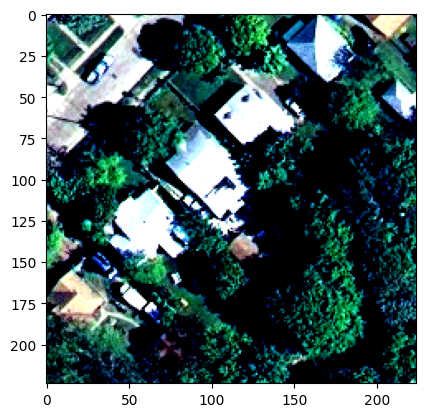

In [75]:
plt.imshow(images[6].to('cpu').detach().permute(1,2,0).numpy())

In [65]:
outputs.data

tensor([[ 2.0123,  1.4817,  1.5154, -1.8619, -1.8712, -1.7615, -2.2187, -1.9305,
         -1.9220, -2.3869],
        [ 2.0069,  1.5026,  1.8666, -1.7231, -2.1639, -1.5331, -1.8995, -1.7010,
         -2.1280, -2.3112],
        [ 2.2369,  1.8990,  2.4352, -2.0584, -2.1336, -1.4662, -2.3523, -2.1189,
         -2.5797, -2.5373],
        [ 1.8880,  1.9107,  2.6100, -2.2663, -2.3417, -2.3164, -2.3600, -1.9185,
         -2.5168, -2.9944],
        [ 2.1850,  2.2962,  2.5323, -2.2568, -2.2266, -1.8819, -2.7331, -2.3868,
         -2.5260, -2.3948],
        [ 1.7305,  1.8451,  2.3865, -2.1348, -1.9683, -1.5624, -2.6137, -1.9264,
         -2.2050, -2.1752],
        [ 1.4736,  1.7395,  2.0854, -1.9252, -1.9549, -1.8248, -2.2234, -1.7303,
         -1.8342, -2.2706],
        [ 1.5751,  1.6854,  1.8920, -1.7454, -2.0133, -1.8608, -2.3666, -1.6405,
         -2.0174, -2.4567],
        [ 2.2935,  1.7672,  2.3665, -2.1608, -2.5594, -2.4036, -2.3387, -2.1776,
         -2.6867, -2.6427],
        [ 1.5371,  

In [19]:
vae.load_state_dict(torch.load('vae_best.pth'))
digit_clf.load_state_dict(torch.load('digit_clf_best.pth'))

<All keys matched successfully>

In [20]:
def evaluate_model(model,data_loader,device):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    model.eval()
    model.to(device)

    with torch.no_grad():
        for data in data_loader:
            images, labels, _ = data
            images,labels = images.to(device),labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the validation images: {100 * correct // total} %')
    return accuracy


In [ ]:

model = models.get_baseline_clf().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),0.003)
model.train()
epochs = 40
for epoch in tqdm.tqdm(range(epochs)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels,dom_label = data
        inputs,labels= inputs.to(device),labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0
        # print(f"epoch : {epoch} loss : {loss.item()}")
        # running_loss += loss.item()
        # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (epoch+1) :.3f}')

print('Finished Training')

In [76]:
baseline = models.get_baseline_clf(finetuned=True)

/Users/karthiksanka/opt/anaconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/karthiksanka/opt/anaconda3/envs/deeplearning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [80]:
ucm_val_acc = evaluate_model(baseline,val_loader_ucm,device)

Accuracy of the network on the validation images: 93 %


In [81]:
ucm_val_acc = evaluate_model(baseline,val_loader_naip,device)

Accuracy of the network on the validation images: 79 %


In [39]:
for (src_img,src_label,src_domain),(tgt_img,tgt_label,tgt_domain) in zip(rand_loader_ucm_test,rand_loader_naip_test):
    inp_img = torch.cat([src_img,tgt_img],dim = 0).to(device)
    inp_label = torch.cat([src_label,tgt_label],dim = 0).to(device)
    break

        

In [40]:
rand_loader_naip_test